# 개요

- 출처
  - 원본 데이터 셋
    - [Paris Housing Price Prediction](https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 내용 : 교육 목적, 실습 및 필요한 지식 습득을 위한  파리의 가상 집값 데이터에서 생성된 데이터 셋
- 평가지표 : RMSE 
- 타임라인 : 2023.2.7 ~ 2023.2.20

In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
# 모든 부스팅 계열 모델 최신 모델로 업그레이드
!pip install --upgrade catboost
!pip install --upgrade xgboost
!pip install --upgrade lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [243]:
import xgboost, catboost, lightgbm
xgboost.__version__, catboost.__version__, lightgbm.__version__

('1.7.4', '1.1.1', '3.3.5')

## 데이터 준비 및 확인

In [244]:
# 기본 패키지 도구 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 경로
path = '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.6/'

origin = pd.read_csv(path + 'ParisHousing.csv')
train = pd.read_csv(path + 'train.csv', index_col='id')
test = pd.read_csv(path + 'test.csv', index_col='id')
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')

In [245]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 17), (15154, 16), (15154, 1))

In [246]:
print(origin.columns)
print(train.columns)
print(test.columns)
print(submission.columns)
# price 변수를 제외하고 컬럼명 동일

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')
Index(['price'], dtype='object')


```
< 각 속성 확인 >
'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스정도 의미를 가진다 ( 컬럼 제거 가능 )
'squareMeters', : 방 면적 넓이 ( 연속형 )
'numberOfRooms', : 방 개수 ( 연속형 )
'hasYard', : 마당 존재 여부  ( 이진형 : 0,1 )
'hasPool', : 수영장 존재 여부 ( 이진형 : 0,1 )
'floors', : 층 수 ( 이산형 )
'cityCode', : 건물 구별 고유 코드 
'cityPartRange', : 지역구로 추정 ( 범주형 : 1 ~ 10 )
'numPrevOwners', : 이전 집 소유자 거친 횟수 ( 이산형 )
'made', : 제작연도 ( 범주형 )
'isNewBuilt',: 리빌딩 여부 ( 이진형 : 0,1 )
'hasStormProtector', : 태풍 보호기 설치 여부 ( 이진형 : 0,1 )
'basement', : 지하실 면적 넓이 (연속형)
'attic', : 다락방 면적 넓이 (연속형)
'garage', : 주차장 크기 (연속형)
'hasStorageRoom', : 창고 여부 ( 이진형 : 0,1 )
'hasGuestRoom', : 게스트 룸 개수 ( 이산형 )
'price' : 종속변수(Target), 시세 예측값
```

In [247]:
train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,55825,84,1,0,70,12031,3,10,2000,0,0,4477,786,345,0,0,5594137.1
22726,65870,88,1,0,49,23197,9,9,2015,0,1,4811,2454,755,0,7,6594705.0
22727,93192,42,1,0,39,8539,10,5,2014,1,0,5595,4072,789,0,0,9321511.4


In [248]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [249]:
test

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37879,86184,74,1,1,73,14009,2,10,1993,1,0,3714,3894,665,1,1
37880,45885,41,1,1,64,84208,4,5,2008,0,0,783,7628,976,0,0
37881,73554,51,0,0,41,49263,10,5,2004,0,1,8207,1777,775,0,10


In [250]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15154 entries, 22730 to 37883
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   squareMeters       15154 non-null  int64
 1   numberOfRooms      15154 non-null  int64
 2   hasYard            15154 non-null  int64
 3   hasPool            15154 non-null  int64
 4   floors             15154 non-null  int64
 5   cityCode           15154 non-null  int64
 6   cityPartRange      15154 non-null  int64
 7   numPrevOwners      15154 non-null  int64
 8   made               15154 non-null  int64
 9   isNewBuilt         15154 non-null  int64
 10  hasStormProtector  15154 non-null  int64
 11  basement           15154 non-null  int64
 12  attic              15154 non-null  int64
 13  garage             15154 non-null  int64
 14  hasStorageRoom     15154 non-null  int64
 15  hasGuestRoom       15154 non-null  int64
dtypes: int64(16)
memory usage: 2.0 MB


In [251]:
origin

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


In [252]:
origin.info()
# 대부분 확인 시 모든 컬럼이 수치형으로 되어있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [253]:
submission

,price
id,
22730,4634456.897
22731,4634456.897
22732,4634456.897
22733,4634456.897
22734,4634456.897
...,...
37879,4634456.897
37880,4634456.897
37881,4634456.897


# 초기 파악

## 결측치 확인

In [254]:
# 참고 :  https://plotly.com/python-api-reference/

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 결측치 없음

squareMeters         0.0
isNewBuilt           0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
made                 0.0
numberOfRooms        0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
price                0.0
dtype: float64
squareMeters         0.0
isNewBuilt           0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
made                 0.0
numberOfRooms        0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
price                0.0
dtype: float64
squareMeters         0.0
numberOfRooms        0.0
hasYard              0.0
hasPool              0.0
floors              

<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [255]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 분포 확인 시 별 차이가 안 보인다
# hasYard, hasPool, hasStorageRoom, isNewBuilt, hasStormProtector는 이진형인것을 알음

hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
cityPartRange           10
numPrevOwners           10
hasGuestRoom            11
made                    32
numberOfRooms          100
floors                 100
garage                 901
attic                 6267
basement              6352
squareMeters          9483
cityCode              9509
price                10000
dtype: int64
hasYard                 2
hasPool                 2
hasStorageRoom          2
isNewBuilt              2
hasStormProtector       2
cityPartRange          10
numPrevOwners          10
hasGuestRoom           11
made                   33
numberOfRooms         100
floors                101
garage                896
basement             4903
attic                5167
squareMeters         7319
price                7421
cityCode             7810
dtype: int64
hasYard                 2
hasPool                 2
isNewBuilt           

<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [256]:
train.shape, train.drop_duplicates().shape

((22730, 17), (22730, 17))

In [257]:
test.shape, test.drop_duplicates().shape

((15154, 16), (15154, 16))

In [258]:
origin.shape, origin.drop_duplicates().shape

((10000, 17), (10000, 17))

## 데이터 요약

In [259]:
train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


In [260]:
test.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000
mean,45729.407681,47.874951,0.483371,0.445361,46.401148,50185.582750,5.616933,5.602547,2006.225485,0.472219,0.463442,5299.415468,5057.506599,525.091065,0.463178,5.095618
std,29200.142520,28.164077,0.499740,0.497022,27.000547,31227.690126,2.727914,2.718316,8.156347,0.499244,0.498678,2980.156234,2928.004147,268.504745,0.498659,3.049174
min,69.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,8.000000,1.000000,8.000000,0.000000,0.000000
25%,19189.000000,25.000000,0.000000,0.000000,25.000000,23141.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,3114.000000,2567.000000,294.250000,0.000000,2.000000
50%,43802.000000,46.000000,0.000000,0.000000,44.000000,50693.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,5017.000000,501.000000,0.000000,5.000000
75%,70898.000000,75.000000,1.000000,1.000000,69.000000,76264.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7739.000000,7650.750000,757.000000,1.000000,8.000000
max,99999.000000,100.000000,1.000000,1.000000,100.000000,977950.000000,10.000000,10.000000,2021.000000,1.000000,1.000000,89016.000000,38535.000000,1000.000000,1.000000,10.000000


In [261]:
origin.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07


## 전체 요약 (함수화 처리)

In [262]:
def summary(df, train=train):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
summary_df = summary(train)
summary_df

data shape: (22730, 17)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,7319,89.0,6071330.0,4.658622e+04,34291.0,95145.0,92661.0
numberOfRooms,int64,0,100,1.0,100.0,4.824109e+01,24.0,60.0,45.0
hasYard,int64,0,2,0.0,1.0,4.758909e-01,1.0,0.0,1.0
hasPool,int64,0,2,0.0,1.0,4.527497e-01,0.0,1.0,1.0
floors,int64,0,101,1.0,6000.0,4.730598e+01,47.0,60.0,62.0
cityCode,int64,0,7810,3.0,491100.0,5.001380e+04,35693.0,34773.0,45457.0
cityPartRange,int64,0,10,1.0,10.0,5.585042e+00,2.0,1.0,4.0
numPrevOwners,int64,0,10,1.0,10.0,5.620766e+00,1.0,4.0,8.0
made,int64,0,33,1990.0,10000.0,2.008005e+03,2000.0,2000.0,2020.0
isNewBuilt,int64,0,2,0.0,1.0,4.679718e-01,0.0,0.0,1.0


In [263]:
summary_df2 = summary(origin)
summary_df2
# 오리지널 데이터와 비교 시, 차이가 나는 부분이 보인다. squareMeters, floors, cityCode, made, basement, attic, garage에 이상치가 있다는 것을 추측

data shape: (10000, 17)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,9483,89.0,99999.0,4.987013e+04,75523.0,80771.0,55712.0
numberOfRooms,int64,0,100,1.0,100.0,5.035840e+01,3.0,39.0,58.0
hasYard,int64,0,2,0.0,1.0,5.087000e-01,0.0,1.0,0.0
hasPool,int64,0,2,0.0,1.0,4.968000e-01,1.0,1.0,1.0
floors,int64,0,100,1.0,100.0,5.027630e+01,63.0,98.0,19.0
cityCode,int64,0,9509,3.0,99953.0,5.022549e+04,9373.0,39381.0,34457.0
cityPartRange,int64,0,10,1.0,10.0,5.510100e+00,3.0,8.0,6.0
numPrevOwners,int64,0,10,1.0,10.0,5.521700e+00,8.0,6.0,8.0
made,int64,0,32,1990.0,2021.0,2.005488e+03,2005.0,2015.0,2021.0
isNewBuilt,int64,0,2,0.0,1.0,4.991000e-01,0.0,1.0,0.0


# EDA

- EDA 진행중 수행하는 시각화는 평면적인 데이터에서 주요 특성을 드러내는 효과적인 방법

- 데이터 종류 (복습)
 
|범주형(Categorical)|--|예시|특징|
|--|--|--|--|
|명목형(Nominal)|--|성별, 음식종류|순위가 없다.서열없다|
|순서형(Ordinal)|--|학점, 순위, 평점|순위를 매길수 있다. |
* 사칙연산이 가능한 데이터

|수치형(Numerical)|--|예시|특징|
|--|--|--|--|
|이산형(Discrete)|--|메뉴개수, 책개수|정수로 떨어지는 셀 수 있는 데이터, 소수점없음|
|연속형(Continous)|--|키,몸무게,집값|값이끊기지 않고 연속된 데이터, 소수점가능|
* 범주로 나눠지는 데이터

- [기초 통계 이해](https://m.blog.naver.com/dairum_enc/221409597367)
- [범주형,수치형,이상형,연속형,명목형,순서형 정리 - Unique Life](https://horae.tistory.com/entry/%EB%B2%94%EC%A3%BC%ED%98%95%EC%88%98%EC%B9%98%ED%98%95%EC%9D%B4%EC%83%81%ED%98%95%EC%97%B0%EC%86%8D%ED%98%95%EB%AA%85%EB%AA%A9%ED%98%95%EC%88%9C%EC%84%9C%ED%98%95-%EC%A0%95%EB%A6%AC)

In [264]:
# 앞 선 데이터셋 (기준) 요약을 통해서 데이터 유형을 분류해보았다.

# 범주형
features_cat = ['hasYard', 'hasPool', 'cityPartRange', 'numPrevOwners', 'isNewBuilt','hasStormProtector', 'hasStorageRoom','hasGuestRoom',]

# 이진형
features_bin = ['hasYard', 'hasPool','isNewBuilt','hasStormProtector', 'hasStorageRoom']

# 연속형
features_cont=['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage' ]


# 종속변수
target = 'price'

## Target 분포 확인

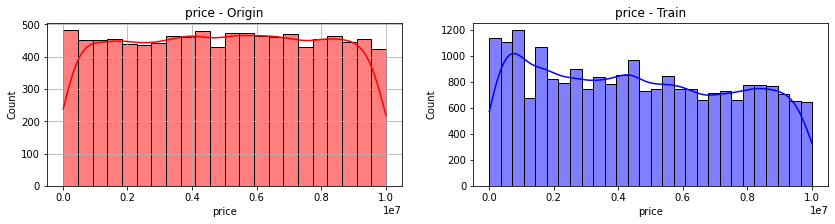

In [265]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=origin[target], color='r', kde=True)
plt.title(target + ' - Origin')
plt.grid()
ax2 = plt.subplot(1,2,2)
sns.histplot(x=train[target], color='b', kde=True)
plt.title(target + ' - Train')
plt.show()

# 가격대의 분포가 다양하는 것을 보아 여러 가격대가 있는 것으로 보인다.

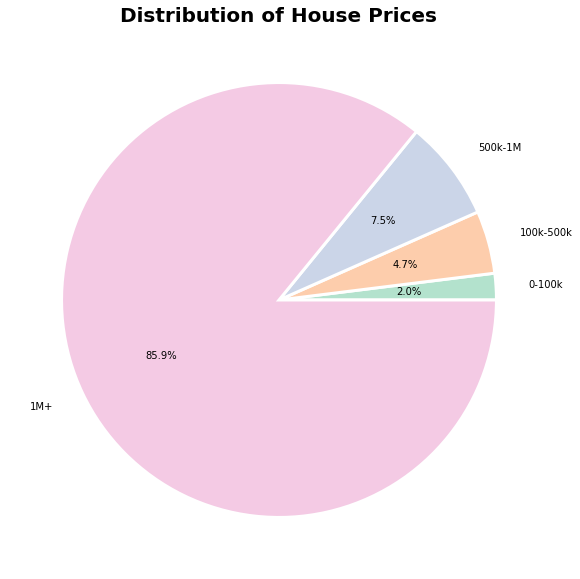

In [266]:
# 앞 선 histplot를 통해서 가격대를 10,50,100만대로 나눠서 확인

plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, train['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
train['price_range'] = pd.cut(train['price'], bins=bins, labels=labels)


plt.pie(train['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

plt.show()

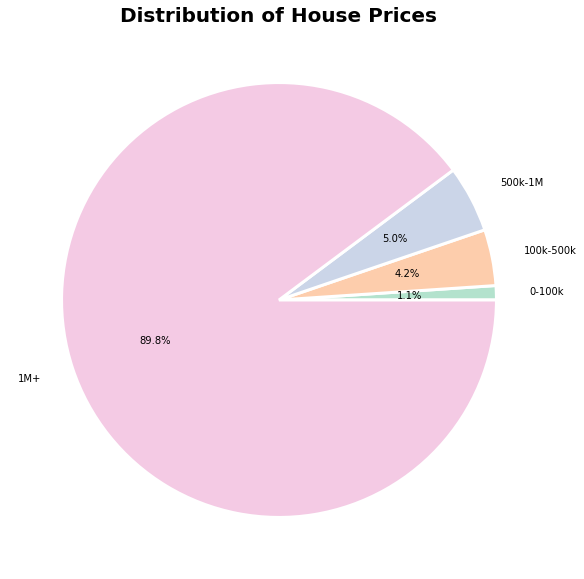

In [267]:
plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, origin['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
origin['price_range'] = pd.cut(origin['price'], bins=bins, labels=labels)


plt.pie(origin['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

plt.show()
# 대부분 집값이 백만이상이다.

## Displot

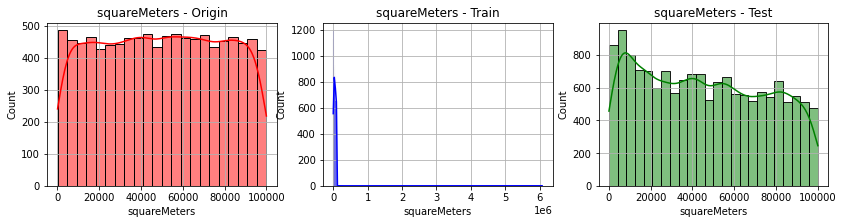

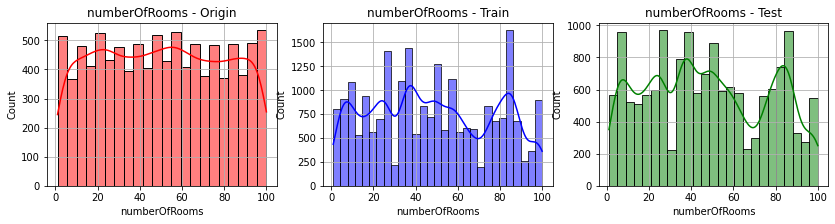

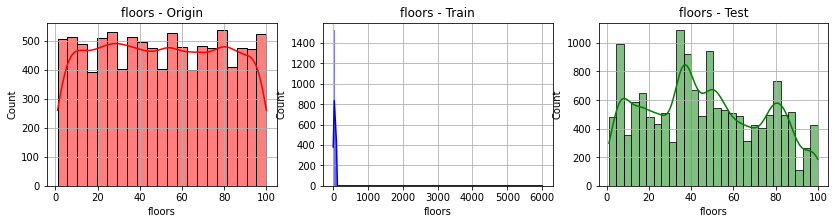

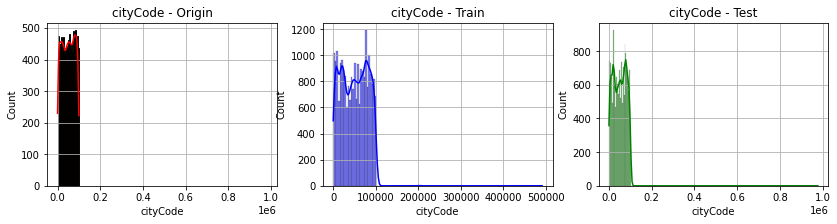

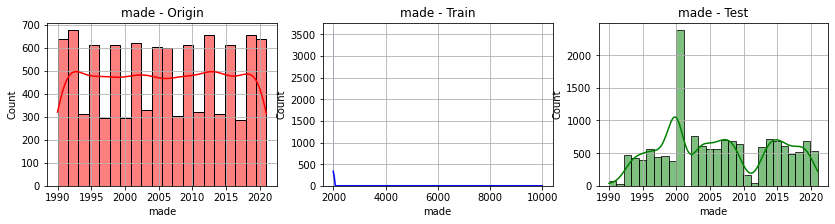

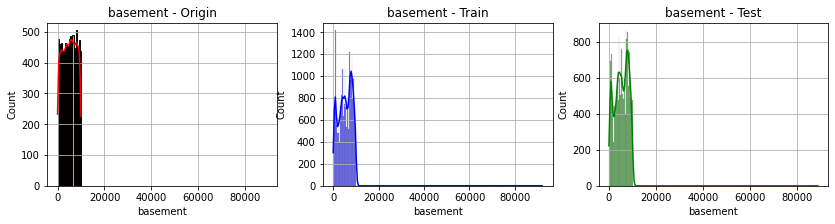

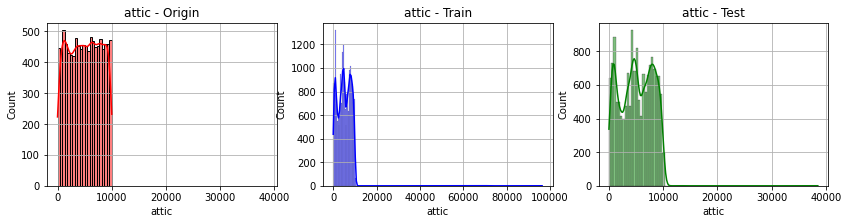

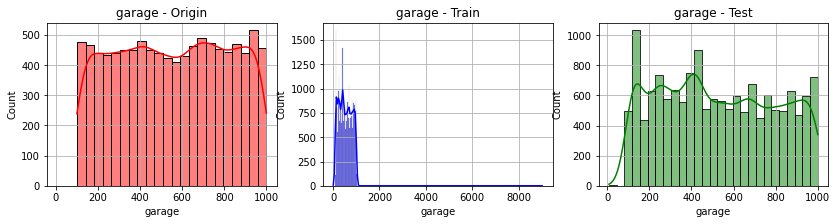

In [268]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 확인 시 train,test에서 비대칭(skewed) 데이터가 보인다. -> Skewed Data https://dining-developer.tistory.com/18

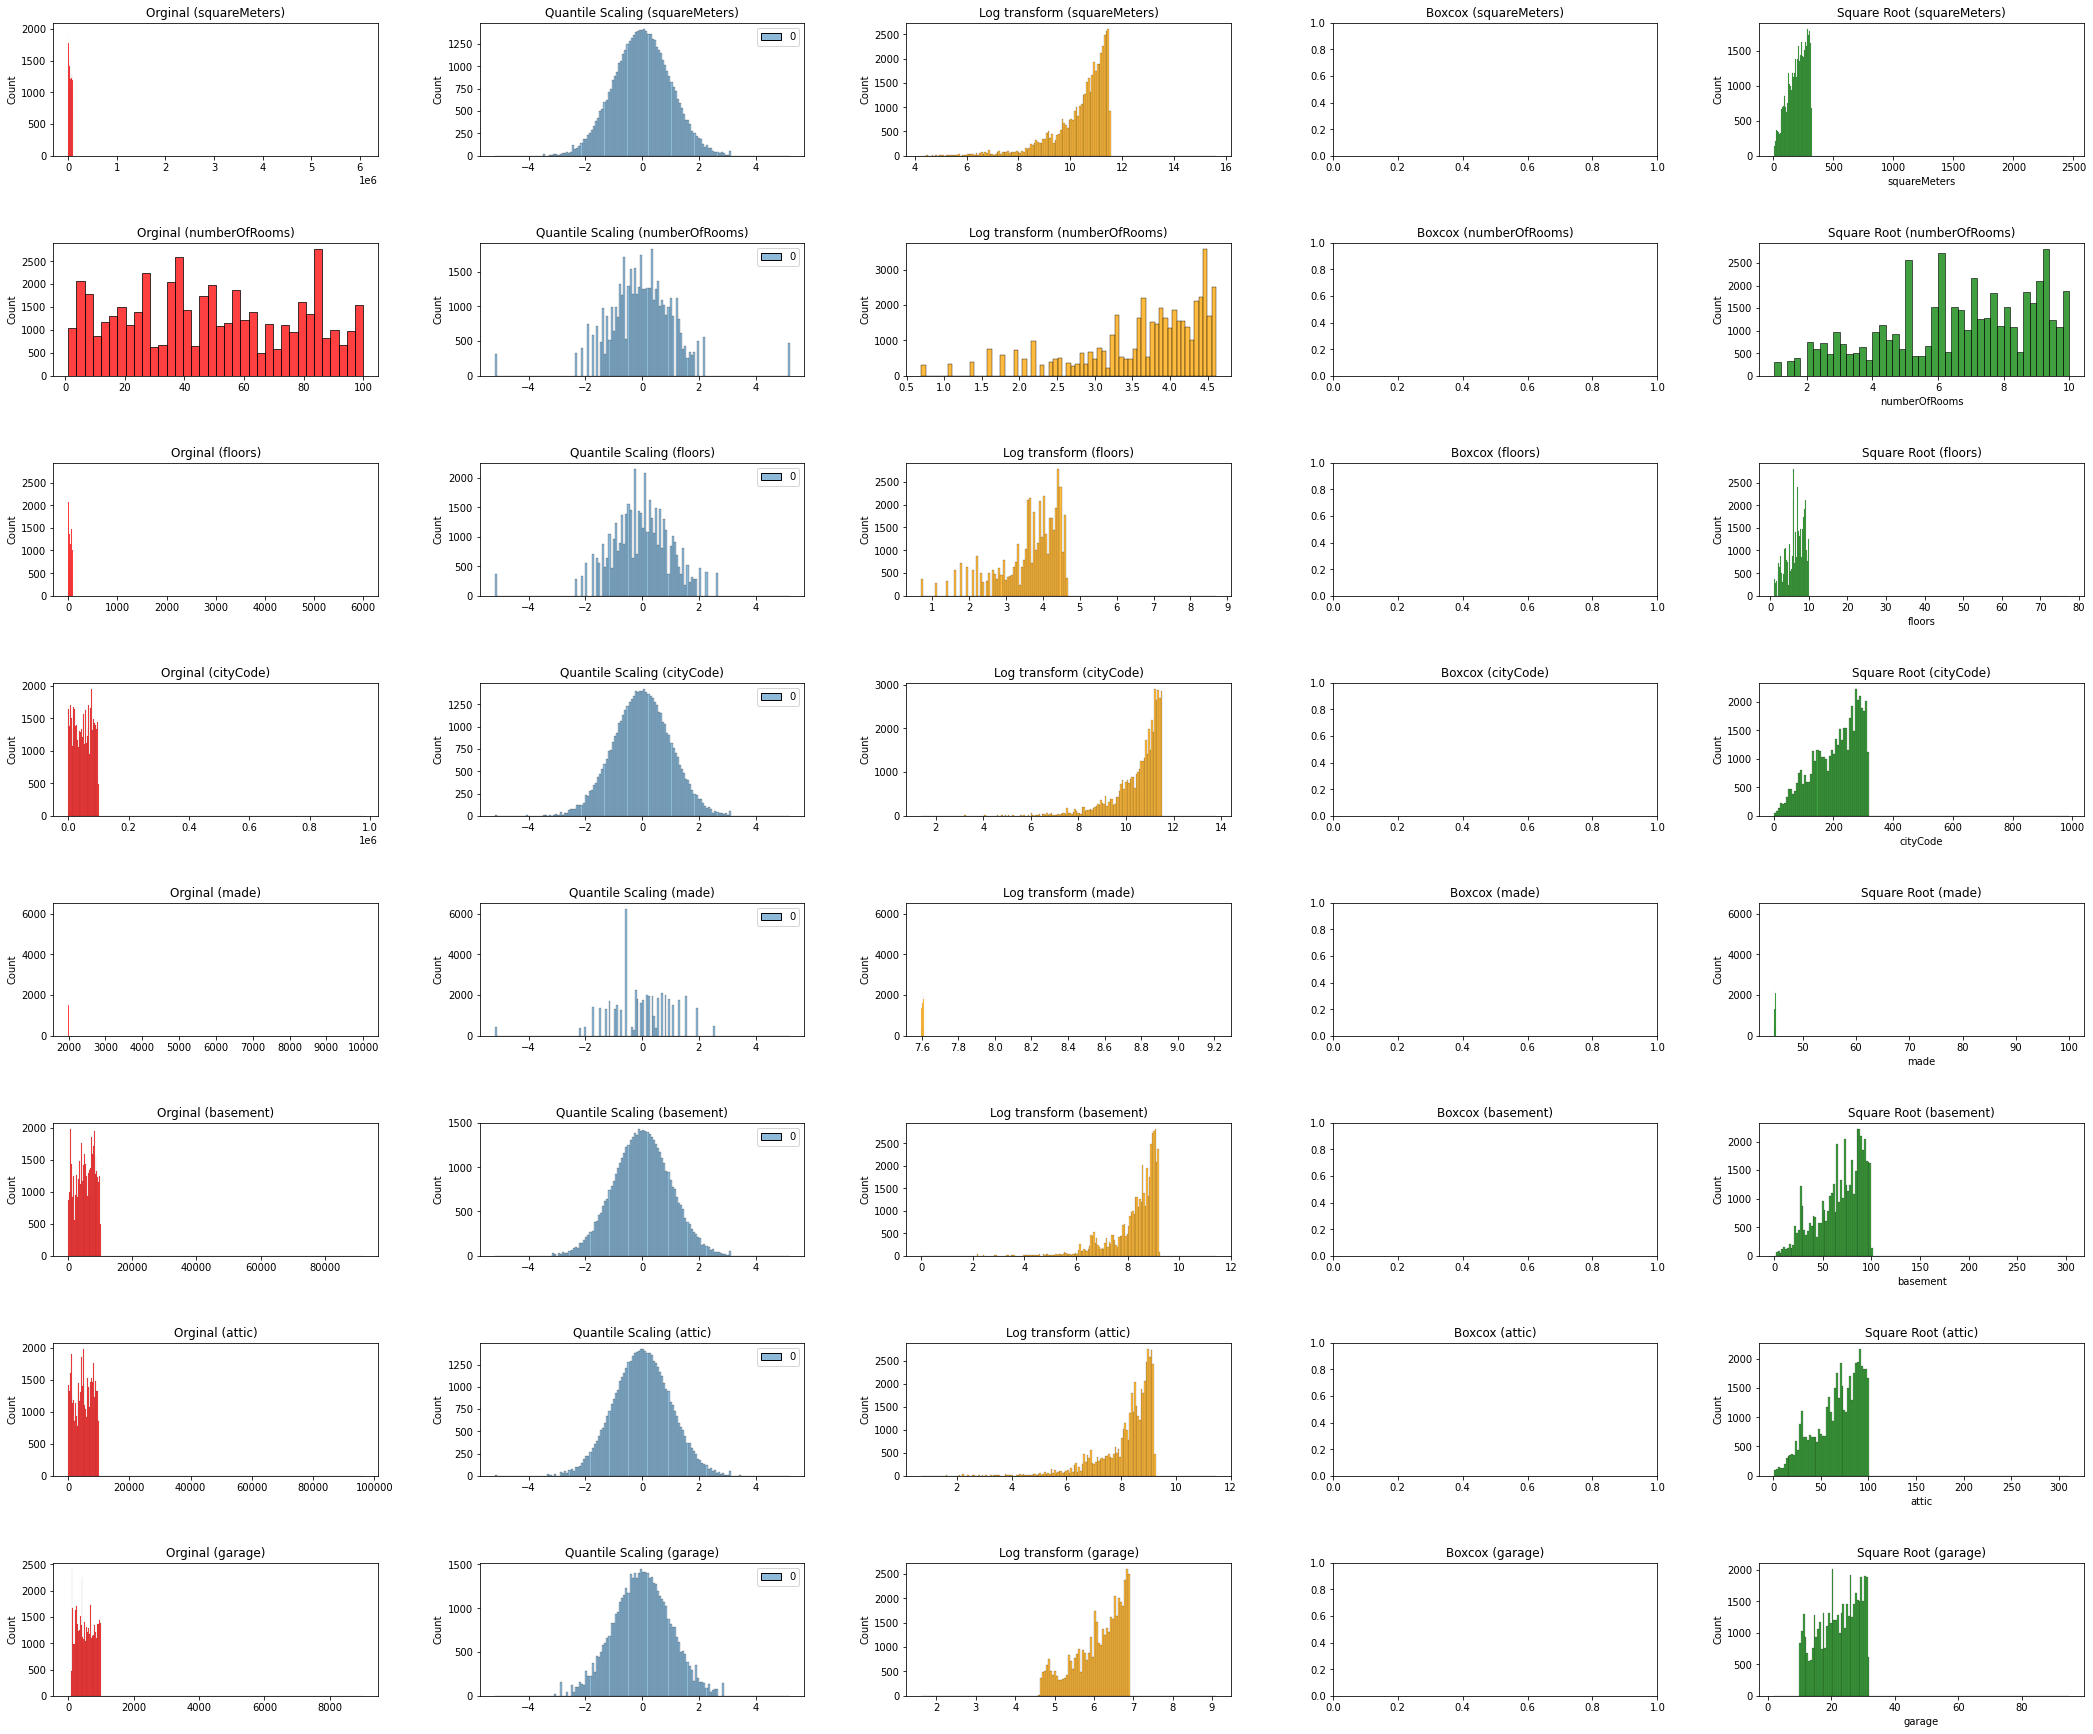

In [269]:
# 위에서 보인 비대칭 피처를 변환시키기 위해서는 어떤 방식으로 해야 될까
# 참고 : https://www.kaggle.com/code/slythe/1-eda-model-selection-pse3e6-regression

from scipy.stats import boxcox, median_abs_deviation 
from sklearn.preprocessing import QuantileTransformer

all_data = pd.concat([origin,train,test], ignore_index=True)

fig, axes = plt.subplots(len(features_cont),5, figsize = (30,25))

for i,col in enumerate(features_cont):
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(all_data[[col]])

    sns.histplot(x= all_data[col],ax= axes[i,0], color = "r")
    sns.histplot(quant_df,ax= axes[i,1] )
    sns.histplot(np.log1p(all_data[col]), ax = axes[i,2], color= "orange")

    try:
        sns.histplot(boxcox(all_data[col], 0.15)[0], ax = axes[i,3], color= "orange")

    except:
        pass

    sns.histplot(np.sqrt(all_data[col]), ax = axes[i,4], color= "green")

    axes[i,0].set_title(f"Orginal ({col})")
    axes[i,0].set(xlabel=None)
    axes[i,1].set_title(f"Quantile Scaling ({col})")
    axes[i,2].set_title(f"Log transform ({col})")
    axes[i,2].set(xlabel=None)
    axes[i,3].set_title(f"Boxcox ({col})")
    axes[i,4].set_title(f"Square Root ({col})")

plt.tight_layout(pad = 4)
plt.show()

# 확인 시 Quantile Scaling를 사용 시 정규분포 형태에 가까워 진다는 것을 알 수 있었다.

## Boxplot

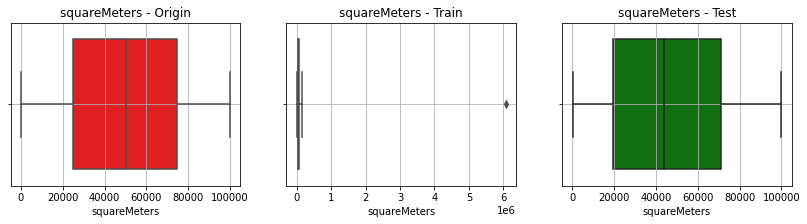

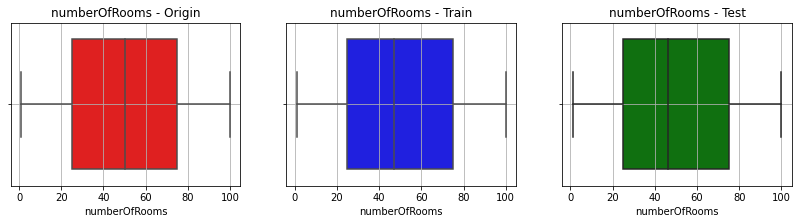

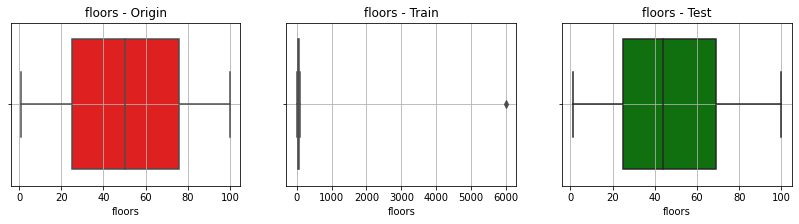

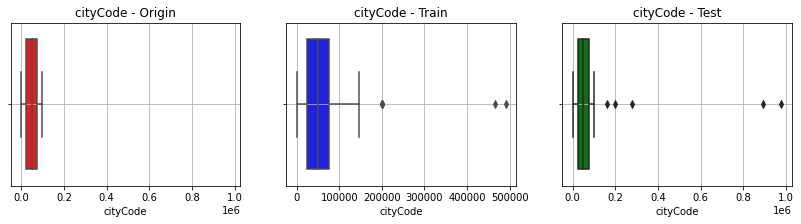

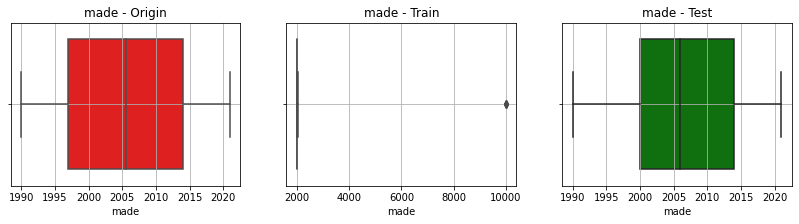

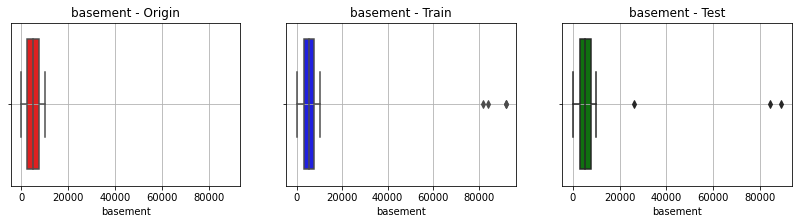

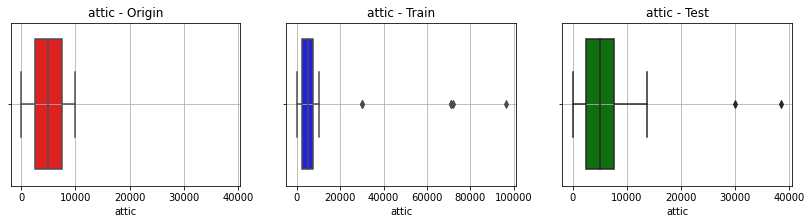

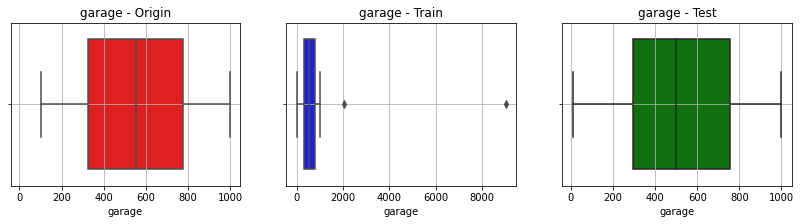

In [270]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 원본에는 이상치 X, train/test이상치가 존재하는 것이 확인 -> squareMeter, floors, citycode, made, basement, attic, garage
# 다만 test 데이터 셋에서는 citycode, basement, attic 만 해당 됨 

## Countplot 

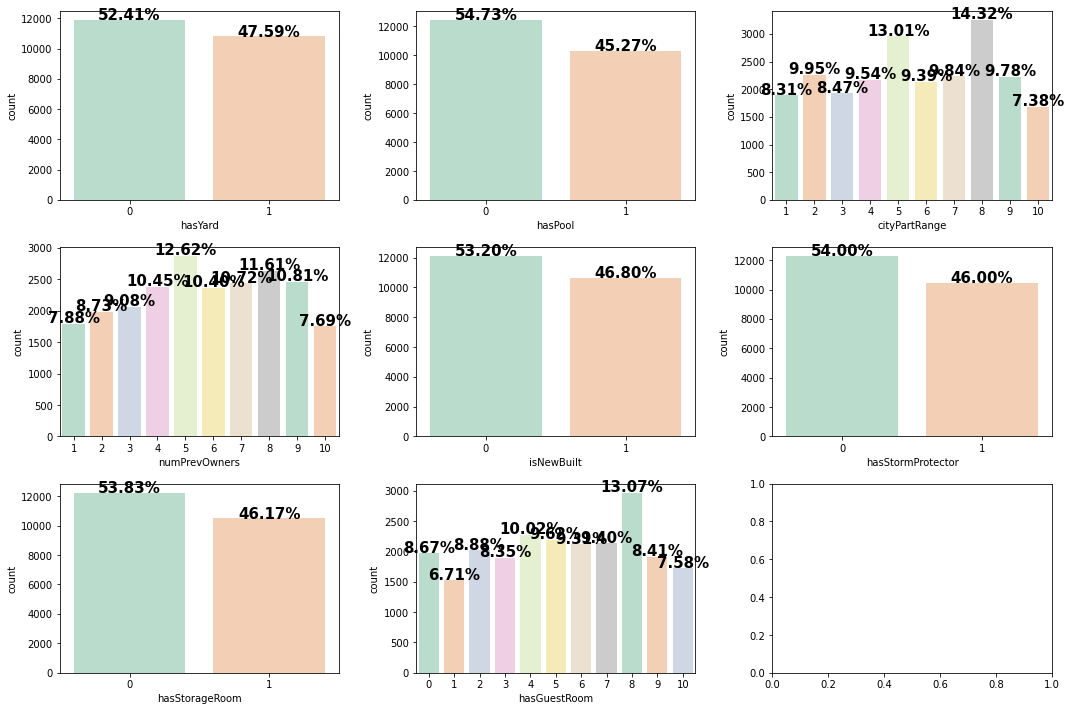

In [271]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(features_cat):
    sns.countplot(x=train[column], ax=axes[i],palette='Pastel2')
    for j in axes[i].patches:
        height = j.get_height()
        axes[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(train) * 100),
                ha="center", fontsize=15,fontweight='bold')

plt.tight_layout()
plt.show()

## ScatterPlot

- **이상치 제거후 확인 시 선형관계 확인 가능**

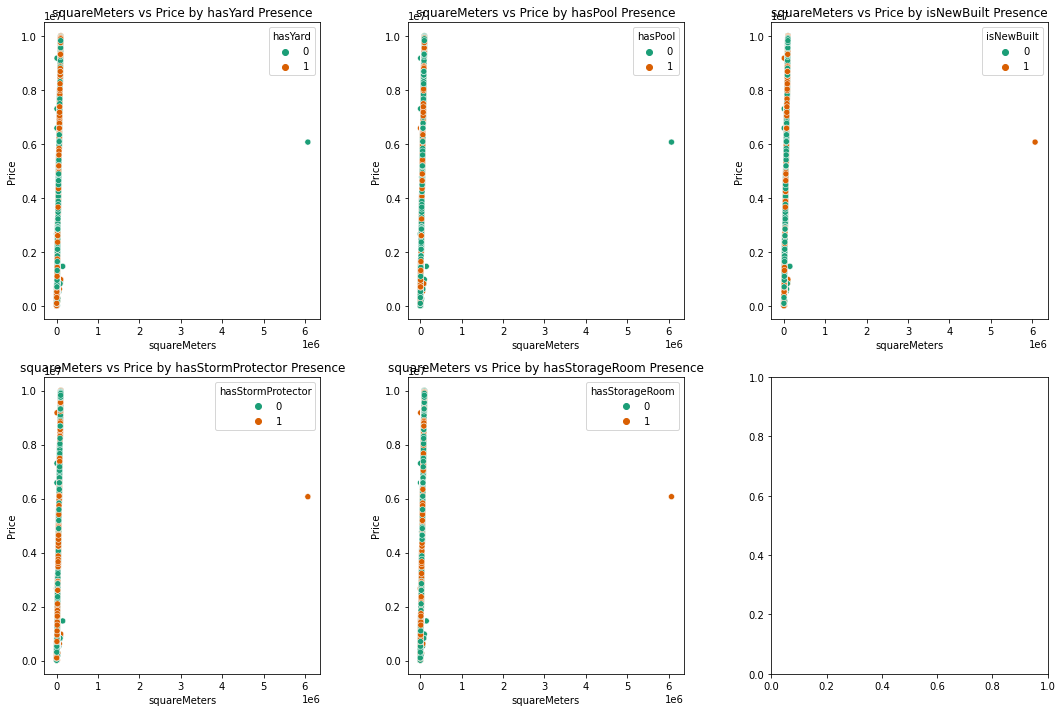

In [272]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(features_bin ):
    sns.scatterplot( x= train['squareMeters'], y=train['price'], hue = train[column], ax=axs[i],palette='Dark2')
    axs[i].set_title('squareMeters vs Price by '+ column +' Presence')
    axs[i].set_xlabel('squareMeters')
    axs[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

## Regplot

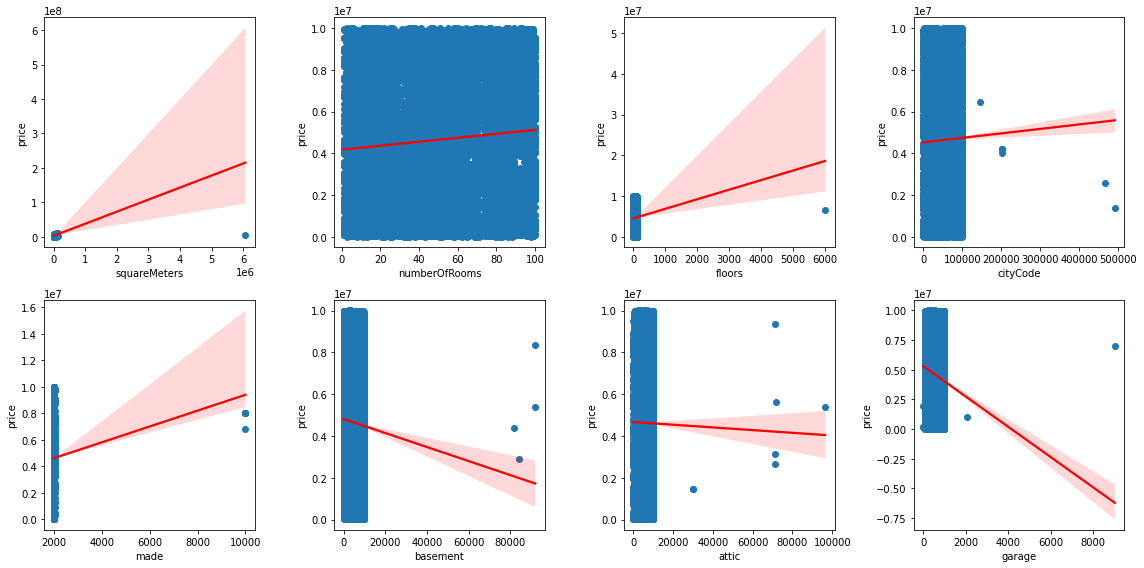

In [273]:
fig, axes = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

for i, feature in enumerate(features_cont):
    row = int(i/4) 
    col = int(i%4)
    sns.regplot(x=feature,y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})

plt.tight_layout()
plt.show()

# 연속형 확인 시 squareMeters, floor, made가 어느정도 선형이 보임

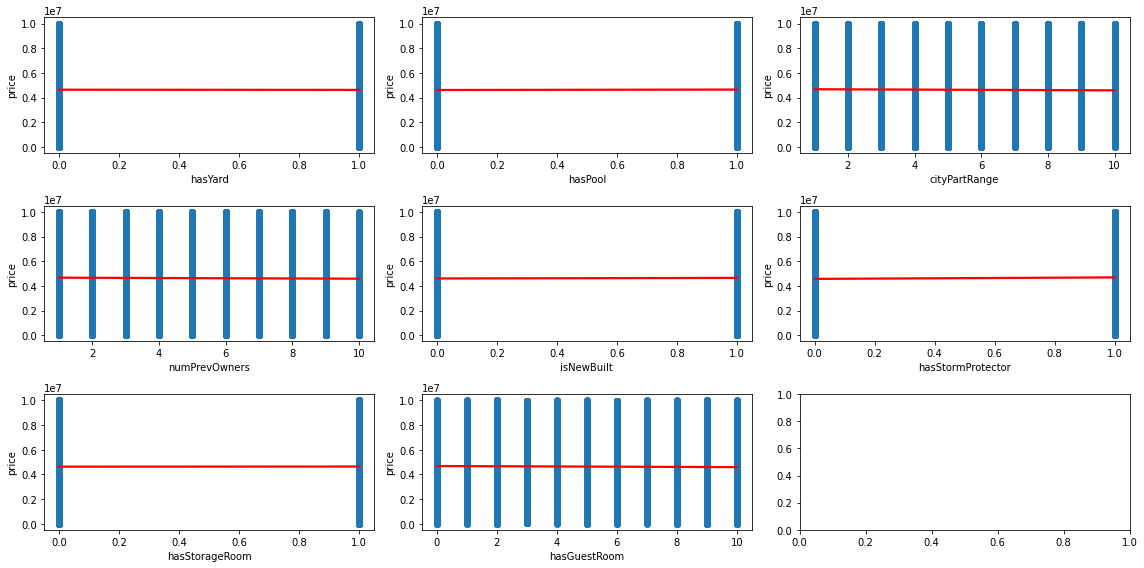

In [274]:
fig, axes = plt.subplots(figsize=(16,8), ncols=3, nrows=3)

for i, feature in enumerate(features_cat):
    row = int(i/3) 
    col = int(i%3)
    sns.regplot(x=feature, y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})
    
plt.tight_layout()
plt.show()

## Heatmap

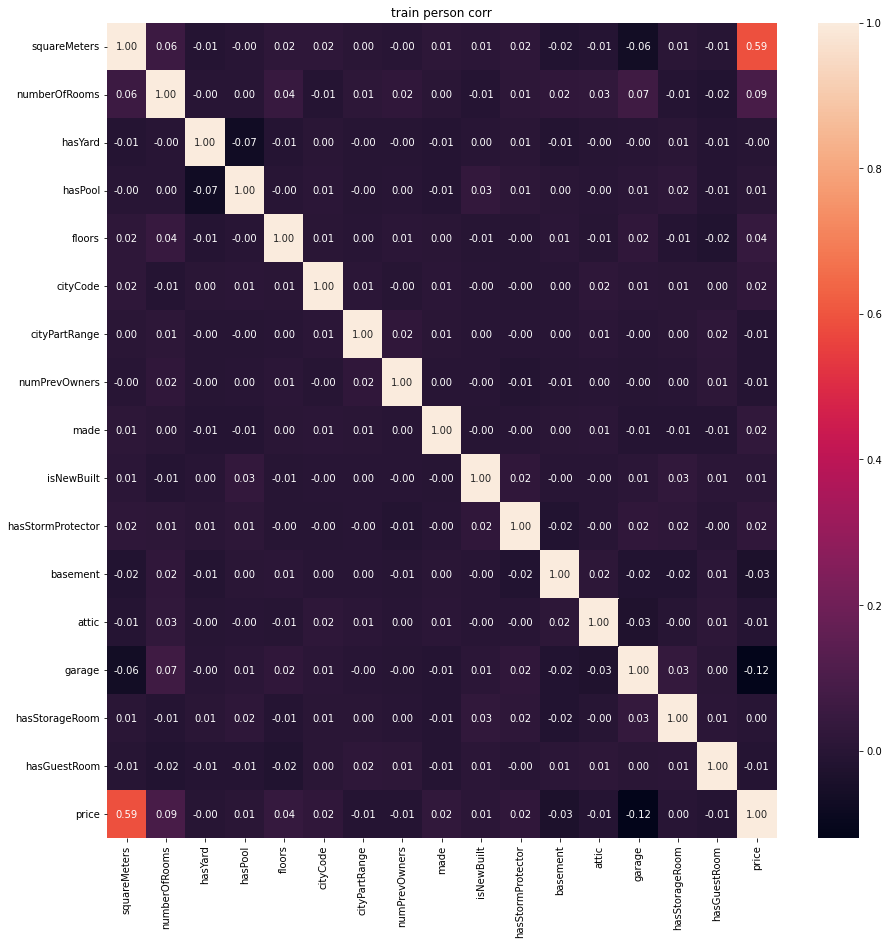

In [275]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# squareMeter를 제외하고 대부분 약한 상관관계를 가지고 있다.

# EDA 결과

- origin/train/test 데이터 셋에서는 결측치는 X 
- Boxplot 확인 시, train/test 데이터 셋에서 이상치는 다음과 같다 : squareMeters, floors, cityCode, made, basement, attic, garage는 
- Heatmap 확인 시 squaremeter 제외하고 다 약한 상관관계를 가지고 있다.
- Regplot 확인 시, basement, attic, garage는 price를 예측 시 도움이 되지 않는다


# 피처 엔지니어링

In [276]:
# 기본 패키지 도구 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 경로
path = '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.6/'

origin = pd.read_csv(path + 'ParisHousing.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 18), (15154, 17), (15154, 2))

In [277]:
train = train.drop('id', axis=1)
test = test.drop('id',axis=1)

In [278]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 17), (15154, 16), (15154, 2))

## 이상치 탐지 

- 앞 선 boxplot을 통해서 이상치를 확인 할 수 있었다. -> 이상치가 있는 특성만 따로 뽑아서 확인
  -  함수화 처리 참고 :  [IQR을 이용하여 이상치를 탐색하고 처리하기](https://hong-yp-ml-records.tistory.com/15)

In [279]:
# 이상치 탐지 ( 전체 부분 )
from collections import Counter

features_out = ['squareMeters', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage']

def detect_outliers(df,features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    print(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items())
    
        
    return multiple_outliers

In [280]:
Outliers_to_drop = detect_outliers(train, features_out)
print(f'이상치 총 개수 {len(Outliers_to_drop)} 개')
train.loc[Outliers_to_drop] 
# iqr 방식으로 모든 이상치를 확인 

Counter({15334: 1, 5659: 1, 299: 1, 1326: 1, 2425: 1, 10987: 1, 20735: 1, 22631: 1, 2113: 1, 3608: 1, 19124: 1, 19748: 1, 21400: 1, 2107: 1, 3995: 1, 15068: 1, 18926: 1, 3828: 1, 4909: 1, 12858: 1, 13633: 1, 13642: 1, 17168: 1, 19994: 1, 14878: 1, 17629: 1})
이상치 총 개수 26 개


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9
5659,65029,50,0,1,6000,79146,4,5,2012,0,1,5123,230,668,0,4,6507042.1
299,40200,44,1,1,19,201035,5,4,2006,0,0,2538,7437,985,0,0,4028239.6
1326,13591,6,0,1,20,491100,5,9,2000,0,1,8747,5840,675,0,8,1367021.0
2425,25594,35,1,0,50,465360,6,8,1997,0,0,4774,8779,612,1,4,2564288.7
10987,42211,78,0,1,52,200812,7,10,2008,0,1,7645,9349,902,0,0,4230896.8
20735,42211,85,1,1,34,200801,8,7,2008,0,0,8434,9238,798,1,9,4230896.8
22631,42211,84,0,0,56,200801,7,3,2008,0,1,9845,8224,985,1,10,4230896.8
2113,68038,41,0,0,54,87120,3,6,10000,1,1,6537,6304,366,0,0,6807415.1
3608,80062,81,1,0,35,67157,9,4,10000,0,1,732,6475,758,0,4,8007951.1


In [281]:
## 이상치 전부 제거 -> 오히려 떨어짐
#train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [282]:
Outliers_to_drop2 = detect_outliers(test, features_out)
print(f'이상치 총 개수 {len(Outliers_to_drop2)} 개')
test.loc[Outliers_to_drop2] 

# 테스트 셋 기준, iqr 방식으로 이상치는 cityCode, basement, attic에 있음 -> 제거 X 

Counter({4987: 1, 6503: 1, 8215: 1, 10525: 1, 13111: 1, 696: 1, 1789: 1, 11191: 1, 2838: 1, 9148: 1})
이상치 총 개수 10 개


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
4987,42211,51,0,1,13,200801,2,8,2008,1,0,874,9238,796,0,10
6503,95894,34,1,1,7,889795,6,9,2005,0,1,7381,75,582,0,6
8215,68824,8,0,1,34,977950,4,5,1990,0,0,6044,2097,665,1,7
10525,18368,22,0,1,71,279019,8,10,2000,0,1,6133,6642,289,1,4
13111,33156,35,1,0,77,162019,5,5,1994,0,0,1285,5075,814,1,6
696,28600,84,1,0,85,598,5,9,2017,1,1,26132,4831,874,1,7
1789,44838,49,0,1,85,19691,5,9,2009,0,0,84333,8252,865,0,2
11191,43906,58,0,0,79,98779,6,1,2013,1,1,89016,4409,675,0,5
2838,47982,81,1,1,38,52650,1,7,1994,1,1,9727,38535,327,1,10
9148,14588,39,0,1,2,35318,5,7,2003,0,0,3333,30000,357,1,4


In [283]:
# 이상치 탐지 함수 ( 특징 하나 씩 보도록 변경 )

def detect_outlier(df,feature):
  
  Q1 = np.percentile(df[feature], 25)
  Q3 = np.percentile(df[feature], 75)
  IQR = Q3 - Q1
        
  outlier_step = 1.5 * IQR
  
  return df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)]

#### squareMeters ( 방 면적 넓이 )
- Insight
  - [면적순 나라 목록](https://ko.wikipedia.org/wiki/%EB%A9%B4%EC%A0%81%EC%88%9C_%EB%82%98%EB%9D%BC_%EB%AA%A9%EB%A1%9D) 기준으로 보면 나라의 크기를 나타냄 -> <u>이상치 확실</u>
    - 6071330m^2 : 1836577.33 평 [ 평수 계산기 사용 시 ]

- 방 면적 넓이 이상치 대체 참고
  - [squareMeters 이상치 대체](https://www.kaggle.com/competitions/playground-series-s3e6/discussion/388297)


In [284]:
detect_outlier(train,'squareMeters')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9


In [285]:
train.squareMeters.sort_values(ascending=False)
# 확인 시 2개가 이상치가 있음

15334    6071330
4741      146181
17330      99985
14864      99985
5261       99985
          ...   
2356          89
14879         89
12130         89
14314         89
13338         89
Name: squareMeters, Length: 22730, dtype: int64

In [286]:
train[train['squareMeters'] > 146180]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
4741,146181,38,0,0,88,10837,6,7,2000,0,0,5953,8529,1000,0,10,1468435.1
15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9


In [287]:
train[train['cityCode'] == 86523][['squareMeters', 'cityCode', 'price']]
# squareMeters * 100이 price랑 비슷한걸 알 수 있음

,squareMeters,cityCode,price
588,61346,86523,6141452.9
2777,46018,86523,4612424.3
7857,6048,86523,609426.1
11455,39995,86523,4003367.8
15334,6071330,86523,6071330.9
16305,10310,86523,1041341.6
16663,44002,86523,4406097.7


In [288]:
train[train['cityCode'] == 10837][['squareMeters', 'cityCode', 'price']]
# squareMeters * 100이 price랑 비슷한걸 알 수 있음

,squareMeters,cityCode,price
4741,146181,10837,1468435.1
18879,73885,10837,7393278.9
21518,76929,10837,7696040.9


In [289]:
# 이상치 대체
train.loc[train.index.isin([15334]), 'squareMeters'] = 60713
train.loc[train.index.isin([4741]), 'squareMeters'] = 14684

In [290]:
train.squareMeters.sort_values(ascending=False)

17330    99985
14864    99985
5261     99985
13686    99985
21320    99952
         ...  
22519       89
2356        89
14314       89
21718       89
5763        89
Name: squareMeters, Length: 22730, dtype: int64

#### floors ( 층 수 )
- Insight
  - [런던·파리·뉴욕… 세계도 건물 높이 규제](https://www.seouland.com/arti/society/society_general/1609.html) 확인 시 최대 높이 기준 : 1973년 200m가 넘는 몽파르나스 타워(59층) ->  59층 이상도 이상치 인가? -> 확인 필요
  - Boxplot 확인 시 현재 존재하는 건물 들 중 6000층은 말이 안됨 -> <u>이상치 확실</u> 

In [291]:
# train[train.floors > 59]
# 데이터가 제거 시 데이터가 너무 적어짐 ->  방식 X

In [292]:
detect_outlier(train,'floors')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
5659,65029,50,0,1,6000,79146,4,5,2012,0,1,5123,230,668,0,4,6507042.1


In [293]:
train.loc[train.index.isin([5659]), 'floors'] = 100

In [294]:
train.floors.sort_values(ascending=False)

19957    100
1456     100
15969    100
4812     100
6200     100
        ... 
13597      1
12698      1
8715       1
16467      1
21759      1
Name: floors, Length: 22730, dtype: int64

### CityCode ( 도시 코드 )

- [cityCode is Fake!](https://www.kaggle.com/competitions/playground-series-s3e6/discussion/384676) 
  - 임의로 만들어진 특성이므로 의미가 없다고 함 -> 열 자체 삭제 권장

In [295]:
detect_outlier(train,'cityCode')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
299,40200,44,1,1,19,201035,5,4,2006,0,0,2538,7437,985,0,0,4028239.6
1326,13591,6,0,1,20,491100,5,9,2000,0,1,8747,5840,675,0,8,1367021.0
2425,25594,35,1,0,50,465360,6,8,1997,0,0,4774,8779,612,1,4,2564288.7
10987,42211,78,0,1,52,200812,7,10,2008,0,1,7645,9349,902,0,0,4230896.8
20735,42211,85,1,1,34,200801,8,7,2008,0,0,8434,9238,798,1,9,4230896.8
22631,42211,84,0,0,56,200801,7,3,2008,0,1,9845,8224,985,1,10,4230896.8


### made (제작년도) 

- 데이터 셋 기준 확인 시, 2021년도 기준으로 초과 시 미래 시간 (존재하지 않음) -> <u>이상치 확실</u>
- 또한 2002년 부분이 하나만 있으므로, made의 평균으로 대체

In [296]:
train.made.value_counts().sort_index()

1990       77
1991       30
1992       59
1993      651
1994      628
1995      631
1996      822
1997      592
1998      719
1999      588
2000     3588
2001       59
2002        1
2003     1156
2004      915
2005      764
2006      921
2007     1021
2008      981
2009      972
2010      152
2011       68
2012       51
2013      934
2014     1070
2015     1036
2016      910
2017      741
2018      927
2019      956
2020      595
2021      110
10000       5
Name: made, dtype: int64

In [297]:
test.made.value_counts().sort_index()

1990      62
1991      17
1992      30
1993     464
1994     425
1995     402
1996     560
1997     447
1998     460
1999     385
2000    2337
2001      40
2002       1
2003     765
2004     602
2005     558
2006     565
2007     699
2008     682
2009     634
2010     128
2011      36
2012      50
2013     592
2014     711
2015     680
2016     605
2017     480
2018     520
2019     685
2020     445
2021      87
Name: made, dtype: int64

In [298]:
train[train['made'] == 2002]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
8337,86383,95,0,0,8,98660,3,10,2002,1,1,4118,4349,877,1,7,8648031.0


In [299]:
test[test['made'] == 2002]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
7912,67735,63,0,1,9,42204,4,7,2002,0,1,823,8144,735,1,7


In [300]:
mean_train_made = train['made'].mean()
print(mean_train_made)
mean_test_made = test['made'].mean()
print(mean_train_made)

2008.005059392873
2008.005059392873


In [301]:
train.loc[train.index.isin([8337]), 'made'] = 2008
test.loc[test.index.isin([7912]), 'made'] = 2008

In [302]:
detect_outlier(train,'made')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
2113,68038,41,0,0,54,87120,3,6,10000,1,1,6537,6304,366,0,0,6807415.1
3608,80062,81,1,0,35,67157,9,4,10000,0,1,732,6475,758,0,4,8007951.1
19124,80062,52,0,0,84,67099,9,4,10000,0,0,7677,5017,148,0,4,8007951.1
19748,80062,58,0,1,86,40408,7,8,10000,0,0,7059,7307,287,0,2,8007951.1
21400,80062,78,0,0,84,59457,4,7,10000,1,0,6382,9507,298,1,4,8007951.1


In [303]:
train.loc[train.index.isin([2113,3608,19124,19748,21400]), 'made'] = 2021

In [304]:
train.made.sort_values(ascending=False)

21230    2021
19799    2021
20140    2021
2556     2021
17522    2021
         ... 
4307     1990
435      1990
10053    1990
10624    1990
10157    1990
Name: made, Length: 22730, dtype: int64

### basement( 지하실 면적 넓이 )

In [305]:
detect_outlier(train,'basement')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
2107,28956,100,0,1,35,39767,6,9,2000,0,1,84333,8777,655,0,1,2898953.1
3995,43758,14,0,0,93,62528,3,9,2008,0,0,81851,9179,243,0,2,4385098.8
15068,83358,35,1,0,83,22449,9,2,2015,0,0,91992,299,897,0,0,8341911.5
18926,53671,55,0,1,85,6249,7,6,2017,0,1,91978,959,515,1,2,5378022.7


In [306]:
detect_outlier(test,'basement')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
696,28600,84,1,0,85,598,5,9,2017,1,1,26132,4831,874,1,7
1789,44838,49,0,1,85,19691,5,9,2009,0,0,84333,8252,865,0,2
11191,43906,58,0,0,79,98779,6,1,2013,1,1,89016,4409,675,0,5


In [307]:
train.basement.sort_values(ascending=False)[:10]

15068    91992
18926    91978
2107     84333
3995     81851
12829    10000
816      10000
336      10000
8824     10000
352      10000
971      10000
Name: basement, dtype: int64

In [308]:
test.basement.sort_values(ascending=False)[:10]

11191    89016
1789     84333
696      26132
5048     10000
2073     10000
6748     10000
4892     10000
2733     10000
10189    10000
7414     10000
Name: basement, dtype: int64

In [309]:
train.loc[train.index.isin([2107,3995,15068,18926]), 'basement'] = 10000
test.loc[test.index.isin([696,1789,11191]), 'basement'] = 10000

In [310]:
train.basement.sort_values(ascending=False)[:10]

12829    10000
1433     10000
336      10000
8824     10000
352      10000
971      10000
3995     10000
6545     10000
18640    10000
19194    10000
Name: basement, dtype: int64

In [311]:
test.basement.sort_values(ascending=False)[:10]

5048     10000
696      10000
6748     10000
4892     10000
2733     10000
10189    10000
7414     10000
2073     10000
6723     10000
10285    10000
Name: basement, dtype: int64

### attic ( 다락방 면적 넓이 )

In [312]:
detect_outlier(train,'attic')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
3828,31357,80,0,1,35,56962,9,4,2017,1,0,1284,71001,212,0,5,3141062.7
4909,26484,33,0,1,37,83634,5,3,1997,1,1,774,71001,663,0,1,2654798.7
12858,93278,41,1,1,56,46600,9,8,2015,0,1,4145,71024,473,0,3,9339538.5
13633,53708,81,0,0,84,12841,7,6,2006,1,1,759,96381,860,1,8,5378041.6
13642,14588,36,0,0,16,3578,5,2,2003,0,1,5361,30000,357,0,4,1459601.3
17168,56147,100,0,0,35,79570,7,7,2016,1,1,9631,71965,973,0,6,5621340.6
19994,14588,43,1,0,23,38270,10,7,2003,0,1,9789,30000,177,1,4,1459601.3


In [313]:
detect_outlier(test,'attic')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
2838,47982,81,1,1,38,52650,1,7,1994,1,1,9727,38535,327,1,10
9148,14588,39,0,1,2,35318,5,7,2003,0,0,3333,30000,357,1,4


In [314]:
train.attic.sort_values(ascending=False)[:10]

13633    96381
17168    71965
12858    71024
4909     71001
3828     71001
19994    30000
13642    30000
9115     10000
2014     10000
5991     10000
Name: attic, dtype: int64

In [315]:
test.attic.sort_values(ascending=False)[:10]

2838     38535
9148     30000
14769    13779
4892     10000
11506    10000
81       10000
10517     9999
11438     9985
6801      9985
13885     9985
Name: attic, dtype: int64

In [316]:
train.loc[train.index.isin([3828,4909,12858,13633,13642,17168,19994]), 'attic'] = 10000
test.loc[test.index.isin([2838,9148,14769]), 'attic'] = 10000

In [317]:
train.attic.sort_values(ascending=False)[:10]

8956     10000
13347    10000
12858    10000
2014     10000
5991     10000
9864     10000
13633    10000
9115     10000
13642    10000
19994    10000
Name: attic, dtype: int64

In [318]:
test.attic.sort_values(ascending=False)[:10]

4892     10000
11506    10000
2838     10000
81       10000
14769    10000
9148     10000
10517     9999
11438     9985
6801      9985
13885     9985
Name: attic, dtype: int64

### garage ( 주차 공간 크기 )

In [319]:
detect_outlier(train,'garage')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
14878,10380,44,0,0,41,40504,1,4,2020,0,0,8876,803,2048,0,2,1049793.1
17629,70409,86,0,0,90,85476,5,6,2000,1,0,2522,9057,9017,1,3,7042999.2


In [320]:
train.garage.sort_values(ascending=False)[:10]

17629    9017
14878    2048
19089    1000
13018    1000
5981     1000
9597     1000
10458    1000
1074     1000
21585    1000
14120    1000
Name: garage, dtype: int64

In [321]:
train.loc[train.index.isin([14878,17629]), 'garage'] = 1000

In [322]:
train.garage.sort_values(ascending=False)[:10]

19089    1000
14105    1000
17279    1000
5981     1000
9597     1000
10458    1000
1074     1000
21585    1000
14120    1000
6042     1000
Name: garage, dtype: int64

## 데이터 합치기 -- 중간과정

In [323]:
all_data = pd.concat([origin,train,test], ignore_index=True)
all_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47879,86184,74,1,1,73,14009,2,10,1993,1,0,3714,3894,665,1,1,NaN
47880,45885,41,1,1,64,84208,4,5,2008,0,0,783,7628,976,0,0,NaN
47881,73554,51,0,0,41,49263,10,5,2004,0,1,8207,1777,775,0,10,NaN
47882,77604,51,0,1,33,67056,4,3,2019,0,0,9578,9706,135,0,2,NaN


In [324]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47884 entries, 0 to 47883
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       47884 non-null  int64  
 1   numberOfRooms      47884 non-null  int64  
 2   hasYard            47884 non-null  int64  
 3   hasPool            47884 non-null  int64  
 4   floors             47884 non-null  int64  
 5   cityCode           47884 non-null  int64  
 6   cityPartRange      47884 non-null  int64  
 7   numPrevOwners      47884 non-null  int64  
 8   made               47884 non-null  int64  
 9   isNewBuilt         47884 non-null  int64  
 10  hasStormProtector  47884 non-null  int64  
 11  basement           47884 non-null  int64  
 12  attic              47884 non-null  int64  
 13  garage             47884 non-null  int64  
 14  hasStorageRoom     47884 non-null  int64  
 15  hasGuestRoom       47884 non-null  int64  
 16  price              327

In [325]:
all_data.nunique().sort_values()

hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
cityPartRange           10
numPrevOwners           10
hasGuestRoom            11
made                    32
numberOfRooms          100
floors                 100
garage                 903
attic                 6757
basement              6856
squareMeters          9824
price                10000
cityCode             10581
dtype: int64

In [326]:
all_data.isnull().sum()

squareMeters             0
numberOfRooms            0
hasYard                  0
hasPool                  0
floors                   0
cityCode                 0
cityPartRange            0
numPrevOwners            0
made                     0
isNewBuilt               0
hasStormProtector        0
basement                 0
attic                    0
garage                   0
hasStorageRoom           0
hasGuestRoom             0
price                15154
dtype: int64

In [327]:
all_data.shape,all_data.drop_duplicates().shape

((47884, 17), (47883, 17))

## 파생 피처 생성 ( 제외 )

- 현재 특성에서 모델 성능 높이기 위해서 만들어보자 ( Kaggle 토론 참고 )

  - 파리 전체 면적에서 방 면적이 차지하는 비율 어떻게 되는가?

  - 방 가로 세로 길이 ( 정사각형 기준 )

  - 현재 방 면적 넓이의 1평 
    - [Convert pyeong to square Paris foot](https://www.convertunits.com/from/pyeong/to/square+Paris+foot)

  - 방 면적 너비와 방의 수 간의 상호 작용 -> 집에서 공간이 어떻게 사용되는 가?

  - 층 수에 따른 방의 수 -> 방이 많을 수록 손님이 많이 온다 -> 기격 영향에 미치는 가? 

  - 방의 수와 마당의 존재 사이의 상호 작용 ->  야외 공간이 가격에 영향을 미치는 가?

  - 부동산이 만들어진 연도와 신축 여부 사이의 상호 작용 -> 신축 건물이 가격이 영향에 미치는 가?

  - 지하실 크기와 다락방 크기 사이의 상호 작용: 거주 시 사용할 수 있는 추가 공간이 가격이 영향이 미치는 가? 
  
  - 창고의 존재와 객실의 존재 사이의 상호 작용 -> 얼마나 많은 공간이 창고와 손님에게 할당되는가?
    
  - 날짜에서 정보 추출 -> 집의 나이, 집이 지어진 후 경과된 시간과 같은 정보를 추출

In [328]:
# 파생 피처 생성 함수 

def feature_interaction(df):
    df['squareMeters_sqrt'] = np.sqrt(df['squareMeters'])
    df['1_square'] =  df['squareMeters'] / 31.33446
    df['allSpace'] = df['squareMeters'] + df['basement'] + df['attic']

    city_code_count = df['cityCode'].value_counts()    
    df['numHousesInCityCode'] = df['cityCode'].map(city_code_count)
    city_code_space = df.groupby('cityCode')['squareMeters'].sum()
    df['sumAllSpaceInCityCode'] = df['cityCode'].map(city_code_space)

    df['squareMeters_numRooms'] = df['squareMeters'] * df['numberOfRooms']
    df['rooms_floor'] = df['numberOfRooms'] * df['floors']
    df['rooms_Per_Floor'] = df['numberOfRooms'] / df['floors']
    
    df['room_yard_interaction'] = df['numberOfRooms'] * df['hasYard']
    df['Basement_Attic_Interaction'] = df['basement'] * df['attic']
    df['storage_guest_interaction'] = df['hasStorageRoom'] * df['hasGuestRoom']

    df['age'] = 2021 - df['made']
    df['prevOwnersPerYear'] = df['numPrevOwners'] / df['age']
    df['made_isNewBuilt'] = df['made'] * df['isNewBuilt']

    return df

In [329]:
all_data = feature_interaction(all_data)
all_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,...,sumAllSpaceInCityCode,squareMeters_numRooms,rooms_floor,rooms_Per_Floor,room_yard_interaction,Basement_Attic_Interaction,storage_guest_interaction,age,prevOwnersPerYear,made_isNewBuilt
0,75523,3,0,1,63,9373,3,8,2005,0,...,108087,226569,189,0.047619,0,38838565,0,16,0.500000,0
1,80771,39,1,1,98,39381,8,6,2015,1,...,267240,3150069,3822,0.397959,39,8898708,2,6,1.000000,2015
2,55712,58,0,1,19,34457,6,8,2021,0,...,280276,3231296,1102,3.052632,0,25998324,9,0,inf,0
3,32316,47,0,0,6,27939,10,4,2012,0,...,73682,1518852,282,7.833333,0,4705919,0,9,0.444444,0
4,70429,19,1,1,90,38045,3,7,1990,1,...,111945,1338151,1710,0.211111,19,20488615,4,31,0.225806,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47879,86184,74,1,1,73,14009,2,10,1993,1,...,593966,6377616,5402,1.013699,74,14462316,1,28,0.357143,1993
47880,45885,41,1,1,64,84208,4,5,2008,0,...,413170,1881285,2624,0.640625,41,5972724,0,13,0.384615,0
47881,73554,51,0,0,41,49263,10,5,2004,0,...,1271500,3751254,2091,1.243902,0,14583839,0,17,0.294118,0
47882,77604,51,0,1,33,67056,4,3,2019,0,...,1370674,3957804,1683,1.545455,0,92964068,0,2,1.500000,0


In [330]:
all_data.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'squareMeters_sqrt', '1_square', 'allSpace',
       'numHousesInCityCode', 'sumAllSpaceInCityCode', 'squareMeters_numRooms',
       'rooms_floor', 'rooms_Per_Floor', 'room_yard_interaction',
       'Basement_Attic_Interaction', 'storage_guest_interaction', 'age',
       'prevOwnersPerYear', 'made_isNewBuilt'],
      dtype='object')

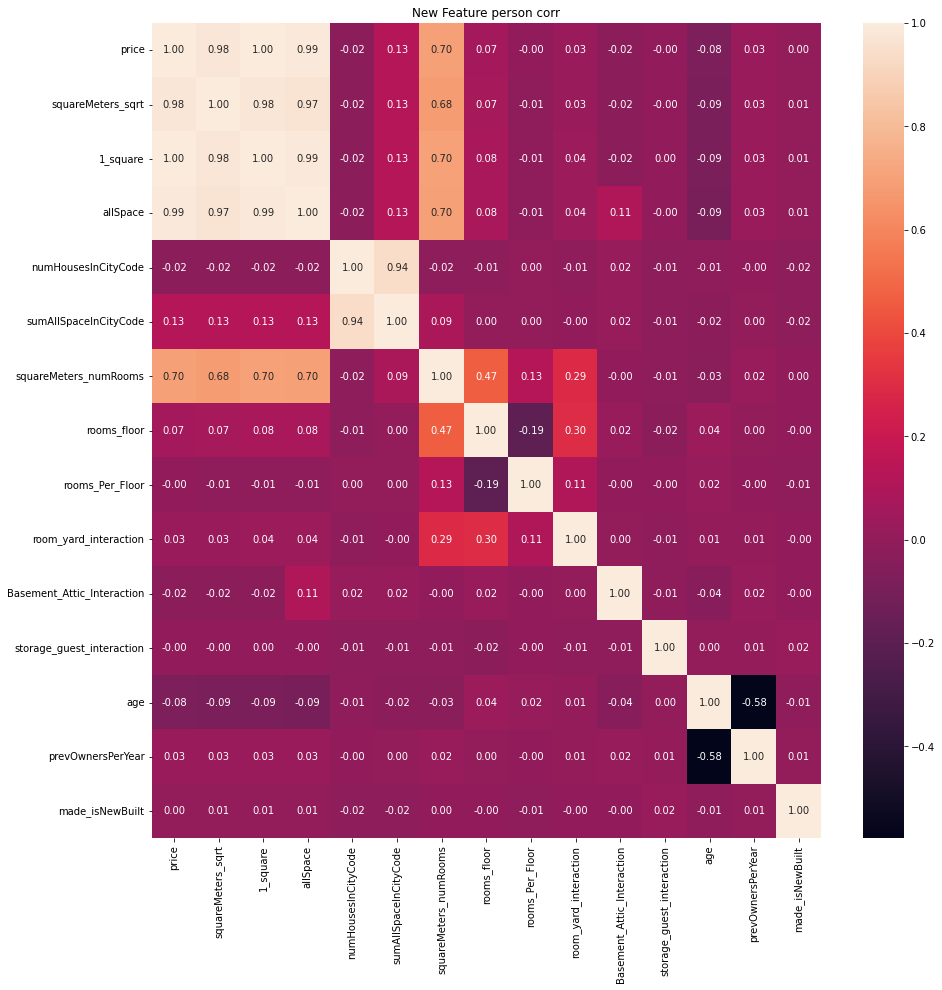

In [331]:
new_feat = ['price', 'squareMeters_sqrt', '1_square', 'allSpace',
       'numHousesInCityCode', 'sumAllSpaceInCityCode', 'squareMeters_numRooms',
       'rooms_floor', 'rooms_Per_Floor', 'room_yard_interaction',
       'Basement_Attic_Interaction', 'storage_guest_interaction', 'age',
       'prevOwnersPerYear', 'made_isNewBuilt']

plt.figure(figsize=(15,15))
sns.heatmap(all_data[new_feat].corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("New Feature person corr")
plt.show()

# 

## 피쳐 제거 ( 제외 )

- 상관관계에서 가격 예측 시 필요한 특성만 사용하도록 하자

In [332]:
# 앞 선 EDA결과와 상관관계에서 price 예측과 연관 없는 특성은 제거하자
feats_drop = ['cityCode','cityPartRange','squareMeters_sqrt', '1_square', 'allSpace',
       'numHousesInCityCode', 'sumAllSpaceInCityCode', 
       'rooms_Per_Floor', 'room_yard_interaction',
       'Basement_Attic_Interaction', 'storage_guest_interaction',
       'age', 'prevOwnersPerYear',
       'made_isNewBuilt']
all_data = all_data.drop(feats_drop, axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47884 entries, 0 to 47883
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   squareMeters           47884 non-null  int64  
 1   numberOfRooms          47884 non-null  int64  
 2   hasYard                47884 non-null  int64  
 3   hasPool                47884 non-null  int64  
 4   floors                 47884 non-null  int64  
 5   numPrevOwners          47884 non-null  int64  
 6   made                   47884 non-null  int64  
 7   isNewBuilt             47884 non-null  int64  
 8   hasStormProtector      47884 non-null  int64  
 9   basement               47884 non-null  int64  
 10  attic                  47884 non-null  int64  
 11  garage                 47884 non-null  int64  
 12  hasStorageRoom         47884 non-null  int64  
 13  hasGuestRoom           47884 non-null  int64  
 14  price                  32730 non-null  float64
 15  sq

In [333]:
all_data.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement',
       'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'price',
       'squareMeters_numRooms', 'rooms_floor'],
      dtype='object')

## 데이터 인코딩

In [334]:
all_data.nunique().sort_values()

hasStormProtector            2
hasYard                      2
hasPool                      2
isNewBuilt                   2
hasStorageRoom               2
numPrevOwners               10
hasGuestRoom                11
made                        32
numberOfRooms              100
floors                     100
garage                     903
rooms_floor               2865
attic                     6757
basement                  6856
squareMeters              9824
price                    10000
squareMeters_numRooms    39035
dtype: int64

In [335]:
to_be_encoded = [col for col in all_data.columns 
                      if all_data[col].nunique() <= 33 and all_data[col].nunique() > 2]
to_be_encoded

['numPrevOwners', 'made', 'hasGuestRoom']

In [336]:
from sklearn.preprocessing import OrdinalEncoder

ord = OrdinalEncoder()

all_data[to_be_encoded] = ord.fit_transform(all_data[to_be_encoded])
ord.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
        2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]

## 데이터 스케일링

In [337]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47884 entries, 0 to 47883
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   squareMeters           47884 non-null  int64  
 1   numberOfRooms          47884 non-null  int64  
 2   hasYard                47884 non-null  int64  
 3   hasPool                47884 non-null  int64  
 4   floors                 47884 non-null  int64  
 5   numPrevOwners          47884 non-null  float64
 6   made                   47884 non-null  float64
 7   isNewBuilt             47884 non-null  int64  
 8   hasStormProtector      47884 non-null  int64  
 9   basement               47884 non-null  int64  
 10  attic                  47884 non-null  int64  
 11  garage                 47884 non-null  int64  
 12  hasStorageRoom         47884 non-null  int64  
 13  hasGuestRoom           47884 non-null  float64
 14  price                  32730 non-null  float64
 15  sq

In [338]:
# float -> int 형 변환
float_feat = ['numPrevOwners', 'made', 'hasGuestRoom']
all_data[float_feat] = all_data[float_feat].astype(int)

In [339]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47884 entries, 0 to 47883
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   squareMeters           47884 non-null  int64  
 1   numberOfRooms          47884 non-null  int64  
 2   hasYard                47884 non-null  int64  
 3   hasPool                47884 non-null  int64  
 4   floors                 47884 non-null  int64  
 5   numPrevOwners          47884 non-null  int64  
 6   made                   47884 non-null  int64  
 7   isNewBuilt             47884 non-null  int64  
 8   hasStormProtector      47884 non-null  int64  
 9   basement               47884 non-null  int64  
 10  attic                  47884 non-null  int64  
 11  garage                 47884 non-null  int64  
 12  hasStorageRoom         47884 non-null  int64  
 13  hasGuestRoom           47884 non-null  int64  
 14  price                  32730 non-null  float64
 15  sq

In [340]:
from sklearn.preprocessing import QuantileTransformer

# price 제외하고 스케일링
num_features = ['squareMeters', 'numberOfRooms', 'floors', 'made', 'basement','attic', 'garage','squareMeters_numRooms','rooms_floor']

quantile = QuantileTransformer(output_distribution="normal")

all_data[num_features] = quantile.fit_transform(all_data[num_features])

In [341]:
all_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,squareMeters_numRooms,rooms_floor
0,0.772590,-2.107953,0,1,0.476619,7,-0.047692,0,1,-0.260738,1.317499,1.629992,0,7,7559081.5,-1.135340,-1.362078
1,0.948542,-0.196979,1,1,2.023292,5,0.814401,1,0,-0.465560,-0.711981,-1.593219,1,2,8085989.5,0.529279,0.781626
2,0.252393,0.309743,0,1,-0.857097,7,5.199338,0,0,-0.664983,1.222909,-1.517545,1,9,5574642.1,0.555702,-0.346817
3,-0.350564,-0.005018,0,0,-1.606755,3,0.478025,0,1,-1.640577,0.516197,-0.493553,0,3,3232561.2,-0.068461,-1.140077
4,0.627376,-0.875354,1,1,1.533612,6,-5.199338,1,0,1.006211,-0.713491,-0.708752,1,4,7055052.0,-0.152349,-0.021329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47879,1.179402,0.650274,1,1,0.723343,9,-1.733071,1,0,-0.448230,-0.340199,0.365531,1,1,NaN,1.490385,1.215747
47880,0.013622,-0.162552,1,1,0.509202,4,0.247134,0,0,-1.425011,0.673253,1.865852,0,0,NaN,0.090576,0.360172
47881,0.719562,0.130848,0,0,-0.130848,4,-0.138444,0,1,0.915434,-0.877196,0.705530,0,10,NaN,0.726943,0.165095
47882,0.841634,0.130848,0,1,-0.475214,2,1.554270,0,0,1.744448,1.948253,-1.517545,0,2,NaN,0.784508,-0.030683


# 데이터 나누기

In [342]:
# 정답의 결측 여부로 해결
X_sub = all_data[pd.isnull(all_data['price'])] # submisson용

# 훈련용
X = all_data[~pd.isnull(all_data['price'])] 
print(X.shape, X_sub.shape)
X.head() # Price 제거 필요

(32730, 17) (15154, 17)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,squareMeters_numRooms,rooms_floor
0,0.772590,-2.107953,0,1,0.476619,7,-0.047692,0,1,-0.260738,1.317499,1.629992,0,7,7559081.5,-1.135340,-1.362078
1,0.948542,-0.196979,1,1,2.023292,5,0.814401,1,0,-0.465560,-0.711981,-1.593219,1,2,8085989.5,0.529279,0.781626
2,0.252393,0.309743,0,1,-0.857097,7,5.199338,0,0,-0.664983,1.222909,-1.517545,1,9,5574642.1,0.555702,-0.346817
3,-0.350564,-0.005018,0,0,-1.606755,3,0.478025,0,1,-1.640577,0.516197,-0.493553,0,3,3232561.2,-0.068461,-1.140077
4,0.627376,-0.875354,1,1,1.533612,6,-5.199338,1,0,1.006211,-0.713491,-0.708752,1,4,7055052.0,-0.152349,-0.021329


In [343]:
y = X['price']
X = X.drop( ['price'], axis=1 )
X_sub = X_sub.drop( ['price'], axis=1 )

In [344]:
print(X.shape, X_sub.shape, y.shape)

(32730, 16) (15154, 16) (32730,)


In [345]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22911, 16), (9819, 16), (22911,), (9819,))

# 베이스 모델 학습 및 평가

In [346]:
from sklearn.linear_model import LinearRegression

# 모델 학습
lr_model = LinearRegression() # 선형회귀 
lr_model.fit(X_train,y_train)

LinearRegression()

In [347]:
# 테스트 데이터로 예측
y_pred = lr_model.predict(X_test) 
y_pred.shape

(9819,)

In [348]:
# 모델 평가 함수

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def show_reg_metric(true, preds):
  mae   = mean_absolute_error(true, preds)
  mse   = mean_squared_error(true, preds)
  rmse  = np.sqrt( mse )
  msle  = mean_squared_log_error(true, preds)
  rmsle = np.sqrt( msle )
  r2    = r2_score(true, preds)
  print('-'*30)
  print(f'mae \t {mae:.3f}' )
  print(f'mse \t {mse:.3f}' )
  print(f'rmse \t {rmse:.3f}' )
  print(f'msle \t {msle:.3f}' )
  print(f'rmsle \t {rmsle:.3f}' )
  print(f'r2 \t {r2:.3f}' )
  print('-'*30)

In [349]:
#show_reg_metric(y_test, y_pred)

In [350]:
# 테스트 데이터로 예측
lr_model.fit(X,y)
sub_y_pred = lr_model.predict(X_sub) 

submission['price'] = sub_y_pred
submission.to_csv('submission.csv', index=False) # 파일로 저장

# 모델 선정 및 비교

In [351]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def RMSE(y, y_pred):
    rmse =  np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train1, y_train1)
        pred = clf.predict(X_test1)
        rmse = RMSE(y_test1, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [352]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


logistic = LogisticRegression()
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elstic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor() 
cat = CatBoostRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

In [353]:
models = []
scores = []
for model in [dt, rf, gb, cat, xgb, lgbm]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


1 FOLDS: DecisionTreeRegressor RMSE: 237927.2273
2 FOLDS: DecisionTreeRegressor RMSE: 269512.5640
3 FOLDS: DecisionTreeRegressor RMSE: 210478.8262
4 FOLDS: DecisionTreeRegressor RMSE: 323368.1644
5 FOLDS: DecisionTreeRegressor RMSE: 198836.8043
6 FOLDS: DecisionTreeRegressor RMSE: 163086.2891
7 FOLDS: DecisionTreeRegressor RMSE: 246491.6138
8 FOLDS: DecisionTreeRegressor RMSE: 306894.5711
9 FOLDS: DecisionTreeRegressor RMSE: 275306.2378
10 FOLDS: DecisionTreeRegressor RMSE: 254101.6554

DecisionTreeRegressor mean RMSE: 248600.3953


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


1 FOLDS: RandomForestRegressor RMSE: 235956.7902
2 FOLDS: RandomForestRegressor RMSE: 212673.0252
3 FOLDS: RandomForestRegressor RMSE: 91419.7582
4 FOLDS: RandomForestRegressor RMSE: 260515.7918
5 FOLDS: RandomForestRegressor RMSE: 68945.9990
6 FOLDS: RandomForestRegressor RMSE: 79929.1578
7 FOLDS: RandomForestRegressor RMSE: 163489.3934
8 FOLDS: RandomForestRegressor RMSE: 65920.8363
9 FOLDS: RandomForestRegressor RMSE: 232959.4827
10 FOLDS: RandomForestRegressor RMSE: 160342.7433

RandomForestRegressor mean RMSE: 157215.2978


GradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


1 FOLDS: GradientBoostingRegressor RMSE: 236831.3825
2 FOLDS: GradientBoostingRegressor RMSE: 195392.5933
3 FOLDS: GradientBoostingRegressor RMSE: 97403.5266
4 FOLDS: GradientBoostingRegressor RMSE: 244952.1356
5 FOLDS: GradientBoostingRegressor RMSE: 57291.7708
6 FOLDS: GradientBoostingRegressor RMSE: 62647.2464
7 FOLDS: GradientBoostingRegressor RMSE: 129663.5463
8 FOLDS: GradientBoostingRegressor RMSE: 130474.0765
9 FOLDS: GradientBoostingRegressor RMSE: 224112.7058
10 FOLDS: GradientBoostingRegressor RMSE: 134379.1067

GradientBoostingRegressor mean RMSE: 151314.8090


CatBoostRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.046004
0:	learn: 2830273.7192492	total: 2.73ms	remaining: 2.73s
1:	learn: 2710330.2231549	total: 5.09ms	remaining: 2.54s
2:	learn: 2596833.7098661	total: 7.38ms	remaining: 2.45s
3:	learn: 2486144.3110033	total: 9.94ms	remaining: 2.48s
4:	learn: 2380557.7112243	total: 12.4ms	remaining: 2.48s
5:	learn: 2282544.5717723	total: 14.9ms	remaining: 2.46s
6:	learn: 2185565.5114320	total: 17.4ms	remaining: 2.46s
7:	learn: 2093107.5596563	total: 19.8ms	remaining: 2.46s
8:	learn: 2008046.8219938	total: 22.3ms	remaining: 2.46s
9:	learn: 1925567.3116851	total: 24.9ms	remaining: 2.47s
10:	learn: 1843540.8012701	total: 27.5ms	remaining: 2.47s
11:	learn: 1773743.7987103	total: 30ms	remaining: 2.47s
12:	learn: 1699886.4777242	total: 32.5ms	remaining: 2.47s
13:	learn: 1631306.6626563	total: 36.1ms	remaining: 2.54s
14:	learn: 1566155.7129473	total: 39.3ms	remaining: 2.58s
15:	learn: 1502494.7246476	total: 41.9ms	remaining: 2.58s
16:	learn: 1441920.1540508	total: 44.4ms	remaining: 2.

CatBoostRegressor Cross Validations...:  10%|█         | 1/10 [00:05<00:53,  5.90s/it]

992:	learn: 21441.5247448	total: 5.21s	remaining: 36.8ms
993:	learn: 21426.1986671	total: 5.22s	remaining: 31.5ms
994:	learn: 21410.2803065	total: 5.23s	remaining: 26.3ms
995:	learn: 21394.2656531	total: 5.23s	remaining: 21ms
996:	learn: 21361.8844680	total: 5.23s	remaining: 15.7ms
997:	learn: 21330.3579969	total: 5.24s	remaining: 10.5ms
998:	learn: 21311.0455548	total: 5.24s	remaining: 5.24ms
999:	learn: 21294.9030141	total: 5.24s	remaining: 0us
Learning rate set to 0.051311
0:	learn: 2783808.9275508	total: 3.23ms	remaining: 3.23s
1:	learn: 2652072.6368685	total: 5.88ms	remaining: 2.94s
2:	learn: 2526060.6270260	total: 8.62ms	remaining: 2.87s
3:	learn: 2404485.0716295	total: 11.2ms	remaining: 2.79s
4:	learn: 2290404.4837433	total: 14.1ms	remaining: 2.81s
5:	learn: 2184677.1154534	total: 17.1ms	remaining: 2.83s
6:	learn: 2081413.1729472	total: 20ms	remaining: 2.84s
7:	learn: 1979932.7009052	total: 22.7ms	remaining: 2.81s
8:	learn: 1887726.7066657	total: 25.6ms	remaining: 2.82s
9:	learn

CatBoostRegressor Cross Validations...:  20%|██        | 2/10 [00:09<00:35,  4.44s/it]

961:	learn: 39108.6204147	total: 3.01s	remaining: 119ms
962:	learn: 39099.2852451	total: 3.01s	remaining: 116ms
963:	learn: 39057.9273025	total: 3.01s	remaining: 113ms
964:	learn: 39050.0095423	total: 3.02s	remaining: 109ms
965:	learn: 39033.9452053	total: 3.02s	remaining: 106ms
966:	learn: 38980.4387481	total: 3.02s	remaining: 103ms
967:	learn: 38932.7731986	total: 3.03s	remaining: 100ms
968:	learn: 38911.5568886	total: 3.03s	remaining: 96.9ms
969:	learn: 38888.3744892	total: 3.03s	remaining: 93.8ms
970:	learn: 38873.5084303	total: 3.04s	remaining: 90.7ms
971:	learn: 38868.1590510	total: 3.04s	remaining: 87.5ms
972:	learn: 38859.7590496	total: 3.04s	remaining: 84.4ms
973:	learn: 38819.2436154	total: 3.04s	remaining: 81.3ms
974:	learn: 38680.1062826	total: 3.05s	remaining: 78.1ms
975:	learn: 38658.2854243	total: 3.05s	remaining: 75ms
976:	learn: 38643.9872880	total: 3.05s	remaining: 71.9ms
977:	learn: 38602.7496998	total: 3.06s	remaining: 68.7ms
978:	learn: 38580.2895681	total: 3.06s	r

CatBoostRegressor Cross Validations...:  30%|███       | 3/10 [00:13<00:28,  4.11s/it]

973:	learn: 43203.8678488	total: 3.3s	remaining: 88.1ms
974:	learn: 43178.0934082	total: 3.31s	remaining: 84.9ms
975:	learn: 43159.9044354	total: 3.31s	remaining: 81.5ms
976:	learn: 43125.6447710	total: 3.32s	remaining: 78.1ms
977:	learn: 43113.1584099	total: 3.32s	remaining: 74.7ms
978:	learn: 42979.3305144	total: 3.32s	remaining: 71.3ms
979:	learn: 42953.6568241	total: 3.33s	remaining: 67.9ms
980:	learn: 42941.6162821	total: 3.33s	remaining: 64.5ms
981:	learn: 42910.1713522	total: 3.33s	remaining: 61.1ms
982:	learn: 42889.8814371	total: 3.34s	remaining: 57.7ms
983:	learn: 42862.2246267	total: 3.34s	remaining: 54.3ms
984:	learn: 42811.2798768	total: 3.34s	remaining: 50.9ms
985:	learn: 42800.9033179	total: 3.35s	remaining: 47.5ms
986:	learn: 42787.4186490	total: 3.35s	remaining: 44.1ms
987:	learn: 42774.7986117	total: 3.35s	remaining: 40.7ms
988:	learn: 42752.0240850	total: 3.35s	remaining: 37.3ms
989:	learn: 42696.8137446	total: 3.36s	remaining: 33.9ms
990:	learn: 42684.6186939	total:

CatBoostRegressor Cross Validations...:  40%|████      | 4/10 [00:18<00:28,  4.82s/it]

990:	learn: 43363.0760229	total: 5.3s	remaining: 48.2ms
991:	learn: 43343.3792028	total: 5.31s	remaining: 42.9ms
992:	learn: 43335.5806461	total: 5.32s	remaining: 37.5ms
993:	learn: 43313.3167862	total: 5.33s	remaining: 32.2ms
994:	learn: 43288.3120030	total: 5.35s	remaining: 26.9ms
995:	learn: 43263.9722120	total: 5.36s	remaining: 21.5ms
996:	learn: 43240.3324192	total: 5.37s	remaining: 16.2ms
997:	learn: 43200.5012096	total: 5.38s	remaining: 10.8ms
998:	learn: 43181.2554432	total: 5.38s	remaining: 5.39ms
999:	learn: 43156.9159185	total: 5.39s	remaining: 0us
Learning rate set to 0.059292
0:	learn: 2760185.9574791	total: 14.8ms	remaining: 14.8s
1:	learn: 2606551.5512715	total: 27.5ms	remaining: 13.7s
2:	learn: 2462535.0811769	total: 41.5ms	remaining: 13.8s
3:	learn: 2325355.3738251	total: 54ms	remaining: 13.5s
4:	learn: 2196662.3919361	total: 65.5ms	remaining: 13s
5:	learn: 2074728.5099202	total: 77.1ms	remaining: 12.8s
6:	learn: 1960556.3055347	total: 84.7ms	remaining: 12s
7:	learn: 1

CatBoostRegressor Cross Validations...:  50%|█████     | 5/10 [00:24<00:25,  5.01s/it]

Learning rate set to 0.061023
0:	learn: 2756605.3598945	total: 6.16ms	remaining: 6.15s
1:	learn: 2598381.9155848	total: 10.2ms	remaining: 5.11s
2:	learn: 2445929.7885466	total: 14.4ms	remaining: 4.77s
3:	learn: 2305435.9436008	total: 18.4ms	remaining: 4.58s
4:	learn: 2171465.5099078	total: 22.7ms	remaining: 4.51s
5:	learn: 2047018.8818066	total: 26.8ms	remaining: 4.45s
6:	learn: 1930428.6856463	total: 33.4ms	remaining: 4.74s
7:	learn: 1818068.3811399	total: 37.7ms	remaining: 4.68s
8:	learn: 1717229.1797609	total: 42.2ms	remaining: 4.65s
9:	learn: 1619442.1348958	total: 46.9ms	remaining: 4.64s
10:	learn: 1527964.4231533	total: 51.3ms	remaining: 4.61s
11:	learn: 1443864.7995201	total: 55.4ms	remaining: 4.56s
12:	learn: 1362026.9291323	total: 59.5ms	remaining: 4.51s
13:	learn: 1284029.0548680	total: 63.9ms	remaining: 4.5s
14:	learn: 1210611.5437282	total: 68.4ms	remaining: 4.49s
15:	learn: 1142377.5739056	total: 72.8ms	remaining: 4.48s
16:	learn: 1078608.2010644	total: 79.3ms	remaining: 4

CatBoostRegressor Cross Validations...:  60%|██████    | 6/10 [00:29<00:19,  4.94s/it]

963:	learn: 54229.1846894	total: 4.34s	remaining: 162ms
964:	learn: 54076.1414432	total: 4.35s	remaining: 158ms
965:	learn: 54016.1577058	total: 4.35s	remaining: 153ms
966:	learn: 54002.4189967	total: 4.36s	remaining: 149ms
967:	learn: 53978.3224556	total: 4.36s	remaining: 144ms
968:	learn: 53933.7019064	total: 4.36s	remaining: 140ms
969:	learn: 53907.4733777	total: 4.37s	remaining: 135ms
970:	learn: 53897.2927287	total: 4.37s	remaining: 131ms
971:	learn: 53880.5009516	total: 4.38s	remaining: 126ms
972:	learn: 53862.5186388	total: 4.38s	remaining: 122ms
973:	learn: 53797.0094776	total: 4.38s	remaining: 117ms
974:	learn: 53787.4209009	total: 4.39s	remaining: 113ms
975:	learn: 53744.9514296	total: 4.39s	remaining: 108ms
976:	learn: 53690.9967596	total: 4.4s	remaining: 104ms
977:	learn: 53681.4895500	total: 4.4s	remaining: 99ms
978:	learn: 53672.2180049	total: 4.41s	remaining: 94.5ms
979:	learn: 53647.7359089	total: 4.41s	remaining: 90ms
980:	learn: 53638.8702166	total: 4.41s	remaining: 8

CatBoostRegressor Cross Validations...:  70%|███████   | 7/10 [00:37<00:18,  6.02s/it]

978:	learn: 52716.5750917	total: 7.52s	remaining: 161ms
979:	learn: 52704.9659891	total: 7.53s	remaining: 154ms
980:	learn: 52556.0462362	total: 7.53s	remaining: 146ms
981:	learn: 52532.0705726	total: 7.54s	remaining: 138ms
982:	learn: 52459.4225161	total: 7.54s	remaining: 130ms
983:	learn: 52446.3542823	total: 7.55s	remaining: 123ms
984:	learn: 52437.2593261	total: 7.55s	remaining: 115ms
985:	learn: 52424.7964183	total: 7.55s	remaining: 107ms
986:	learn: 52296.4134801	total: 7.56s	remaining: 99.6ms
987:	learn: 52149.1145020	total: 7.56s	remaining: 91.9ms
988:	learn: 52126.1794777	total: 7.57s	remaining: 84.2ms
989:	learn: 52117.8133733	total: 7.57s	remaining: 76.5ms
990:	learn: 51988.2545680	total: 7.58s	remaining: 68.8ms
991:	learn: 51975.9842297	total: 7.58s	remaining: 61.1ms
992:	learn: 51968.0138735	total: 7.58s	remaining: 53.5ms
993:	learn: 51933.1879009	total: 7.59s	remaining: 45.8ms
994:	learn: 51920.6607120	total: 7.59s	remaining: 38.2ms
995:	learn: 51845.3288620	total: 7.6s	r

CatBoostRegressor Cross Validations...:  80%|████████  | 8/10 [00:42<00:11,  5.84s/it]

980:	learn: 52696.4053519	total: 5.03s	remaining: 97.5ms
981:	learn: 52619.8953744	total: 5.04s	remaining: 92.4ms
982:	learn: 52582.4055941	total: 5.04s	remaining: 87.3ms
983:	learn: 52508.2641684	total: 5.05s	remaining: 82.1ms
984:	learn: 52430.0604934	total: 5.05s	remaining: 77ms
985:	learn: 52359.8912823	total: 5.06s	remaining: 71.8ms
986:	learn: 52155.8659551	total: 5.06s	remaining: 66.7ms
987:	learn: 52149.0522129	total: 5.07s	remaining: 61.6ms
988:	learn: 52139.2357220	total: 5.07s	remaining: 56.4ms
989:	learn: 52048.7737064	total: 5.08s	remaining: 51.3ms
990:	learn: 51980.4285843	total: 5.08s	remaining: 46.2ms
991:	learn: 51954.5911437	total: 5.09s	remaining: 41ms
992:	learn: 51942.2508365	total: 5.09s	remaining: 35.9ms
993:	learn: 51891.8127162	total: 5.1s	remaining: 30.8ms
994:	learn: 51861.4325073	total: 5.1s	remaining: 25.6ms
995:	learn: 51850.4042060	total: 5.11s	remaining: 20.5ms
996:	learn: 51749.7075209	total: 5.11s	remaining: 15.4ms
997:	learn: 51664.5602713	total: 5.12

CatBoostRegressor Cross Validations...:  90%|█████████ | 9/10 [00:51<00:06,  6.80s/it]

991:	learn: 55408.8528561	total: 8.3s	remaining: 66.9ms
992:	learn: 55375.8281849	total: 8.31s	remaining: 58.6ms
993:	learn: 55317.0271919	total: 8.31s	remaining: 50.2ms
994:	learn: 55296.0853885	total: 8.32s	remaining: 41.8ms
995:	learn: 55151.1644588	total: 8.32s	remaining: 33.4ms
996:	learn: 55091.8958044	total: 8.33s	remaining: 25.1ms
997:	learn: 55080.3000997	total: 8.33s	remaining: 16.7ms
998:	learn: 54864.2327348	total: 8.34s	remaining: 8.35ms
999:	learn: 54852.7959039	total: 8.34s	remaining: 0us
Learning rate set to 0.06615
0:	learn: 2736191.7043106	total: 6.18ms	remaining: 6.18s
1:	learn: 2563299.5448267	total: 11.6ms	remaining: 5.79s
2:	learn: 2402902.3288698	total: 17ms	remaining: 5.63s
3:	learn: 2255065.0316739	total: 22.2ms	remaining: 5.52s
4:	learn: 2112735.4728216	total: 27.7ms	remaining: 5.51s
5:	learn: 1984603.5305331	total: 32.7ms	remaining: 5.42s
6:	learn: 1862342.4311563	total: 38.4ms	remaining: 5.44s
7:	learn: 1744632.7038531	total: 44ms	remaining: 5.46s
8:	learn: 

CatBoostRegressor Cross Validations...: 100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


998:	learn: 62953.7935561	total: 5.71s	remaining: 5.72ms
999:	learn: 62926.5473708	total: 5.72s	remaining: 0us
1 FOLDS: CatBoostRegressor RMSE: 239638.4735
2 FOLDS: CatBoostRegressor RMSE: 164985.7454
3 FOLDS: CatBoostRegressor RMSE: 60853.7214
4 FOLDS: CatBoostRegressor RMSE: 240770.9316
5 FOLDS: CatBoostRegressor RMSE: 64341.5520
6 FOLDS: CatBoostRegressor RMSE: 75965.7134
7 FOLDS: CatBoostRegressor RMSE: 174347.3370
8 FOLDS: CatBoostRegressor RMSE: 160934.6179
9 FOLDS: CatBoostRegressor RMSE: 248343.2127
10 FOLDS: CatBoostRegressor RMSE: 139544.0484

CatBoostRegressor mean RMSE: 156972.5353


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


1 FOLDS: XGBRegressor RMSE: 236755.6085
2 FOLDS: XGBRegressor RMSE: 234013.6868
3 FOLDS: XGBRegressor RMSE: 104958.0584
4 FOLDS: XGBRegressor RMSE: 265591.2309
5 FOLDS: XGBRegressor RMSE: 61766.9746
6 FOLDS: XGBRegressor RMSE: 106367.1836
7 FOLDS: XGBRegressor RMSE: 136328.8466
8 FOLDS: XGBRegressor RMSE: 60217.5959
9 FOLDS: XGBRegressor RMSE: 224414.9142
10 FOLDS: XGBRegressor RMSE: 181271.3123

XGBRegressor mean RMSE: 161168.5412


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

1 FOLDS: LGBMRegressor RMSE: 236049.4069
2 FOLDS: LGBMRegressor RMSE: 158499.1125
3 FOLDS: LGBMRegressor RMSE: 57368.7607
4 FOLDS: LGBMRegressor RMSE: 240466.6589
5 FOLDS: LGBMRegressor RMSE: 66090.4765
6 FOLDS: LGBMRegressor RMSE: 46251.9417
7 FOLDS: LGBMRegressor RMSE: 161849.7708
8 FOLDS: LGBMRegressor RMSE: 132060.3873
9 FOLDS: LGBMRegressor RMSE: 226187.1398
10 FOLDS: LGBMRegressor RMSE: 125869.5266

LGBMRegressor mean RMSE: 145069.3182


In [354]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,DecisionTreeRegressor,248600.395343
1,RandomForestRegressor,157215.297787
2,GradientBoostingRegressor,151314.809041
3,CatBoostRegressor,156972.535331
4,XGBRegressor,161168.541186
5,LGBMRegressor,145069.318163


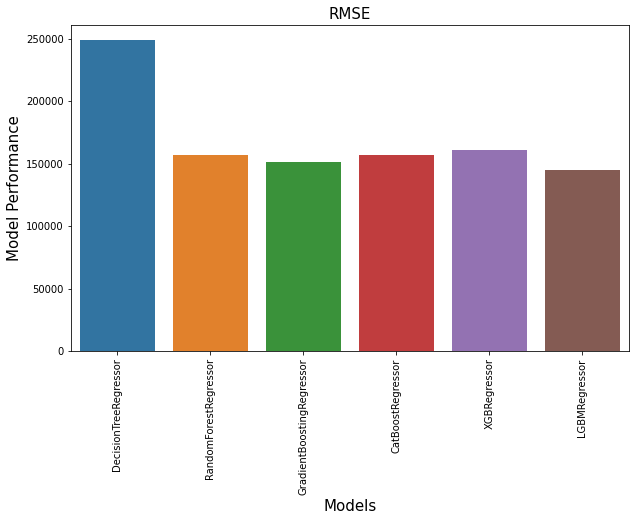

In [355]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.title('RMSE', fontsize=15)
plt.show()

## XGB + Optuna

- Discussions 이나 bestScore 확인 시, XGBRegressor 사용 시 가장 성능이 좋게 나오는 것을 알 수 있다
- [공식문서](https://xgboost.readthedocs.io/en/stable/parameter.html)
- [XGBoost 개념 이해](https://wooono.tistory.com/97)
- [XGBoost 주요 파라미터](https://zzinnam.tistory.com/entry/XGboost-%EC%A3%BC%EC%9A%94-%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC)
- [XGBoost와 LightGBM 하이퍼파라미터 튜닝 가이드](https://psystat.tistory.com/131)

In [356]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [357]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [358]:
sampler = TPESampler(seed=10)

def objectiveXGB(trial):

  param = {
  'objective' :'reg:linear', 
  'booster' :'gbtree',
  'metric': 'rmse',
  #'max_depth' : 3, 
  #'learning_rate' : 0.24 ,
  'max_depth':trial.suggest_int('max_depth',3,10),  
  'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
  'n_estimators':trial.suggest_int('n_estimators', 100, 10000),
  #'subsample':trial.suggest_float('subsample',0.5, 1),
  #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
  #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
  #'lambda': trial.suggest_float('lambda', 0.001, 1.0),
  #'alpha': trial.suggest_float('alpha', 0.001, 1.0),
  #'random_state': 42
  }
  model = XGBRegressor(**param)
  model.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=50)
  pred = model.predict(X_test)
  return RMSE(y_test, pred)


In [359]:
# RMSE가 최소가 되는 방향으로 학습을 진행
studyXGB = optuna.create_study(direction='minimize',  sampler=sampler)

# n_trials 지정
studyXGB.optimize(objectiveXGB, n_trials=100)

[I 2023-02-17 11:01:45,662] A new study created in memory with name: no-name-d76f315c-7429-46c1-bc74-13553a4855da
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11:01:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:45] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:5477595.26255
[1]	validation_0-rmse:5390007.70720
[2]	validation_0-rmse:5303838.37968
[3]	validation_0-rmse:5219043.18834
[4]	validation_0-rmse:5135602.76779
[5]	validation_0-rmse:5053534.94323
[6]	validation_0-rmse:4972754.29529
[7]	validation_0-rmse:4893244.66865
[8]	validation_0-rmse:4815078.73426
[9]	validation_0-rmse:4738151.99711
[10]	validation_0-rmse:4662427.31935
[11]	validation_0-rmse:4587954.51057
[12]	validation_0-rmse:4514682.75964
[13]	validation_0-rmse:4442554.99271
[14]	validation_0-rmse:4371563.91201
[15]	validation_0-rmse:4301741.75668
[16]	validation_0-rmse:4233043.78932
[17]	validation_0-rmse:4165428.48813
[18]	validation_0-rmse:4098868.92286
[19]	validation_0-rmse:4033360.92169
[20]	validation_0-rmse:3968955.43983
[21]	validation_0-rmse:3905569

[I 2023-02-17 11:03:04,367] Trial 0 finished with value: 137113.38052517528 and parameters: {'max_depth': 9, 'learning_rate': 0.016018065314226435, 'n_estimators': 6373}. Best is trial 0 with value: 137113.38052517528.


[11:03:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:04] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4707751.67109
[1]	validation_0-rmse:3982183.43052
[2]	validation_0-rmse:3368534.57588


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:2849674.08233
[4]	validation_0-rmse:2411297.26877
[5]	validation_0-rmse:2040464.08002
[6]	validation_0-rmse:1727105.02642
[7]	validation_0-rmse:1462477.46076
[8]	validation_0-rmse:1239012.64900
[9]	validation_0-rmse:1050915.23402
[10]	validation_0-rmse:891905.78170
[11]	validation_0-rmse:758155.02419
[12]	validation_0-rmse:645756.64617
[13]	validation_0-rmse:551384.09567
[14]	validation_0-rmse:472641.60161
[15]	validation_0-rmse:406964.84871
[16]	validation_0-rmse:352632.26273
[17]	validation_0-rmse:308498.72865
[18]	validation_0-rmse:270181.74997
[19]	validation_0-rmse:240873.22262
[20]	validation_0-rmse:216678.95482
[21]	validation_0-rmse:196397.77131
[22]	validation_0-rmse:182149.90156
[23]	validation_0-rmse:171257.68333
[24]	validation_0-rmse:163279.44778
[25]	validation_0-rmse:155759.10023
[26]	validation_0-rmse:150091.28957
[27]	validation_0-rmse:145974.96165
[28]	validation_0-rmse:143642.75309
[29]	validation_0-rmse:140891.96893
[30]	validation_0-rmse:13878

[I 2023-02-17 11:03:13,936] Trial 1 finished with value: 133415.72654756493 and parameters: {'max_depth': 8, 'learning_rate': 0.15456703356775123, 'n_estimators': 2325}. Best is trial 1 with value: 133415.72654756493.


[11:03:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:13] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4286527.79286
[1]	validation_0-rmse:3301638.16182
[2]	validation_0-rmse:2543796.99754
[3]	validation_0-rmse:1961203.81690
[4]	validation_0-rmse:1513111.57358


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1169346.55449
[6]	validation_0-rmse:905026.72878
[7]	validation_0-rmse:703521.49020
[8]	validation_0-rmse:550652.52143
[9]	validation_0-rmse:435370.46509
[10]	validation_0-rmse:349629.48989
[11]	validation_0-rmse:286963.12868
[12]	validation_0-rmse:242392.98399
[13]	validation_0-rmse:211645.99030
[14]	validation_0-rmse:191263.83236
[15]	validation_0-rmse:178027.00826
[16]	validation_0-rmse:163280.83692
[17]	validation_0-rmse:157886.28360
[18]	validation_0-rmse:154642.21171
[19]	validation_0-rmse:152702.23416
[20]	validation_0-rmse:146832.43060
[21]	validation_0-rmse:146235.82399
[22]	validation_0-rmse:145817.51910
[23]	validation_0-rmse:145920.96163
[24]	validation_0-rmse:143652.02495
[25]	validation_0-rmse:143518.93088
[26]	validation_0-rmse:143501.36560
[27]	validation_0-rmse:143431.81663
[28]	validation_0-rmse:143396.89797
[29]	validation_0-rmse:136241.86330
[30]	validation_0-rmse:136167.35440
[31]	validation_0-rmse:136101.61823
[32]	validation_0-rmse:136069.78

[I 2023-02-17 11:03:17,737] Trial 2 finished with value: 129838.4202364764 and parameters: {'max_depth': 4, 'learning_rate': 0.23055390653769803, 'n_estimators': 1774}. Best is trial 2 with value: 129838.4202364764.


[11:03:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:17] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4410819.24131
[1]	validation_0-rmse:3496464.61645
[2]	validation_0-rmse:2771246.27678
[3]	validation_0-rmse:2198585.91353
[4]	validation_0-rmse:1745314.15780
[5]	validation_0-rmse:1387120.01040


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:1103569.91731
[7]	validation_0-rmse:880880.66814
[8]	validation_0-rmse:705766.26329
[9]	validation_0-rmse:567258.93877
[10]	validation_0-rmse:460144.12191
[11]	validation_0-rmse:377774.81832
[12]	validation_0-rmse:315349.73565
[13]	validation_0-rmse:268879.54783
[14]	validation_0-rmse:234863.46319
[15]	validation_0-rmse:210826.55810
[16]	validation_0-rmse:194132.48784
[17]	validation_0-rmse:182937.73818
[18]	validation_0-rmse:175512.40602
[19]	validation_0-rmse:170725.45671
[20]	validation_0-rmse:161347.12565
[21]	validation_0-rmse:159200.18617
[22]	validation_0-rmse:157995.61972
[23]	validation_0-rmse:157085.20282
[24]	validation_0-rmse:156529.87583
[25]	validation_0-rmse:155988.57123
[26]	validation_0-rmse:155606.65176
[27]	validation_0-rmse:155299.51192
[28]	validation_0-rmse:155078.81121
[29]	validation_0-rmse:154883.49551
[30]	validation_0-rmse:154747.72640
[31]	validation_0-rmse:154732.40170
[32]	validation_0-rmse:154670.37295
[33]	validation_0-rmse:154483.6

[I 2023-02-17 11:03:27,747] Trial 3 finished with value: 134666.92691813744 and parameters: {'max_depth': 3, 'learning_rate': 0.2087543473266612, 'n_estimators': 9539}. Best is trial 2 with value: 129838.4202364764.


[11:03:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:27] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4688695.16767
[1]	validation_0-rmse:3950417.22320
[2]	validation_0-rmse:3327699.44686
[3]	validation_0-rmse:2803975.67140
[4]	validation_0-rmse:2363063.92560
[5]	validation_0-rmse:1992346.64213


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:1680329.87332
[7]	validation_0-rmse:1418216.17898
[8]	validation_0-rmse:1198175.42195
[9]	validation_0-rmse:1013507.02265
[10]	validation_0-rmse:858823.11439
[11]	validation_0-rmse:729452.82590
[12]	validation_0-rmse:620949.10432
[13]	validation_0-rmse:529221.21464
[14]	validation_0-rmse:454220.44030
[15]	validation_0-rmse:392500.37789
[16]	validation_0-rmse:341921.71763
[17]	validation_0-rmse:300984.59617
[18]	validation_0-rmse:268163.46828
[19]	validation_0-rmse:242203.17999
[20]	validation_0-rmse:221916.55662
[21]	validation_0-rmse:206285.68320
[22]	validation_0-rmse:194447.17984
[23]	validation_0-rmse:185610.79725
[24]	validation_0-rmse:179032.21549
[25]	validation_0-rmse:174239.25504
[26]	validation_0-rmse:170734.33938
[27]	validation_0-rmse:168204.77985
[28]	validation_0-rmse:166389.95481
[29]	validation_0-rmse:165112.09336
[30]	validation_0-rmse:164190.29725
[31]	validation_0-rmse:163554.06383
[32]	validation_0-rmse:163088.11309
[33]	validation_0-rmse:16264

[I 2023-02-17 11:03:30,515] Trial 4 finished with value: 150462.25200492117 and parameters: {'max_depth': 3, 'learning_rate': 0.15853575638187523, 'n_estimators': 8145}. Best is trial 2 with value: 129838.4202364764.


[11:03:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:30] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4348096.52323
[1]	validation_0-rmse:3397842.19259
[2]	validation_0-rmse:2655633.55833


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:2076307.45892
[4]	validation_0-rmse:1623875.05959
[5]	validation_0-rmse:1271486.29562
[6]	validation_0-rmse:996245.43609
[7]	validation_0-rmse:782945.81072
[8]	validation_0-rmse:616594.01084
[9]	validation_0-rmse:488750.58611
[10]	validation_0-rmse:389564.13157
[11]	validation_0-rmse:315106.00213
[12]	validation_0-rmse:259094.38524
[13]	validation_0-rmse:218348.71233
[14]	validation_0-rmse:188363.95199
[15]	validation_0-rmse:167933.32916
[16]	validation_0-rmse:153205.24320
[17]	validation_0-rmse:144075.51733
[18]	validation_0-rmse:138024.43570
[19]	validation_0-rmse:133859.40045
[20]	validation_0-rmse:131361.88396
[21]	validation_0-rmse:129724.09375
[22]	validation_0-rmse:128730.06198
[23]	validation_0-rmse:128508.24177
[24]	validation_0-rmse:128040.56267
[25]	validation_0-rmse:127841.77549
[26]	validation_0-rmse:127736.82338
[27]	validation_0-rmse:127762.21762
[28]	validation_0-rmse:127497.14357
[29]	validation_0-rmse:127342.89707
[30]	validation_0-rmse:127289.31

[I 2023-02-17 11:03:34,571] Trial 5 finished with value: 127208.69166706642 and parameters: {'max_depth': 7, 'learning_rate': 0.21930904205522186, 'n_estimators': 2989}. Best is trial 5 with value: 127208.69166706642.


[11:03:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4359661.85220
[1]	validation_0-rmse:3415905.30714
[2]	validation_0-rmse:2676782.63213


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:2098305.84356
[4]	validation_0-rmse:1645401.58433
[5]	validation_0-rmse:1291650.99516
[6]	validation_0-rmse:1014515.63214
[7]	validation_0-rmse:799140.19871
[8]	validation_0-rmse:631726.26537
[9]	validation_0-rmse:502358.79026
[10]	validation_0-rmse:402763.06360
[11]	validation_0-rmse:324797.53397
[12]	validation_0-rmse:266042.66786
[13]	validation_0-rmse:222345.57985
[14]	validation_0-rmse:191565.03447
[15]	validation_0-rmse:169179.04699
[16]	validation_0-rmse:154667.13942
[17]	validation_0-rmse:144452.07750
[18]	validation_0-rmse:138043.31684
[19]	validation_0-rmse:133934.33084
[20]	validation_0-rmse:131543.56141
[21]	validation_0-rmse:129777.73007
[22]	validation_0-rmse:128740.71437
[23]	validation_0-rmse:128330.29561
[24]	validation_0-rmse:127942.74101
[25]	validation_0-rmse:127954.80169
[26]	validation_0-rmse:127804.78505
[27]	validation_0-rmse:127850.69215
[28]	validation_0-rmse:127633.63424
[29]	validation_0-rmse:127508.27422
[30]	validation_0-rmse:127480.9

[I 2023-02-17 11:03:43,375] Trial 6 finished with value: 127480.97179159374 and parameters: {'max_depth': 10, 'learning_rate': 0.21722697718533027, 'n_estimators': 5471}. Best is trial 5 with value: 127208.69166706642.


[11:03:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:43] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4909851.98291
[1]	validation_0-rmse:4330755.82593
[2]	validation_0-rmse:3820219.19414
[3]	validation_0-rmse:3370098.33786
[4]	validation_0-rmse:2973068.84283


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:2623256.24243
[6]	validation_0-rmse:2314671.13157
[7]	validation_0-rmse:2042813.33583
[8]	validation_0-rmse:1803103.35881
[9]	validation_0-rmse:1592032.57309
[10]	validation_0-rmse:1406005.44520
[11]	validation_0-rmse:1242401.72857
[12]	validation_0-rmse:1098296.95595
[13]	validation_0-rmse:971649.61146
[14]	validation_0-rmse:860457.25118
[15]	validation_0-rmse:762762.20791
[16]	validation_0-rmse:677095.55554
[17]	validation_0-rmse:602132.90524
[18]	validation_0-rmse:536663.13771
[19]	validation_0-rmse:479593.51170
[20]	validation_0-rmse:430054.46500
[21]	validation_0-rmse:387119.23239
[22]	validation_0-rmse:350131.27698
[23]	validation_0-rmse:318466.17689
[24]	validation_0-rmse:291463.59899
[25]	validation_0-rmse:268640.68900
[26]	validation_0-rmse:249479.50613
[27]	validation_0-rmse:233487.35600
[28]	validation_0-rmse:220271.91064
[29]	validation_0-rmse:209391.74450
[30]	validation_0-rmse:200537.44635
[31]	validation_0-rmse:193410.66856
[32]	validation_0-rmse:18

[I 2023-02-17 11:03:48,988] Trial 7 finished with value: 132806.17340747188 and parameters: {'max_depth': 4, 'learning_rate': 0.11826882041492606, 'n_estimators': 6774}. Best is trial 5 with value: 127208.69166706642.


[11:03:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4811649.15343
[1]	validation_0-rmse:4159744.90938


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:3595987.20728
[3]	validation_0-rmse:3109021.09542
[4]	validation_0-rmse:2688376.21664
[5]	validation_0-rmse:2324750.88657
[6]	validation_0-rmse:2010644.55475
[7]	validation_0-rmse:1739300.08193
[8]	validation_0-rmse:1505181.21319
[9]	validation_0-rmse:1302897.93486
[10]	validation_0-rmse:1128553.62031
[11]	validation_0-rmse:978128.82147
[12]	validation_0-rmse:848563.08253
[13]	validation_0-rmse:737044.55391
[14]	validation_0-rmse:641239.91224
[15]	validation_0-rmse:559029.17977
[16]	validation_0-rmse:488634.54069
[17]	validation_0-rmse:428674.82193
[18]	validation_0-rmse:377792.73160
[19]	validation_0-rmse:333407.52935
[20]	validation_0-rmse:297122.30198
[21]	validation_0-rmse:266774.52976
[22]	validation_0-rmse:241625.58380
[23]	validation_0-rmse:219640.79644
[24]	validation_0-rmse:202848.46655
[25]	validation_0-rmse:189426.02116
[26]	validation_0-rmse:178720.81871
[27]	validation_0-rmse:169615.98084
[28]	validation_0-rmse:161815.88866
[29]	validation_0-rmse:1566

[I 2023-02-17 11:03:57,468] Trial 8 finished with value: 133506.10090801565 and parameters: {'max_depth': 6, 'learning_rate': 0.13586405806665516, 'n_estimators': 6216}. Best is trial 5 with value: 127208.69166706642.


[11:03:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.



/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-rmse:4463048.00307
[1]	validation_0-rmse:3579769.95464
[2]	validation_0-rmse:2871411.10575
[3]	validation_0-rmse:2303893.84260
[4]	validation_0-rmse:1849191.45608
[5]	validation_0-rmse:1484910.98330
[6]	validation_0-rmse:1192939.10492
[7]	validation_0-rmse:960046.39544
[8]	validation_0-rmse:774096.28004
[9]	validation_0-rmse:626331.05583
[10]	validation_0-rmse:509227.48753
[11]	validation_0-rmse:416873.71885
[12]	validation_0-rmse:344878.55336
[13]	validation_0-rmse:289286.61111
[14]	validation_0-rmse:246876.66440
[15]	validation_0-rmse:215463.91589
[16]	validation_0-rmse:189174.35919
[17]	validation_0-rmse:172858.75874
[18]	validation_0-rmse:158688.09512
[19]	validation_0-rmse:150769.78402
[20]	validation_0-rmse:145444.55036
[21]	validation_0-rmse:141688.12870
[22]	validation_0-rmse:137182.41841
[23]	validation_0-rmse:136019.72268
[24]	validation_0-rmse:134966.72867
[25]	validation_0-rmse:132797.57042
[26]	validation_0-rmse:131289.34351
[27]	validation_0-rmse:131176.3

[I 2023-02-17 11:04:07,067] Trial 9 finished with value: 129376.57594482182 and parameters: {'max_depth': 7, 'learning_rate': 0.1986151827601255, 'n_estimators': 6050}. Best is trial 5 with value: 127208.69166706642.


[11:04:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:07] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3936810.82471
[1]	validation_0-rmse:2786014.52852
[2]	validation_0-rmse:1972655.10820


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1398376.96584
[4]	validation_0-rmse:993853.15317
[5]	validation_0-rmse:710644.08260
[6]	validation_0-rmse:511612.81215
[7]	validation_0-rmse:374039.87076
[8]	validation_0-rmse:282000.22980
[9]	validation_0-rmse:221970.54481
[10]	validation_0-rmse:184766.62792
[11]	validation_0-rmse:162779.37382
[12]	validation_0-rmse:151213.70386
[13]	validation_0-rmse:144608.35636
[14]	validation_0-rmse:136985.77339
[15]	validation_0-rmse:134908.78548
[16]	validation_0-rmse:134161.70966
[17]	validation_0-rmse:133696.91958
[18]	validation_0-rmse:133472.24019
[19]	validation_0-rmse:133599.02521
[20]	validation_0-rmse:131698.15726
[21]	validation_0-rmse:132021.68972
[22]	validation_0-rmse:132385.62878
[23]	validation_0-rmse:132307.48098
[24]	validation_0-rmse:131325.17939
[25]	validation_0-rmse:131518.38703
[26]	validation_0-rmse:132261.60916
[27]	validation_0-rmse:132641.72836
[28]	validation_0-rmse:132585.83036
[29]	validation_0-rmse:132507.81904
[30]	validation_0-rmse:132527.5975

[I 2023-02-17 11:04:10,331] Trial 10 finished with value: 131325.18005352275 and parameters: {'max_depth': 6, 'learning_rate': 0.29335675319614996, 'n_estimators': 240}. Best is trial 5 with value: 127208.69166706642.


[11:04:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:10] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4103244.81182
[1]	validation_0-rmse:3026191.72881


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2232574.46812
[3]	validation_0-rmse:1648358.01758
[4]	validation_0-rmse:1218726.57196
[5]	validation_0-rmse:903468.17986
[6]	validation_0-rmse:673070.16757
[7]	validation_0-rmse:505868.57315
[8]	validation_0-rmse:385693.88509
[9]	validation_0-rmse:301244.59568
[10]	validation_0-rmse:238487.11180
[11]	validation_0-rmse:196393.73777
[12]	validation_0-rmse:168767.42214
[13]	validation_0-rmse:152754.85727
[14]	validation_0-rmse:141756.21281
[15]	validation_0-rmse:136736.73136
[16]	validation_0-rmse:133716.12959
[17]	validation_0-rmse:131505.34324
[18]	validation_0-rmse:129660.65691
[19]	validation_0-rmse:128985.17504
[20]	validation_0-rmse:128816.37952
[21]	validation_0-rmse:128478.81850
[22]	validation_0-rmse:128366.57481
[23]	validation_0-rmse:128324.12018
[24]	validation_0-rmse:128319.28568
[25]	validation_0-rmse:128355.74542
[26]	validation_0-rmse:128555.98084
[27]	validation_0-rmse:128548.43147
[28]	validation_0-rmse:128597.60599
[29]	validation_0-rmse:128590.668

[I 2023-02-17 11:04:15,645] Trial 11 finished with value: 128319.28720363267 and parameters: {'max_depth': 10, 'learning_rate': 0.26339232290809333, 'n_estimators': 3918}. Best is trial 5 with value: 127208.69166706642.


[11:04:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4178280.70387
[1]	validation_0-rmse:3137829.16790


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2357107.42004
[3]	validation_0-rmse:1771669.06929
[4]	validation_0-rmse:1333075.60164
[5]	validation_0-rmse:1004995.49296
[6]	validation_0-rmse:760444.23598
[7]	validation_0-rmse:576846.48237
[8]	validation_0-rmse:442503.97431
[9]	validation_0-rmse:342370.20538
[10]	validation_0-rmse:271480.20189
[11]	validation_0-rmse:220352.31793
[12]	validation_0-rmse:185455.62757
[13]	validation_0-rmse:162888.74342
[14]	validation_0-rmse:148436.63078
[15]	validation_0-rmse:139735.25008
[16]	validation_0-rmse:134801.34042
[17]	validation_0-rmse:131506.59088
[18]	validation_0-rmse:129708.05197
[19]	validation_0-rmse:128619.57637
[20]	validation_0-rmse:128031.80788
[21]	validation_0-rmse:127624.57659
[22]	validation_0-rmse:127433.77917
[23]	validation_0-rmse:127438.47948
[24]	validation_0-rmse:127433.17148
[25]	validation_0-rmse:127577.46558
[26]	validation_0-rmse:127461.07236
[27]	validation_0-rmse:127432.27067
[28]	validation_0-rmse:127416.29553
[29]	validation_0-rmse:127629.70

[I 2023-02-17 11:04:24,297] Trial 12 finished with value: 127416.29528482344 and parameters: {'max_depth': 10, 'learning_rate': 0.2498821146703109, 'n_estimators': 3567}. Best is trial 5 with value: 127208.69166706642.


[11:04:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4022812.60665
[1]	validation_0-rmse:2908920.01583


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2104262.93915
[3]	validation_0-rmse:1523638.07947
[4]	validation_0-rmse:1105285.57930
[5]	validation_0-rmse:804785.10120
[6]	validation_0-rmse:590009.10492
[7]	validation_0-rmse:438039.46150
[8]	validation_0-rmse:332243.89456
[9]	validation_0-rmse:261418.94437
[10]	validation_0-rmse:215092.03582
[11]	validation_0-rmse:180576.13659
[12]	validation_0-rmse:159699.56780
[13]	validation_0-rmse:146830.36544
[14]	validation_0-rmse:141181.32196
[15]	validation_0-rmse:136534.92526
[16]	validation_0-rmse:134590.52211
[17]	validation_0-rmse:133637.25439
[18]	validation_0-rmse:133179.51796
[19]	validation_0-rmse:132925.82598
[20]	validation_0-rmse:132949.96902
[21]	validation_0-rmse:133031.91566
[22]	validation_0-rmse:132745.76568
[23]	validation_0-rmse:132892.65727
[24]	validation_0-rmse:132874.00289
[25]	validation_0-rmse:132830.64926
[26]	validation_0-rmse:132829.41402
[27]	validation_0-rmse:132866.40845
[28]	validation_0-rmse:132859.94873
[29]	validation_0-rmse:132849.013

[I 2023-02-17 11:04:28,477] Trial 13 finished with value: 132745.76652930593 and parameters: {'max_depth': 8, 'learning_rate': 0.27787487676644645, 'n_estimators': 3918}. Best is trial 5 with value: 127208.69166706642.


[11:04:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4188691.20766
[1]	validation_0-rmse:3153472.71567
[2]	validation_0-rmse:2374741.79233


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1789282.70168
[4]	validation_0-rmse:1349525.73713
[5]	validation_0-rmse:1019786.64253
[6]	validation_0-rmse:773293.99453
[7]	validation_0-rmse:587768.55662
[8]	validation_0-rmse:451568.43517
[9]	validation_0-rmse:349754.37714
[10]	validation_0-rmse:275910.71654
[11]	validation_0-rmse:223536.64088
[12]	validation_0-rmse:187963.90692
[13]	validation_0-rmse:164552.15405
[14]	validation_0-rmse:149669.01935
[15]	validation_0-rmse:141186.48940
[16]	validation_0-rmse:135500.80806
[17]	validation_0-rmse:132560.22709
[18]	validation_0-rmse:130555.57285
[19]	validation_0-rmse:129881.67797
[20]	validation_0-rmse:128841.43257
[21]	validation_0-rmse:129066.33717
[22]	validation_0-rmse:128873.64562
[23]	validation_0-rmse:128785.88228
[24]	validation_0-rmse:129231.56457
[25]	validation_0-rmse:129435.00759
[26]	validation_0-rmse:129388.75410
[27]	validation_0-rmse:129218.87052
[28]	validation_0-rmse:129191.79073
[29]	validation_0-rmse:129137.77184
[30]	validation_0-rmse:129164.28

[I 2023-02-17 11:04:35,241] Trial 14 finished with value: 128785.88330012195 and parameters: {'max_depth': 7, 'learning_rate': 0.24800782082972356, 'n_estimators': 3605}. Best is trial 5 with value: 127208.69166706642.


[11:04:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:35] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3901259.51530
[1]	validation_0-rmse:2736067.17186


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1919972.53281
[3]	validation_0-rmse:1349048.09628
[4]	validation_0-rmse:950733.48866
[5]	validation_0-rmse:673961.58238
[6]	validation_0-rmse:483517.41245
[7]	validation_0-rmse:354756.57937
[8]	validation_0-rmse:269450.45895
[9]	validation_0-rmse:216474.70332
[10]	validation_0-rmse:180082.84530
[11]	validation_0-rmse:158558.07333
[12]	validation_0-rmse:149033.53133
[13]	validation_0-rmse:141665.16914
[14]	validation_0-rmse:138005.03830
[15]	validation_0-rmse:136831.67579
[16]	validation_0-rmse:135423.47651
[17]	validation_0-rmse:134856.59873
[18]	validation_0-rmse:134884.36557
[19]	validation_0-rmse:134861.97636
[20]	validation_0-rmse:134791.79801
[21]	validation_0-rmse:134890.13187
[22]	validation_0-rmse:134858.91202
[23]	validation_0-rmse:135018.08484
[24]	validation_0-rmse:135008.35891
[25]	validation_0-rmse:134816.51187
[26]	validation_0-rmse:134960.19503
[27]	validation_0-rmse:135261.27789
[28]	validation_0-rmse:135247.36337
[29]	validation_0-rmse:135253.6905

[I 2023-02-17 11:04:39,849] Trial 15 finished with value: 134791.7976451786 and parameters: {'max_depth': 9, 'learning_rate': 0.29976319987567146, 'n_estimators': 2281}. Best is trial 5 with value: 127208.69166706642.


[11:04:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:39] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4208946.08885
[1]	validation_0-rmse:3183590.80585
[2]	validation_0-rmse:2409002.96249


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1823859.38388
[4]	validation_0-rmse:1382319.01492
[5]	validation_0-rmse:1049592.28402
[6]	validation_0-rmse:799628.26720
[7]	validation_0-rmse:612612.37468
[8]	validation_0-rmse:473797.86970
[9]	validation_0-rmse:369414.60685
[10]	validation_0-rmse:295430.02718
[11]	validation_0-rmse:240787.66100
[12]	validation_0-rmse:204600.17020
[13]	validation_0-rmse:180712.55573
[14]	validation_0-rmse:165645.46635
[15]	validation_0-rmse:156274.56609
[16]	validation_0-rmse:143606.26382
[17]	validation_0-rmse:135697.40126
[18]	validation_0-rmse:132779.79874
[19]	validation_0-rmse:131476.38902
[20]	validation_0-rmse:131656.38411
[21]	validation_0-rmse:131229.55441
[22]	validation_0-rmse:132666.57916
[23]	validation_0-rmse:132577.52770
[24]	validation_0-rmse:131686.72057
[25]	validation_0-rmse:131040.72553
[26]	validation_0-rmse:130974.52131
[27]	validation_0-rmse:130952.78739
[28]	validation_0-rmse:130904.73429
[29]	validation_0-rmse:130807.82474
[30]	validation_0-rmse:131651.83

[I 2023-02-17 11:04:42,856] Trial 16 finished with value: 130807.82508032721 and parameters: {'max_depth': 5, 'learning_rate': 0.24436769114366863, 'n_estimators': 388}. Best is trial 5 with value: 127208.69166706642.


[11:04:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:42] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4463431.06615
[1]	validation_0-rmse:3580122.03170


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2871974.46382
[3]	validation_0-rmse:2304602.02291
[4]	validation_0-rmse:1849696.37824
[5]	validation_0-rmse:1485356.30510
[6]	validation_0-rmse:1193365.66725
[7]	validation_0-rmse:960383.38197
[8]	validation_0-rmse:774545.08704
[9]	validation_0-rmse:626587.50514
[10]	validation_0-rmse:509293.42145
[11]	validation_0-rmse:416816.25326
[12]	validation_0-rmse:344531.78583
[13]	validation_0-rmse:287396.90332
[14]	validation_0-rmse:245361.38606
[15]	validation_0-rmse:213221.93131
[16]	validation_0-rmse:189592.10795
[17]	validation_0-rmse:173437.13424
[18]	validation_0-rmse:162299.66258
[19]	validation_0-rmse:154706.03579
[20]	validation_0-rmse:150253.13772
[21]	validation_0-rmse:145341.28405
[22]	validation_0-rmse:143227.90167
[23]	validation_0-rmse:142276.31811
[24]	validation_0-rmse:141219.36218
[25]	validation_0-rmse:140697.65971
[26]	validation_0-rmse:139863.52665
[27]	validation_0-rmse:139680.57826
[28]	validation_0-rmse:138666.89796
[29]	validation_0-rmse:137923.6

[I 2023-02-17 11:04:51,115] Trial 17 finished with value: 136662.82382305668 and parameters: {'max_depth': 8, 'learning_rate': 0.198546255309077, 'n_estimators': 4440}. Best is trial 5 with value: 127208.69166706642.


[11:04:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:51] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4073780.82882
[1]	validation_0-rmse:2983018.32525


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2185057.26875
[3]	validation_0-rmse:1601849.00960
[4]	validation_0-rmse:1176189.20010
[5]	validation_0-rmse:866239.36968
[6]	validation_0-rmse:641543.20951
[7]	validation_0-rmse:480463.95362
[8]	validation_0-rmse:366098.92772
[9]	validation_0-rmse:286449.43235
[10]	validation_0-rmse:229258.26447
[11]	validation_0-rmse:195612.70642
[12]	validation_0-rmse:174094.61015
[13]	validation_0-rmse:157809.69723
[14]	validation_0-rmse:148317.55470
[15]	validation_0-rmse:143012.36910
[16]	validation_0-rmse:139664.54525
[17]	validation_0-rmse:137859.44474
[18]	validation_0-rmse:137194.39879
[19]	validation_0-rmse:136334.77163
[20]	validation_0-rmse:135829.73464
[21]	validation_0-rmse:135555.97424
[22]	validation_0-rmse:135493.60480
[23]	validation_0-rmse:135429.01186
[24]	validation_0-rmse:135424.38303
[25]	validation_0-rmse:135434.22281
[26]	validation_0-rmse:135391.56200
[27]	validation_0-rmse:135411.04951
[28]	validation_0-rmse:135402.56682
[29]	validation_0-rmse:135466.670

[I 2023-02-17 11:05:07,349] Trial 18 finished with value: 135147.55234631323 and parameters: {'max_depth': 9, 'learning_rate': 0.2686975140597173, 'n_estimators': 2963}. Best is trial 5 with value: 127208.69166706642.


[11:05:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:07] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4230370.54484
[1]	validation_0-rmse:3216012.97700
[2]	validation_0-rmse:2445704.82553


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1860847.39356
[4]	validation_0-rmse:1417066.93284
[5]	validation_0-rmse:1080973.27402
[6]	validation_0-rmse:827262.13517
[7]	validation_0-rmse:636592.50062
[8]	validation_0-rmse:493691.32477
[9]	validation_0-rmse:388142.11597
[10]	validation_0-rmse:311406.08445
[11]	validation_0-rmse:255770.02770
[12]	validation_0-rmse:214198.43332
[13]	validation_0-rmse:188655.29877
[14]	validation_0-rmse:172088.99987
[15]	validation_0-rmse:158496.08916
[16]	validation_0-rmse:152229.82279
[17]	validation_0-rmse:148297.74613
[18]	validation_0-rmse:146628.57990
[19]	validation_0-rmse:145233.92882
[20]	validation_0-rmse:144544.20583
[21]	validation_0-rmse:144116.38020
[22]	validation_0-rmse:144459.80647
[23]	validation_0-rmse:144506.04239
[24]	validation_0-rmse:137874.66167
[25]	validation_0-rmse:137791.33243
[26]	validation_0-rmse:138675.42262
[27]	validation_0-rmse:138683.24743
[28]	validation_0-rmse:139034.98155
[29]	validation_0-rmse:138951.24912
[30]	validation_0-rmse:138919.05

[I 2023-02-17 11:05:15,289] Trial 19 finished with value: 131625.87966311187 and parameters: {'max_depth': 5, 'learning_rate': 0.2405102622956934, 'n_estimators': 1364}. Best is trial 5 with value: 127208.69166706642.


[11:05:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4550264.14895
[1]	validation_0-rmse:3720637.03709


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:3042341.99624
[3]	validation_0-rmse:2488353.80254
[4]	validation_0-rmse:2035383.86818
[5]	validation_0-rmse:1665768.75338
[6]	validation_0-rmse:1364068.35183
[7]	validation_0-rmse:1118313.04158
[8]	validation_0-rmse:918063.70870
[9]	validation_0-rmse:755510.03228
[10]	validation_0-rmse:623616.56838
[11]	validation_0-rmse:517006.30358
[12]	validation_0-rmse:431481.37658
[13]	validation_0-rmse:363485.36250
[14]	validation_0-rmse:310627.02492
[15]	validation_0-rmse:269681.58188
[16]	validation_0-rmse:238582.95960
[17]	validation_0-rmse:215057.38205
[18]	validation_0-rmse:199137.79229
[19]	validation_0-rmse:183150.49828
[20]	validation_0-rmse:171290.05998
[21]	validation_0-rmse:162625.88552
[22]	validation_0-rmse:159001.14509
[23]	validation_0-rmse:154375.60560
[24]	validation_0-rmse:150792.18105
[25]	validation_0-rmse:148598.76172
[26]	validation_0-rmse:147878.58159
[27]	validation_0-rmse:147475.70158
[28]	validation_0-rmse:146105.54460
[29]	validation_0-rmse:145702.

[I 2023-02-17 11:05:30,459] Trial 20 finished with value: 141448.91972328202 and parameters: {'max_depth': 10, 'learning_rate': 0.18291518237160442, 'n_estimators': 4706}. Best is trial 5 with value: 127208.69166706642.


[11:05:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:30] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4327613.31222
[1]	validation_0-rmse:3365918.86978


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2618312.22542
[3]	validation_0-rmse:2037346.55582
[4]	validation_0-rmse:1586408.44840
[5]	validation_0-rmse:1236468.33613
[6]	validation_0-rmse:965459.85236
[7]	validation_0-rmse:754532.44943
[8]	validation_0-rmse:592883.13155
[9]	validation_0-rmse:469066.49005
[10]	validation_0-rmse:373219.30963
[11]	validation_0-rmse:302120.83138
[12]	validation_0-rmse:249873.50780
[13]	validation_0-rmse:212236.24854
[14]	validation_0-rmse:186243.35421
[15]	validation_0-rmse:166972.69310
[16]	validation_0-rmse:155324.15397
[17]	validation_0-rmse:147988.75910
[18]	validation_0-rmse:144030.49925
[19]	validation_0-rmse:141022.76489
[20]	validation_0-rmse:139680.62119
[21]	validation_0-rmse:137560.70012
[22]	validation_0-rmse:136151.99204
[23]	validation_0-rmse:135646.14575
[24]	validation_0-rmse:135645.06994
[25]	validation_0-rmse:135003.08076
[26]	validation_0-rmse:135132.64735
[27]	validation_0-rmse:135078.62001
[28]	validation_0-rmse:134691.63515
[29]	validation_0-rmse:134427.26

[I 2023-02-17 11:05:38,031] Trial 21 finished with value: 133811.63274529504 and parameters: {'max_depth': 10, 'learning_rate': 0.22299662699055606, 'n_estimators': 5170}. Best is trial 5 with value: 127208.69166706642.


[11:05:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:38] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4321521.34719
[1]	validation_0-rmse:3356455.55082


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2607297.48308
[3]	validation_0-rmse:2025965.57700
[4]	validation_0-rmse:1575380.99584
[5]	validation_0-rmse:1226222.11799
[6]	validation_0-rmse:956182.75442
[7]	validation_0-rmse:746285.82399
[8]	validation_0-rmse:585764.54912
[9]	validation_0-rmse:462990.46291
[10]	validation_0-rmse:367972.20018
[11]	validation_0-rmse:297917.69021
[12]	validation_0-rmse:246561.29073
[13]	validation_0-rmse:209467.66660
[14]	validation_0-rmse:184017.66353
[15]	validation_0-rmse:166525.31749
[16]	validation_0-rmse:153239.71019
[17]	validation_0-rmse:146233.86873
[18]	validation_0-rmse:141774.57167
[19]	validation_0-rmse:139057.18418
[20]	validation_0-rmse:136220.76531
[21]	validation_0-rmse:135144.46758
[22]	validation_0-rmse:133676.83371
[23]	validation_0-rmse:132682.26703
[24]	validation_0-rmse:132380.24189
[25]	validation_0-rmse:132175.36352
[26]	validation_0-rmse:132057.11257
[27]	validation_0-rmse:131896.13885
[28]	validation_0-rmse:131429.56267
[29]	validation_0-rmse:131228.97

[I 2023-02-17 11:05:51,210] Trial 22 finished with value: 130682.73263012395 and parameters: {'max_depth': 9, 'learning_rate': 0.22409335657755985, 'n_estimators': 5328}. Best is trial 5 with value: 127208.69166706642.


[11:05:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:51] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4121731.69229
[1]	validation_0-rmse:3053578.83052


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2262854.21115
[3]	validation_0-rmse:1678130.10584
[4]	validation_0-rmse:1246186.48748
[5]	validation_0-rmse:927690.45382
[6]	validation_0-rmse:693727.99937
[7]	validation_0-rmse:523100.73730
[8]	validation_0-rmse:399487.84216
[9]	validation_0-rmse:311848.17472
[10]	validation_0-rmse:246650.08525
[11]	validation_0-rmse:202501.17241
[12]	validation_0-rmse:176215.40019
[13]	validation_0-rmse:159785.32528
[14]	validation_0-rmse:147423.65998
[15]	validation_0-rmse:141774.61179
[16]	validation_0-rmse:137065.88111
[17]	validation_0-rmse:133264.50685
[18]	validation_0-rmse:131914.53319
[19]	validation_0-rmse:131413.39975
[20]	validation_0-rmse:130468.47421
[21]	validation_0-rmse:130279.86359
[22]	validation_0-rmse:129785.68825
[23]	validation_0-rmse:129677.14567
[24]	validation_0-rmse:129452.37034
[25]	validation_0-rmse:129410.47787
[26]	validation_0-rmse:129354.71798
[27]	validation_0-rmse:129335.71432
[28]	validation_0-rmse:129369.17616
[29]	validation_0-rmse:129265.915

[I 2023-02-17 11:06:00,402] Trial 23 finished with value: 129236.81772019839 and parameters: {'max_depth': 10, 'learning_rate': 0.2600637165475354, 'n_estimators': 7676}. Best is trial 5 with value: 127208.69166706642.


[11:06:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:00] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4340929.72676
[1]	validation_0-rmse:3386680.76803


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2642583.66875
[3]	validation_0-rmse:2062749.43064
[4]	validation_0-rmse:1610657.23393
[5]	validation_0-rmse:1259157.13865
[6]	validation_0-rmse:985114.98255
[7]	validation_0-rmse:773075.86910
[8]	validation_0-rmse:608003.86348
[9]	validation_0-rmse:481480.17234
[10]	validation_0-rmse:384472.23325
[11]	validation_0-rmse:311282.29418
[12]	validation_0-rmse:257109.82396
[13]	validation_0-rmse:217897.77043
[14]	validation_0-rmse:190358.41655
[15]	validation_0-rmse:171867.11588
[16]	validation_0-rmse:159393.17042
[17]	validation_0-rmse:149423.71489
[18]	validation_0-rmse:142843.09557
[19]	validation_0-rmse:138467.34022
[20]	validation_0-rmse:135696.13708
[21]	validation_0-rmse:133868.29214
[22]	validation_0-rmse:132764.84989
[23]	validation_0-rmse:132120.18003
[24]	validation_0-rmse:131548.75508
[25]	validation_0-rmse:131322.95297
[26]	validation_0-rmse:131257.33581
[27]	validation_0-rmse:131190.59775
[28]	validation_0-rmse:131148.61701
[29]	validation_0-rmse:131086.17

[I 2023-02-17 11:06:05,605] Trial 24 finished with value: 130703.38496092822 and parameters: {'max_depth': 8, 'learning_rate': 0.2205992762108921, 'n_estimators': 3130}. Best is trial 5 with value: 127208.69166706642.


[11:06:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4522472.29672
[1]	validation_0-rmse:3675685.94735


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2987380.19033
[3]	validation_0-rmse:2428700.20303
[4]	validation_0-rmse:1974639.41698
[5]	validation_0-rmse:1606465.88071
[6]	validation_0-rmse:1307905.74739
[7]	validation_0-rmse:1066173.17652
[8]	validation_0-rmse:870544.05139
[9]	validation_0-rmse:712686.49630
[10]	validation_0-rmse:585672.51602
[11]	validation_0-rmse:484208.74563
[12]	validation_0-rmse:403205.84265
[13]	validation_0-rmse:339854.16091
[14]	validation_0-rmse:290821.21612
[15]	validation_0-rmse:253635.27816
[16]	validation_0-rmse:226074.45899
[17]	validation_0-rmse:206692.68985
[18]	validation_0-rmse:192709.07650
[19]	validation_0-rmse:183665.99042
[20]	validation_0-rmse:172765.67487
[21]	validation_0-rmse:164751.18641
[22]	validation_0-rmse:161793.18883
[23]	validation_0-rmse:157464.11871
[24]	validation_0-rmse:155634.64326
[25]	validation_0-rmse:152983.95682
[26]	validation_0-rmse:152821.04825
[27]	validation_0-rmse:152601.08991
[28]	validation_0-rmse:151120.80548
[29]	validation_0-rmse:150876.

[I 2023-02-17 11:06:24,553] Trial 25 finished with value: 147257.14938682283 and parameters: {'max_depth': 9, 'learning_rate': 0.18791800237283662, 'n_estimators': 1141}. Best is trial 5 with value: 127208.69166706642.


[11:06:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4033569.59151
[1]	validation_0-rmse:2924458.48695
[2]	validation_0-rmse:2121146.18884


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1539908.11601
[4]	validation_0-rmse:1119975.33388
[5]	validation_0-rmse:817416.99162
[6]	validation_0-rmse:600505.70114
[7]	validation_0-rmse:447013.23351
[8]	validation_0-rmse:339212.56920
[9]	validation_0-rmse:261172.37580
[10]	validation_0-rmse:209138.67464
[11]	validation_0-rmse:177349.48217
[12]	validation_0-rmse:155628.13985
[13]	validation_0-rmse:143313.93048
[14]	validation_0-rmse:136755.54453
[15]	validation_0-rmse:132899.85535
[16]	validation_0-rmse:130978.32479
[17]	validation_0-rmse:129880.18648
[18]	validation_0-rmse:129159.20186
[19]	validation_0-rmse:128785.04451
[20]	validation_0-rmse:128403.09900
[21]	validation_0-rmse:128393.79770
[22]	validation_0-rmse:129108.46657
[23]	validation_0-rmse:129044.05184
[24]	validation_0-rmse:128979.60451
[25]	validation_0-rmse:128970.93938
[26]	validation_0-rmse:129318.89642
[27]	validation_0-rmse:129266.63678
[28]	validation_0-rmse:129302.67846
[29]	validation_0-rmse:129332.53552
[30]	validation_0-rmse:129317.382

[I 2023-02-17 11:06:28,245] Trial 26 finished with value: 128393.7978675934 and parameters: {'max_depth': 7, 'learning_rate': 0.27593806326108117, 'n_estimators': 3126}. Best is trial 5 with value: 127208.69166706642.


[11:06:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4191481.47652
[1]	validation_0-rmse:3157691.56795


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2379452.64173
[3]	validation_0-rmse:1794018.98133
[4]	validation_0-rmse:1353991.40009
[5]	validation_0-rmse:1023848.56215
[6]	validation_0-rmse:776829.01263
[7]	validation_0-rmse:590773.28499
[8]	validation_0-rmse:454108.03932
[9]	validation_0-rmse:351662.39016
[10]	validation_0-rmse:277505.76704
[11]	validation_0-rmse:225033.29990
[12]	validation_0-rmse:189528.81047
[13]	validation_0-rmse:165979.72664
[14]	validation_0-rmse:151163.81109
[15]	validation_0-rmse:142089.42795
[16]	validation_0-rmse:136821.68990
[17]	validation_0-rmse:133189.56792
[18]	validation_0-rmse:130632.50342
[19]	validation_0-rmse:129250.47149
[20]	validation_0-rmse:128420.89050
[21]	validation_0-rmse:127880.61107
[22]	validation_0-rmse:127638.39560
[23]	validation_0-rmse:127712.72960
[24]	validation_0-rmse:127659.04939
[25]	validation_0-rmse:127760.41519
[26]	validation_0-rmse:127831.14519
[27]	validation_0-rmse:127823.03363
[28]	validation_0-rmse:127770.94928
[29]	validation_0-rmse:127751.43

[I 2023-02-17 11:06:33,710] Trial 27 finished with value: 127638.3972928915 and parameters: {'max_depth': 10, 'learning_rate': 0.247505386535857, 'n_estimators': 5516}. Best is trial 5 with value: 127208.69166706642.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11:06:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:33] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4366195.95880
[1]	validation_0-rmse:3426106.02414
[2]	validation_0-rmse:2688793.70917
[3]	validation_0-rmse:2110860.88018
[4]	validation_0-rmse:1657719.15141
[5]	validation_0-rmse:1303257.18441
[6]	validation_0-rmse:1025566.41683
[7]	validation_0-rmse:809229.28053
[8]	validation_0-rmse:640142.55127
[9]	validation_0-rmse:509426.15996
[10]	validation_0-rmse:408933.45014
[11]	validation_0-rmse:332211.61234
[12]	validation_0-rmse:275091.93536
[13]	validation_0-rmse:232800.46768
[14]	validation_0-rmse:201357.83343
[15]	validation_0-rmse:179919.01459
[16]	validation_0-rmse:164123.22054
[17]	validation_0-rmse:154272.43619
[18]	validation_0-rmse:147989.67059
[19]	validation_0-rmse:143859.18216
[20]	validation_0-rmse:140981.22273
[21]	validation_0-rmse:138120.09689
[22]	val

[I 2023-02-17 11:06:40,023] Trial 28 finished with value: 134242.7361024959 and parameters: {'max_depth': 6, 'learning_rate': 0.216047230420119, 'n_estimators': 4518}. Best is trial 5 with value: 127208.69166706642.


[11:06:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:40] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:5502795.69678
[1]	validation_0-rmse:5439709.08751


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:5377358.60254
[3]	validation_0-rmse:5315747.56078
[4]	validation_0-rmse:5254812.45768
[5]	validation_0-rmse:5194578.06636
[6]	validation_0-rmse:5135045.60738
[7]	validation_0-rmse:5076179.53883
[8]	validation_0-rmse:5018036.26305
[9]	validation_0-rmse:4960553.05204
[10]	validation_0-rmse:4903687.17516
[11]	validation_0-rmse:4847525.91304
[12]	validation_0-rmse:4792005.98176
[13]	validation_0-rmse:4737129.12909
[14]	validation_0-rmse:4682846.92061
[15]	validation_0-rmse:4629213.22869
[16]	validation_0-rmse:4576194.36133
[17]	validation_0-rmse:4523750.13953
[18]	validation_0-rmse:4471956.39317
[19]	validation_0-rmse:4420751.67342
[20]	validation_0-rmse:4370135.05152
[21]	validation_0-rmse:4320070.42644
[22]	validation_0-rmse:4270607.41106
[23]	validation_0-rmse:4221714.76760
[24]	validation_0-rmse:4173377.13345
[25]	validation_0-rmse:4125569.51004
[26]	validation_0-rmse:4078306.95269
[27]	validation_0-rmse:4031610.43655
[28]	validation_0-rmse:3985445.10643
[29]	vali

[I 2023-02-17 11:07:49,534] Trial 29 finished with value: 137691.87067083752 and parameters: {'max_depth': 9, 'learning_rate': 0.011483311596565515, 'n_estimators': 6864}. Best is trial 5 with value: 127208.69166706642.


[11:07:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:07:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:5006140.74790
[1]	validation_0-rmse:4502487.66224


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:4049351.71245
[3]	validation_0-rmse:3642161.40369
[4]	validation_0-rmse:3275925.33438
[5]	validation_0-rmse:2946626.39791
[6]	validation_0-rmse:2650624.72307
[7]	validation_0-rmse:2384358.98498
[8]	validation_0-rmse:2145151.28005
[9]	validation_0-rmse:1930109.92463
[10]	validation_0-rmse:1736925.45900
[11]	validation_0-rmse:1563357.81734
[12]	validation_0-rmse:1406881.33245
[13]	validation_0-rmse:1266641.54119
[14]	validation_0-rmse:1140822.44072
[15]	validation_0-rmse:1027748.09500
[16]	validation_0-rmse:926320.49228
[17]	validation_0-rmse:835357.64474
[18]	validation_0-rmse:753892.07270
[19]	validation_0-rmse:680849.94533
[20]	validation_0-rmse:615480.57912
[21]	validation_0-rmse:556063.32863
[22]	validation_0-rmse:503792.25207
[23]	validation_0-rmse:457233.60781
[24]	validation_0-rmse:415884.56384
[25]	validation_0-rmse:378028.78202
[26]	validation_0-rmse:344865.03666
[27]	validation_0-rmse:316111.54656
[28]	validation_0-rmse:290632.57966
[29]	validation_0-rmse

[I 2023-02-17 11:08:05,486] Trial 30 finished with value: 133512.7949372274 and parameters: {'max_depth': 8, 'learning_rate': 0.10086142218345936, 'n_estimators': 2854}. Best is trial 5 with value: 127208.69166706642.


[11:08:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4209730.02551
[1]	validation_0-rmse:3185207.46341


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2410607.29904
[3]	validation_0-rmse:1825278.28167
[4]	validation_0-rmse:1383433.88158
[5]	validation_0-rmse:1050338.19284
[6]	validation_0-rmse:799965.95034
[7]	validation_0-rmse:610586.39375
[8]	validation_0-rmse:470511.13812
[9]	validation_0-rmse:365071.63309
[10]	validation_0-rmse:288221.93279
[11]	validation_0-rmse:233698.61531
[12]	validation_0-rmse:195964.10518
[13]	validation_0-rmse:170600.88921
[14]	validation_0-rmse:154361.56933
[15]	validation_0-rmse:144427.43381
[16]	validation_0-rmse:138249.40807
[17]	validation_0-rmse:135182.22122
[18]	validation_0-rmse:132921.24385
[19]	validation_0-rmse:131750.46813
[20]	validation_0-rmse:130812.20298
[21]	validation_0-rmse:130168.86173
[22]	validation_0-rmse:129895.98640
[23]	validation_0-rmse:129682.76609
[24]	validation_0-rmse:129623.78471
[25]	validation_0-rmse:129566.06407
[26]	validation_0-rmse:129459.40205
[27]	validation_0-rmse:129457.37618
[28]	validation_0-rmse:129538.17349
[29]	validation_0-rmse:129531.38

[I 2023-02-17 11:08:14,978] Trial 31 finished with value: 129356.6881265362 and parameters: {'max_depth': 10, 'learning_rate': 0.2442198589081369, 'n_estimators': 5002}. Best is trial 5 with value: 127208.69166706642.


[11:08:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4143423.97359
[1]	validation_0-rmse:3085804.71988


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2298685.27460
[3]	validation_0-rmse:1713545.00054
[4]	validation_0-rmse:1278949.06444
[5]	validation_0-rmse:956715.44339
[6]	validation_0-rmse:718709.37171
[7]	validation_0-rmse:543862.71153
[8]	validation_0-rmse:416890.70365
[9]	validation_0-rmse:325183.75803
[10]	validation_0-rmse:257621.60726
[11]	validation_0-rmse:213046.96952
[12]	validation_0-rmse:184482.74748
[13]	validation_0-rmse:163921.53414
[14]	validation_0-rmse:152715.65865
[15]	validation_0-rmse:144568.55793
[16]	validation_0-rmse:141246.86121
[17]	validation_0-rmse:137991.25380
[18]	validation_0-rmse:136627.05483
[19]	validation_0-rmse:135479.91458
[20]	validation_0-rmse:134536.17210
[21]	validation_0-rmse:134083.76883
[22]	validation_0-rmse:133995.64487
[23]	validation_0-rmse:133857.14218
[24]	validation_0-rmse:133872.25606
[25]	validation_0-rmse:133649.10249
[26]	validation_0-rmse:133490.15463
[27]	validation_0-rmse:133476.80989
[28]	validation_0-rmse:133293.79367
[29]	validation_0-rmse:133269.184

[I 2023-02-17 11:08:21,396] Trial 32 finished with value: 133129.30250680182 and parameters: {'max_depth': 10, 'learning_rate': 0.25615800871115507, 'n_estimators': 5851}. Best is trial 5 with value: 127208.69166706642.


[11:08:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:21] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4262036.83432
[1]	validation_0-rmse:3264729.61978


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2501207.40006
[3]	validation_0-rmse:1917072.50323
[4]	validation_0-rmse:1470399.50052
[5]	validation_0-rmse:1129495.37725
[6]	validation_0-rmse:869746.92577
[7]	validation_0-rmse:672513.32731
[8]	validation_0-rmse:523677.77390
[9]	validation_0-rmse:409026.62115
[10]	validation_0-rmse:323514.85445
[11]	validation_0-rmse:260771.21877
[12]	validation_0-rmse:215987.08366
[13]	validation_0-rmse:184844.05731
[14]	validation_0-rmse:164480.88129
[15]	validation_0-rmse:151322.89608
[16]	validation_0-rmse:142812.66275
[17]	validation_0-rmse:138405.77341
[18]	validation_0-rmse:135166.82991
[19]	validation_0-rmse:133372.56941
[20]	validation_0-rmse:132119.22817
[21]	validation_0-rmse:131513.99849
[22]	validation_0-rmse:131147.01702
[23]	validation_0-rmse:131051.29425
[24]	validation_0-rmse:130887.47205
[25]	validation_0-rmse:130843.18865
[26]	validation_0-rmse:130701.96558
[27]	validation_0-rmse:130749.77015
[28]	validation_0-rmse:130725.47667
[29]	validation_0-rmse:130689.33

[I 2023-02-17 11:08:30,677] Trial 33 finished with value: 130628.35478428427 and parameters: {'max_depth': 10, 'learning_rate': 0.23480257523188075, 'n_estimators': 4116}. Best is trial 5 with value: 127208.69166706642.


[11:08:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:30] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4413447.27501
[1]	validation_0-rmse:3500600.04354


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2776854.79048
[3]	validation_0-rmse:2203435.99898
[4]	validation_0-rmse:1749045.51949
[5]	validation_0-rmse:1389132.22433
[6]	validation_0-rmse:1104756.93853
[7]	validation_0-rmse:880314.56551
[8]	validation_0-rmse:702035.87474
[9]	validation_0-rmse:562974.55217
[10]	validation_0-rmse:452769.89060
[11]	validation_0-rmse:366825.80021
[12]	validation_0-rmse:301575.54702
[13]	validation_0-rmse:251105.65980
[14]	validation_0-rmse:213791.38015
[15]	validation_0-rmse:187042.10448
[16]	validation_0-rmse:168461.34140
[17]	validation_0-rmse:154891.83014
[18]	validation_0-rmse:146361.92335
[19]	validation_0-rmse:140707.80957
[20]	validation_0-rmse:136997.26764
[21]	validation_0-rmse:134374.98851
[22]	validation_0-rmse:132701.09372
[23]	validation_0-rmse:131932.35029
[24]	validation_0-rmse:131129.25070
[25]	validation_0-rmse:130774.48514
[26]	validation_0-rmse:130521.94017
[27]	validation_0-rmse:130285.31369
[28]	validation_0-rmse:130283.96664
[29]	validation_0-rmse:130216.2

[I 2023-02-17 11:08:36,035] Trial 34 finished with value: 130216.26897615308 and parameters: {'max_depth': 9, 'learning_rate': 0.20754431382420577, 'n_estimators': 2338}. Best is trial 5 with value: 127208.69166706642.


[11:08:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:36] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4015988.70706


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:2899037.76781
[2]	validation_0-rmse:2093578.16931
[3]	validation_0-rmse:1513347.85030
[4]	validation_0-rmse:1096022.26514
[5]	validation_0-rmse:796746.56161
[6]	validation_0-rmse:583372.15375
[7]	validation_0-rmse:432641.02531
[8]	validation_0-rmse:324166.04935
[9]	validation_0-rmse:252837.84668
[10]	validation_0-rmse:207110.64500
[11]	validation_0-rmse:179822.74990
[12]	validation_0-rmse:164390.17530
[13]	validation_0-rmse:154739.74743
[14]	validation_0-rmse:146464.50561
[15]	validation_0-rmse:143508.33553
[16]	validation_0-rmse:142420.64962
[17]	validation_0-rmse:141852.31338
[18]	validation_0-rmse:141846.33577
[19]	validation_0-rmse:141649.67862
[20]	validation_0-rmse:140661.56909
[21]	validation_0-rmse:139995.20811
[22]	validation_0-rmse:139967.99452
[23]	validation_0-rmse:139766.30222
[24]	validation_0-rmse:139789.08429
[25]	validation_0-rmse:139794.10105
[26]	validation_0-rmse:139610.31555
[27]	validation_0-rmse:139465.42425
[28]	validation_0-rmse:139465.905

[I 2023-02-17 11:08:44,750] Trial 35 finished with value: 139465.42681472359 and parameters: {'max_depth': 9, 'learning_rate': 0.2791036373876286, 'n_estimators': 5600}. Best is trial 5 with value: 127208.69166706642.


[11:08:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:44] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4274318.15933
[1]	validation_0-rmse:3283562.14678


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2522833.95321
[3]	validation_0-rmse:1939108.82813
[4]	validation_0-rmse:1491672.15970
[5]	validation_0-rmse:1148945.54641
[6]	validation_0-rmse:886896.45391
[7]	validation_0-rmse:685509.44021
[8]	validation_0-rmse:533593.85446
[9]	validation_0-rmse:417452.40448
[10]	validation_0-rmse:331607.24971
[11]	validation_0-rmse:267131.31628
[12]	validation_0-rmse:222405.07346
[13]	validation_0-rmse:190823.83884
[14]	validation_0-rmse:168237.89371
[15]	validation_0-rmse:154105.02098
[16]	validation_0-rmse:145041.65563
[17]	validation_0-rmse:139137.47144
[18]	validation_0-rmse:135094.06265
[19]	validation_0-rmse:132891.24577
[20]	validation_0-rmse:131586.42834
[21]	validation_0-rmse:130987.78736
[22]	validation_0-rmse:130682.53329
[23]	validation_0-rmse:130393.51242
[24]	validation_0-rmse:130209.53934
[25]	validation_0-rmse:130039.80149
[26]	validation_0-rmse:130063.67381
[27]	validation_0-rmse:129998.94500
[28]	validation_0-rmse:129967.72734
[29]	validation_0-rmse:129941.35

[I 2023-02-17 11:08:50,174] Trial 36 finished with value: 129705.22737274699 and parameters: {'max_depth': 8, 'learning_rate': 0.23259148547622888, 'n_estimators': 7314}. Best is trial 5 with value: 127208.69166706642.


[11:08:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:50] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4602317.92534
[1]	validation_0-rmse:3805758.81158
[2]	validation_0-rmse:3147447.17506
[3]	validation_0-rmse:2603345.89756


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:2153874.57514
[5]	validation_0-rmse:1782839.06609
[6]	validation_0-rmse:1476446.85155
[7]	validation_0-rmse:1223875.40861
[8]	validation_0-rmse:1015823.85990
[9]	validation_0-rmse:844830.56002
[10]	validation_0-rmse:704407.01394
[11]	validation_0-rmse:589548.57256
[12]	validation_0-rmse:496049.04890
[13]	validation_0-rmse:420416.96918
[14]	validation_0-rmse:359770.96179
[15]	validation_0-rmse:311639.08104
[16]	validation_0-rmse:273938.15878
[17]	validation_0-rmse:244956.15543
[18]	validation_0-rmse:223006.09778
[19]	validation_0-rmse:206718.37661
[20]	validation_0-rmse:194834.28243
[21]	validation_0-rmse:179359.91789
[22]	validation_0-rmse:167531.07460
[23]	validation_0-rmse:162901.67711
[24]	validation_0-rmse:159645.58258
[25]	validation_0-rmse:157419.22825
[26]	validation_0-rmse:155868.63735
[27]	validation_0-rmse:150527.67122
[28]	validation_0-rmse:149783.09930
[29]	validation_0-rmse:149314.77464
[30]	validation_0-rmse:145583.86813
[31]	validation_0-rmse:145401

[I 2023-02-17 11:08:59,457] Trial 37 finished with value: 134777.3568854615 and parameters: {'max_depth': 4, 'learning_rate': 0.17366224232102645, 'n_estimators': 9557}. Best is trial 5 with value: 127208.69166706642.


[11:08:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:59] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4407582.70904
[1]	validation_0-rmse:3491327.43329


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2765866.44761
[3]	validation_0-rmse:2191845.97621
[4]	validation_0-rmse:1737579.57337
[5]	validation_0-rmse:1378432.77242
[6]	validation_0-rmse:1094991.14066
[7]	validation_0-rmse:871417.52136
[8]	validation_0-rmse:695900.30264
[9]	validation_0-rmse:558522.28006
[10]	validation_0-rmse:448871.89066
[11]	validation_0-rmse:366013.39907
[12]	validation_0-rmse:302338.03047
[13]	validation_0-rmse:254733.17870
[14]	validation_0-rmse:216592.31557
[15]	validation_0-rmse:190855.07068
[16]	validation_0-rmse:170764.94793
[17]	validation_0-rmse:158768.43766
[18]	validation_0-rmse:151126.13963
[19]	validation_0-rmse:146232.68047
[20]	validation_0-rmse:143119.09729
[21]	validation_0-rmse:141620.51130
[22]	validation_0-rmse:139039.72347
[23]	validation_0-rmse:138333.14047
[24]	validation_0-rmse:137949.61810
[25]	validation_0-rmse:137723.51543
[26]	validation_0-rmse:137485.92160
[27]	validation_0-rmse:136760.13127
[28]	validation_0-rmse:136744.30346
[29]	validation_0-rmse:136193.9

[I 2023-02-17 11:09:08,856] Trial 38 finished with value: 135335.01777864632 and parameters: {'max_depth': 10, 'learning_rate': 0.20860005054397887, 'n_estimators': 2145}. Best is trial 5 with value: 127208.69166706642.


[11:09:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4150377.48865
[1]	validation_0-rmse:3095738.62900


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2310052.73706
[3]	validation_0-rmse:1724952.44859
[4]	validation_0-rmse:1289526.41468
[5]	validation_0-rmse:966376.85745
[6]	validation_0-rmse:727431.20515
[7]	validation_0-rmse:551703.56082
[8]	validation_0-rmse:423669.87991
[9]	validation_0-rmse:331700.36762
[10]	validation_0-rmse:267186.24011
[11]	validation_0-rmse:223654.34188
[12]	validation_0-rmse:190986.70824
[13]	validation_0-rmse:169267.43444
[14]	validation_0-rmse:158047.84863
[15]	validation_0-rmse:144145.35768
[16]	validation_0-rmse:140105.71157
[17]	validation_0-rmse:137765.00196
[18]	validation_0-rmse:135885.77711
[19]	validation_0-rmse:131149.29073
[20]	validation_0-rmse:130725.38887
[21]	validation_0-rmse:130250.94657
[22]	validation_0-rmse:130112.55968
[23]	validation_0-rmse:129990.30538
[24]	validation_0-rmse:129894.90147
[25]	validation_0-rmse:129856.28899
[26]	validation_0-rmse:129857.89477
[27]	validation_0-rmse:129808.61180
[28]	validation_0-rmse:129782.11789
[29]	validation_0-rmse:129747.410

[I 2023-02-17 11:09:22,737] Trial 39 finished with value: 126931.00776856566 and parameters: {'max_depth': 5, 'learning_rate': 0.25491311439839975, 'n_estimators': 8613}. Best is trial 39 with value: 126931.00776856566.


[11:09:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:22] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4113273.57104
[1]	validation_0-rmse:3040598.83025
[2]	validation_0-rmse:2248702.25215


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1664361.00633
[4]	validation_0-rmse:1233679.81206
[5]	validation_0-rmse:916828.80985
[6]	validation_0-rmse:684874.69391
[7]	validation_0-rmse:516171.71065
[8]	validation_0-rmse:392482.33087
[9]	validation_0-rmse:306092.65502
[10]	validation_0-rmse:246617.72969
[11]	validation_0-rmse:207073.33536
[12]	validation_0-rmse:181844.49796
[13]	validation_0-rmse:166526.17626
[14]	validation_0-rmse:148787.15814
[15]	validation_0-rmse:138000.89852
[16]	validation_0-rmse:135332.10010
[17]	validation_0-rmse:133465.52317
[18]	validation_0-rmse:132457.21762
[19]	validation_0-rmse:132116.13207
[20]	validation_0-rmse:131728.28025
[21]	validation_0-rmse:131910.76168
[22]	validation_0-rmse:131807.42339
[23]	validation_0-rmse:131752.77483
[24]	validation_0-rmse:130937.21444
[25]	validation_0-rmse:130861.12540
[26]	validation_0-rmse:130806.16831
[27]	validation_0-rmse:130856.57566
[28]	validation_0-rmse:130927.46241
[29]	validation_0-rmse:130904.95548
[30]	validation_0-rmse:130859.316

[I 2023-02-17 11:09:25,813] Trial 40 finished with value: 130806.17116728473 and parameters: {'max_depth': 5, 'learning_rate': 0.26159399164074, 'n_estimators': 8030}. Best is trial 39 with value: 126931.00776856566.


[11:09:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:25] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4177743.76136
[1]	validation_0-rmse:3137449.97136
[2]	validation_0-rmse:2355799.23886
[3]	validation_0-rmse:1771578.61851
[4]	validation_0-rmse:1334682.80566


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1008230.31615
[6]	validation_0-rmse:765087.96594
[7]	validation_0-rmse:585690.84706
[8]	validation_0-rmse:454458.61086
[9]	validation_0-rmse:359902.13224
[10]	validation_0-rmse:293626.73349
[11]	validation_0-rmse:242065.38356
[12]	validation_0-rmse:211598.56240
[13]	validation_0-rmse:192388.07604
[14]	validation_0-rmse:180620.63719
[15]	validation_0-rmse:173606.90124
[16]	validation_0-rmse:169521.01393
[17]	validation_0-rmse:167170.17242
[18]	validation_0-rmse:165702.19590
[19]	validation_0-rmse:165089.04710
[20]	validation_0-rmse:164440.60246
[21]	validation_0-rmse:163764.41784
[22]	validation_0-rmse:163191.65148
[23]	validation_0-rmse:162861.01917
[24]	validation_0-rmse:150051.85165
[25]	validation_0-rmse:149942.97848
[26]	validation_0-rmse:149696.27222
[27]	validation_0-rmse:149548.24552
[28]	validation_0-rmse:149505.44156
[29]	validation_0-rmse:149481.41595
[30]	validation_0-rmse:149360.83148
[31]	validation_0-rmse:148939.75091
[32]	validation_0-rmse:148284.45

[I 2023-02-17 11:09:29,363] Trial 41 finished with value: 146681.19895427785 and parameters: {'max_depth': 3, 'learning_rate': 0.2508959006752329, 'n_estimators': 8852}. Best is trial 39 with value: 126931.00776856566.


[11:09:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:29] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4274853.21629
[1]	validation_0-rmse:3283748.70044
[2]	validation_0-rmse:2523198.08869


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1940149.73228
[4]	validation_0-rmse:1492910.98552
[5]	validation_0-rmse:1150804.48921
[6]	validation_0-rmse:888480.04877
[7]	validation_0-rmse:689412.53696
[8]	validation_0-rmse:538542.63886
[9]	validation_0-rmse:425271.60627
[10]	validation_0-rmse:341403.74922
[11]	validation_0-rmse:280605.67838
[12]	validation_0-rmse:237616.56278
[13]	validation_0-rmse:208269.85721
[14]	validation_0-rmse:188808.35833
[15]	validation_0-rmse:176420.07297
[16]	validation_0-rmse:168645.89662
[17]	validation_0-rmse:157261.04030
[18]	validation_0-rmse:154224.85316
[19]	validation_0-rmse:152372.39975
[20]	validation_0-rmse:146613.07609
[21]	validation_0-rmse:145948.95281
[22]	validation_0-rmse:146243.32603
[23]	validation_0-rmse:146786.02483
[24]	validation_0-rmse:146559.89038
[25]	validation_0-rmse:146435.42074
[26]	validation_0-rmse:146366.95091
[27]	validation_0-rmse:146355.25488
[28]	validation_0-rmse:146279.89744
[29]	validation_0-rmse:146225.67562
[30]	validation_0-rmse:146467.77

[I 2023-02-17 11:09:37,795] Trial 42 finished with value: 133643.54530065262 and parameters: {'max_depth': 4, 'learning_rate': 0.23265743464721855, 'n_estimators': 6531}. Best is trial 39 with value: 126931.00776856566.


[11:09:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:37] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3994575.95605
[1]	validation_0-rmse:2868299.41065


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2060568.54495
[3]	validation_0-rmse:1481738.46630
[4]	validation_0-rmse:1067677.26277
[5]	validation_0-rmse:772549.24523
[6]	validation_0-rmse:563373.61541
[7]	validation_0-rmse:416735.44482
[8]	validation_0-rmse:313166.06583
[9]	validation_0-rmse:245191.89595
[10]	validation_0-rmse:201355.31034
[11]	validation_0-rmse:174434.96744
[12]	validation_0-rmse:159459.20190
[13]	validation_0-rmse:151532.24161
[14]	validation_0-rmse:147040.54137
[15]	validation_0-rmse:138739.69228
[16]	validation_0-rmse:137946.12989
[17]	validation_0-rmse:133588.38540
[18]	validation_0-rmse:133165.63184
[19]	validation_0-rmse:133221.87776
[20]	validation_0-rmse:133084.51543
[21]	validation_0-rmse:132981.62740
[22]	validation_0-rmse:133126.93643
[23]	validation_0-rmse:133114.93512
[24]	validation_0-rmse:131298.94581
[25]	validation_0-rmse:131393.86762
[26]	validation_0-rmse:131420.51637
[27]	validation_0-rmse:131433.79083
[28]	validation_0-rmse:131397.01665
[29]	validation_0-rmse:131428.220

[I 2023-02-17 11:09:41,372] Trial 43 finished with value: 131298.94740671568 and parameters: {'max_depth': 6, 'learning_rate': 0.2829550197530769, 'n_estimators': 9089}. Best is trial 39 with value: 126931.00776856566.


[11:09:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:41] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3955891.51038
[1]	validation_0-rmse:2812541.94183
[2]	validation_0-rmse:2001127.99144


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1425548.56130
[4]	validation_0-rmse:1018217.35353
[5]	validation_0-rmse:731104.97472
[6]	validation_0-rmse:529996.69163
[7]	validation_0-rmse:391245.85207
[8]	validation_0-rmse:296551.31813
[9]	validation_0-rmse:232108.31068
[10]	validation_0-rmse:193432.45213
[11]	validation_0-rmse:167630.51847
[12]	validation_0-rmse:154739.84590
[13]	validation_0-rmse:145671.62493
[14]	validation_0-rmse:141859.63674
[15]	validation_0-rmse:140573.58989
[16]	validation_0-rmse:139551.26935
[17]	validation_0-rmse:138918.45281
[18]	validation_0-rmse:138719.24370
[19]	validation_0-rmse:132738.15829
[20]	validation_0-rmse:133093.82393
[21]	validation_0-rmse:133103.25474
[22]	validation_0-rmse:133011.25966
[23]	validation_0-rmse:132843.18171
[24]	validation_0-rmse:133367.08214
[25]	validation_0-rmse:133262.91854
[26]	validation_0-rmse:133524.50078
[27]	validation_0-rmse:134275.17584
[28]	validation_0-rmse:134553.26931
[29]	validation_0-rmse:135091.81329
[30]	validation_0-rmse:135083.738

[I 2023-02-17 11:09:44,256] Trial 44 finished with value: 132738.1607169563 and parameters: {'max_depth': 5, 'learning_rate': 0.28993387467432497, 'n_estimators': 3446}. Best is trial 39 with value: 126931.00776856566.


[11:09:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:44] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4065691.85421
[1]	validation_0-rmse:2971185.41677


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2172088.32356
[3]	validation_0-rmse:1589196.90979
[4]	validation_0-rmse:1164635.15956
[5]	validation_0-rmse:856132.78165
[6]	validation_0-rmse:632980.99752
[7]	validation_0-rmse:473459.06067
[8]	validation_0-rmse:360136.07494
[9]	validation_0-rmse:281928.63139
[10]	validation_0-rmse:224627.85588
[11]	validation_0-rmse:189778.52904
[12]	validation_0-rmse:164547.11003
[13]	validation_0-rmse:151802.57736
[14]	validation_0-rmse:144329.86197
[15]	validation_0-rmse:138535.06044
[16]	validation_0-rmse:134308.59778
[17]	validation_0-rmse:131840.42444
[18]	validation_0-rmse:130578.24671
[19]	validation_0-rmse:129915.20227
[20]	validation_0-rmse:129663.41025
[21]	validation_0-rmse:129290.31784
[22]	validation_0-rmse:129180.08945
[23]	validation_0-rmse:129126.90430
[24]	validation_0-rmse:129082.73997
[25]	validation_0-rmse:129077.97927
[26]	validation_0-rmse:129463.41109
[27]	validation_0-rmse:129425.15182
[28]	validation_0-rmse:129413.39662
[29]	validation_0-rmse:129374.285

[I 2023-02-17 11:09:51,430] Trial 45 finished with value: 129077.98116153223 and parameters: {'max_depth': 7, 'learning_rate': 0.27015408353603393, 'n_estimators': 7170}. Best is trial 39 with value: 126931.00776856566.


[11:09:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:51] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4152424.34799
[1]	validation_0-rmse:3099546.88892
[2]	validation_0-rmse:2313372.00283
[3]	validation_0-rmse:1729170.92704


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1295169.97947
[5]	validation_0-rmse:972944.48511
[6]	validation_0-rmse:734624.58278
[7]	validation_0-rmse:560209.04281
[8]	validation_0-rmse:433767.95711
[9]	validation_0-rmse:343701.62282
[10]	validation_0-rmse:281474.76208
[11]	validation_0-rmse:233015.70298
[12]	validation_0-rmse:205406.95941
[13]	validation_0-rmse:188285.90986
[14]	validation_0-rmse:178098.04124
[15]	validation_0-rmse:172194.32517
[16]	validation_0-rmse:168587.84497
[17]	validation_0-rmse:166545.99835
[18]	validation_0-rmse:165280.03841
[19]	validation_0-rmse:164468.39744
[20]	validation_0-rmse:163895.86328
[21]	validation_0-rmse:163226.81186
[22]	validation_0-rmse:150306.19571
[23]	validation_0-rmse:149786.81382
[24]	validation_0-rmse:149498.22739
[25]	validation_0-rmse:149429.91677
[26]	validation_0-rmse:149398.63012
[27]	validation_0-rmse:149526.19993
[28]	validation_0-rmse:148988.53258
[29]	validation_0-rmse:148723.66000
[30]	validation_0-rmse:148685.85774
[31]	validation_0-rmse:148693.436

[I 2023-02-17 11:09:59,365] Trial 46 finished with value: 132315.87593199333 and parameters: {'max_depth': 3, 'learning_rate': 0.25547500332437817, 'n_estimators': 9920}. Best is trial 39 with value: 126931.00776856566.


[11:09:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4284958.71231
[1]	validation_0-rmse:3299925.10099


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2541769.13986
[3]	validation_0-rmse:1958475.78260
[4]	validation_0-rmse:1510280.15413
[5]	validation_0-rmse:1166018.53753
[6]	validation_0-rmse:902096.07739
[7]	validation_0-rmse:698962.81632
[8]	validation_0-rmse:545086.74176
[9]	validation_0-rmse:428851.03552
[10]	validation_0-rmse:339748.63820
[11]	validation_0-rmse:273927.04951
[12]	validation_0-rmse:226635.06582
[13]	validation_0-rmse:193014.84618
[14]	validation_0-rmse:170224.63928
[15]	validation_0-rmse:155696.20091
[16]	validation_0-rmse:146199.22566
[17]	validation_0-rmse:141094.92067
[18]	validation_0-rmse:137297.76776
[19]	validation_0-rmse:135075.52714
[20]	validation_0-rmse:133719.70412
[21]	validation_0-rmse:132865.05593
[22]	validation_0-rmse:132246.90507
[23]	validation_0-rmse:131895.21441
[24]	validation_0-rmse:131742.61853
[25]	validation_0-rmse:131599.46247
[26]	validation_0-rmse:131522.02248
[27]	validation_0-rmse:131527.31515
[28]	validation_0-rmse:131511.15350
[29]	validation_0-rmse:131490.59

[I 2023-02-17 11:10:08,458] Trial 47 finished with value: 131490.59292592137 and parameters: {'max_depth': 10, 'learning_rate': 0.2306758212069196, 'n_estimators': 8515}. Best is trial 39 with value: 126931.00776856566.


[11:10:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4200921.54343
[1]	validation_0-rmse:3171897.14893
[2]	validation_0-rmse:2395557.03569


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1810105.59928
[4]	validation_0-rmse:1369202.22814
[5]	validation_0-rmse:1037442.63511
[6]	validation_0-rmse:788674.54675
[7]	validation_0-rmse:601645.75580
[8]	validation_0-rmse:463394.24619
[9]	validation_0-rmse:360560.93642
[10]	validation_0-rmse:285723.16991
[11]	validation_0-rmse:233291.50810
[12]	validation_0-rmse:197253.70856
[13]	validation_0-rmse:173473.01849
[14]	validation_0-rmse:158629.17707
[15]	validation_0-rmse:149502.09438
[16]	validation_0-rmse:143703.92675
[17]	validation_0-rmse:140312.54451
[18]	validation_0-rmse:139195.69659
[19]	validation_0-rmse:134543.04575
[20]	validation_0-rmse:131717.69849
[21]	validation_0-rmse:131363.99557
[22]	validation_0-rmse:130552.31321
[23]	validation_0-rmse:130383.46888
[24]	validation_0-rmse:130641.07074
[25]	validation_0-rmse:130639.00261
[26]	validation_0-rmse:130776.24488
[27]	validation_0-rmse:130801.31671
[28]	validation_0-rmse:130831.62177
[29]	validation_0-rmse:130828.94216
[30]	validation_0-rmse:130816.93

[I 2023-02-17 11:10:12,000] Trial 48 finished with value: 130383.47177827076 and parameters: {'max_depth': 6, 'learning_rate': 0.24580190957962988, 'n_estimators': 6279}. Best is trial 39 with value: 126931.00776856566.


[11:10:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:12] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3909224.58960
[1]	validation_0-rmse:2747090.01786


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1931566.60337
[3]	validation_0-rmse:1359850.89326
[4]	validation_0-rmse:960138.88788
[5]	validation_0-rmse:681731.58212
[6]	validation_0-rmse:489697.75719
[7]	validation_0-rmse:359470.89531
[8]	validation_0-rmse:272772.65691
[9]	validation_0-rmse:218167.05703
[10]	validation_0-rmse:186216.06906
[11]	validation_0-rmse:168698.74705
[12]	validation_0-rmse:160593.84595
[13]	validation_0-rmse:156926.67721
[14]	validation_0-rmse:155345.09939
[15]	validation_0-rmse:151371.30418
[16]	validation_0-rmse:150952.72455
[17]	validation_0-rmse:149133.32062
[18]	validation_0-rmse:149017.78752
[19]	validation_0-rmse:147954.55845
[20]	validation_0-rmse:147844.72288
[21]	validation_0-rmse:147638.50245
[22]	validation_0-rmse:147574.84746
[23]	validation_0-rmse:147556.18430
[24]	validation_0-rmse:147529.23668
[25]	validation_0-rmse:147523.71781
[26]	validation_0-rmse:146958.74630
[27]	validation_0-rmse:146957.93632
[28]	validation_0-rmse:146961.40257
[29]	validation_0-rmse:146962.6540

[I 2023-02-17 11:10:34,154] Trial 49 finished with value: 146302.40331033975 and parameters: {'max_depth': 9, 'learning_rate': 0.2983288432048189, 'n_estimators': 3632}. Best is trial 39 with value: 126931.00776856566.


[11:10:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:34] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4073813.49803
[1]	validation_0-rmse:2982672.97570
[2]	validation_0-rmse:2184976.28595


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1602002.14352
[4]	validation_0-rmse:1176509.34535
[5]	validation_0-rmse:866719.68328
[6]	validation_0-rmse:642393.65702
[7]	validation_0-rmse:481455.30726
[8]	validation_0-rmse:364684.45547
[9]	validation_0-rmse:284705.37756
[10]	validation_0-rmse:230801.59207
[11]	validation_0-rmse:196038.47549
[12]	validation_0-rmse:174564.52242
[13]	validation_0-rmse:153696.10825
[14]	validation_0-rmse:143889.55638
[15]	validation_0-rmse:139493.47961
[16]	validation_0-rmse:137404.10721
[17]	validation_0-rmse:131750.41661
[18]	validation_0-rmse:131514.68279
[19]	validation_0-rmse:130091.35125
[20]	validation_0-rmse:129799.46908
[21]	validation_0-rmse:129792.53419
[22]	validation_0-rmse:129698.46685
[23]	validation_0-rmse:129594.22757
[24]	validation_0-rmse:129578.94135
[25]	validation_0-rmse:130533.86590
[26]	validation_0-rmse:130748.92284
[27]	validation_0-rmse:130619.96298
[28]	validation_0-rmse:130539.13478
[29]	validation_0-rmse:130528.08940
[30]	validation_0-rmse:130536.355

[I 2023-02-17 11:10:37,233] Trial 50 finished with value: 129578.94199026121 and parameters: {'max_depth': 5, 'learning_rate': 0.2686992908398096, 'n_estimators': 1802}. Best is trial 39 with value: 126931.00776856566.


[11:10:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:37] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4125184.24995
[1]	validation_0-rmse:3058671.18994


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2268509.01434
[3]	validation_0-rmse:1683707.15315
[4]	validation_0-rmse:1251335.06953
[5]	validation_0-rmse:932229.40834
[6]	validation_0-rmse:697644.22159
[7]	validation_0-rmse:526330.98323
[8]	validation_0-rmse:402290.24125
[9]	validation_0-rmse:314198.99215
[10]	validation_0-rmse:248549.42567
[11]	validation_0-rmse:207576.92996
[12]	validation_0-rmse:177393.93552
[13]	validation_0-rmse:160935.21622
[14]	validation_0-rmse:151465.38976
[15]	validation_0-rmse:146698.93876
[16]	validation_0-rmse:141255.19617
[17]	validation_0-rmse:138068.60642
[18]	validation_0-rmse:135199.30196
[19]	validation_0-rmse:133738.17828
[20]	validation_0-rmse:132821.43148
[21]	validation_0-rmse:132464.49567
[22]	validation_0-rmse:132283.21872
[23]	validation_0-rmse:132141.89420
[24]	validation_0-rmse:131804.46472
[25]	validation_0-rmse:131602.58068
[26]	validation_0-rmse:131567.25014
[27]	validation_0-rmse:131680.28113
[28]	validation_0-rmse:131661.37060
[29]	validation_0-rmse:131653.602

[I 2023-02-17 11:10:46,276] Trial 51 finished with value: 131567.24967762813 and parameters: {'max_depth': 10, 'learning_rate': 0.2594420643263609, 'n_estimators': 4071}. Best is trial 39 with value: 126931.00776856566.


[11:10:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:46] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4180353.44354
[1]	validation_0-rmse:3140937.00129


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2360559.20676
[3]	validation_0-rmse:1775111.12056
[4]	validation_0-rmse:1336285.77022
[5]	validation_0-rmse:1007894.68998
[6]	validation_0-rmse:762954.56575
[7]	validation_0-rmse:579022.25517
[8]	validation_0-rmse:444311.74273
[9]	validation_0-rmse:343708.72565
[10]	validation_0-rmse:271262.25693
[11]	validation_0-rmse:220227.94580
[12]	validation_0-rmse:186229.32518
[13]	validation_0-rmse:163854.26504
[14]	validation_0-rmse:150495.84026
[15]	validation_0-rmse:141594.69402
[16]	validation_0-rmse:137019.99729
[17]	validation_0-rmse:133990.79477
[18]	validation_0-rmse:131470.59450
[19]	validation_0-rmse:130626.94793
[20]	validation_0-rmse:129874.18686
[21]	validation_0-rmse:129967.16392
[22]	validation_0-rmse:129690.12874
[23]	validation_0-rmse:129786.79929
[24]	validation_0-rmse:129631.87618
[25]	validation_0-rmse:129746.02080
[26]	validation_0-rmse:129700.12615
[27]	validation_0-rmse:129743.02636
[28]	validation_0-rmse:129727.31053
[29]	validation_0-rmse:129632.76

[I 2023-02-17 11:10:52,604] Trial 52 finished with value: 129617.64848803928 and parameters: {'max_depth': 10, 'learning_rate': 0.24950891960816537, 'n_estimators': 2582}. Best is trial 39 with value: 126931.00776856566.


[11:10:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:52] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3975540.23279
[1]	validation_0-rmse:2840877.90166
[2]	validation_0-rmse:2031470.50062
[3]	validation_0-rmse:1454969.93562


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1045019.93146
[5]	validation_0-rmse:755156.52559
[6]	validation_0-rmse:551604.48706
[7]	validation_0-rmse:410904.46576
[8]	validation_0-rmse:316121.86936
[9]	validation_0-rmse:254625.84553
[10]	validation_0-rmse:216915.54517
[11]	validation_0-rmse:194859.61463
[12]	validation_0-rmse:178397.90047
[13]	validation_0-rmse:171937.42134
[14]	validation_0-rmse:158724.88388
[15]	validation_0-rmse:157180.21796
[16]	validation_0-rmse:156103.06310
[17]	validation_0-rmse:155471.80584
[18]	validation_0-rmse:150050.77846
[19]	validation_0-rmse:149587.61353
[20]	validation_0-rmse:149452.33243
[21]	validation_0-rmse:149430.52504
[22]	validation_0-rmse:149283.04547
[23]	validation_0-rmse:149358.19065
[24]	validation_0-rmse:149209.07508
[25]	validation_0-rmse:149122.85277
[26]	validation_0-rmse:149462.32725
[27]	validation_0-rmse:149836.67127
[28]	validation_0-rmse:149838.27629
[29]	validation_0-rmse:150117.46800
[30]	validation_0-rmse:150007.73673
[31]	validation_0-rmse:150024.170

[I 2023-02-17 11:10:58,654] Trial 53 finished with value: 140066.2607192172 and parameters: {'max_depth': 4, 'learning_rate': 0.2865939918571231, 'n_estimators': 3781}. Best is trial 39 with value: 126931.00776856566.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11:10:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:58] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4221647.50603
[1]	validation_0-rmse:3203197.54598
[2]	validation_0-rmse:2431008.61780
[3]	validation_0-rmse:1845833.62457
[4]	validation_0-rmse:1402869.38009
[5]	validation_0-rmse:1067893.25988
[6]	validation_0-rmse:815346.54319
[7]	validation_0-rmse:623749.36963
[8]	validation_0-rmse:481487.78632
[9]	validation_0-rmse:374127.07512
[10]	validation_0-rmse:295614.81804
[11]	validation_0-rmse:239841.44503
[12]	validation_0-rmse:199977.94014
[13]	validation_0-rmse:173599.82907
[14]	validation_0-rmse:156193.85110
[15]	validation_0-rmse:145162.62695
[16]	validation_0-rmse:139472.98365
[17]	validation_0-rmse:135533.22632
[18]	validation_0-rmse:132821.84383
[19]	validation_0-rmse:131396.53016
[20]	validation_0-rmse:130335.37769
[21]	validation_0-rmse:129747.35044
[22]	vali

[I 2023-02-17 11:11:05,347] Trial 54 finished with value: 129107.54436953687 and parameters: {'max_depth': 9, 'learning_rate': 0.24207422788625343, 'n_estimators': 4470}. Best is trial 39 with value: 126931.00776856566.


[11:11:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4069348.61999
[1]	validation_0-rmse:2976551.44524


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2178024.39175
[3]	validation_0-rmse:1595008.84158
[4]	validation_0-rmse:1169962.82032
[5]	validation_0-rmse:860818.31199
[6]	validation_0-rmse:635167.32113
[7]	validation_0-rmse:474162.41733
[8]	validation_0-rmse:359763.57060
[9]	validation_0-rmse:277493.94362
[10]	validation_0-rmse:222061.66035
[11]	validation_0-rmse:186361.07622
[12]	validation_0-rmse:163103.79416
[13]	validation_0-rmse:149249.37111
[14]	validation_0-rmse:142228.49589
[15]	validation_0-rmse:137505.38880
[16]	validation_0-rmse:134939.74943
[17]	validation_0-rmse:133575.55875
[18]	validation_0-rmse:132860.21557
[19]	validation_0-rmse:132852.22201
[20]	validation_0-rmse:132831.27317
[21]	validation_0-rmse:132951.97328
[22]	validation_0-rmse:132841.45922
[23]	validation_0-rmse:132788.32958
[24]	validation_0-rmse:133015.70617
[25]	validation_0-rmse:132923.19440
[26]	validation_0-rmse:133154.43442
[27]	validation_0-rmse:133132.15292
[28]	validation_0-rmse:133131.85051
[29]	validation_0-rmse:133124.148

[I 2023-02-17 11:11:14,113] Trial 55 finished with value: 132788.3309817007 and parameters: {'max_depth': 10, 'learning_rate': 0.2694955548664061, 'n_estimators': 4971}. Best is trial 39 with value: 126931.00776856566.


[11:11:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:14] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4353265.96318
[1]	validation_0-rmse:3405938.66903


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2665112.54567
[3]	validation_0-rmse:2086117.62051
[4]	validation_0-rmse:1633463.26103
[5]	validation_0-rmse:1280457.87551
[6]	validation_0-rmse:1005487.93279
[7]	validation_0-rmse:791634.79877
[8]	validation_0-rmse:623989.62545
[9]	validation_0-rmse:495752.40923
[10]	validation_0-rmse:395425.86434
[11]	validation_0-rmse:320471.81394
[12]	validation_0-rmse:262720.87331
[13]	validation_0-rmse:221646.40597
[14]	validation_0-rmse:191768.02043
[15]	validation_0-rmse:170280.67716
[16]	validation_0-rmse:155547.46786
[17]	validation_0-rmse:145997.12664
[18]	validation_0-rmse:140060.71759
[19]	validation_0-rmse:135601.15300
[20]	validation_0-rmse:133042.18030
[21]	validation_0-rmse:131279.88842
[22]	validation_0-rmse:130368.09834
[23]	validation_0-rmse:129656.58110
[24]	validation_0-rmse:129746.44928
[25]	validation_0-rmse:129496.38151
[26]	validation_0-rmse:129342.90201
[27]	validation_0-rmse:129245.69371
[28]	validation_0-rmse:129411.48305
[29]	validation_0-rmse:129369.7

[I 2023-02-17 11:11:18,899] Trial 56 finished with value: 129245.69543884486 and parameters: {'max_depth': 8, 'learning_rate': 0.21837840729767033, 'n_estimators': 5514}. Best is trial 39 with value: 126931.00776856566.


[11:11:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:18] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4243098.62417
[1]	validation_0-rmse:3235760.52354


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2468072.41836
[3]	validation_0-rmse:1883369.68396
[4]	validation_0-rmse:1438246.64140
[5]	validation_0-rmse:1100219.06319
[6]	validation_0-rmse:843808.54447
[7]	validation_0-rmse:650081.59627
[8]	validation_0-rmse:504607.08229
[9]	validation_0-rmse:393139.66945
[10]	validation_0-rmse:310410.46246
[11]	validation_0-rmse:251928.13765
[12]	validation_0-rmse:209138.19876
[13]	validation_0-rmse:180817.28914
[14]	validation_0-rmse:162384.39673
[15]	validation_0-rmse:149193.48377
[16]	validation_0-rmse:141858.83018
[17]	validation_0-rmse:137423.37457
[18]	validation_0-rmse:134807.91434
[19]	validation_0-rmse:132632.28671
[20]	validation_0-rmse:131862.00433
[21]	validation_0-rmse:130909.26846
[22]	validation_0-rmse:130189.83882
[23]	validation_0-rmse:129846.05661
[24]	validation_0-rmse:129515.67313
[25]	validation_0-rmse:129432.50256
[26]	validation_0-rmse:129382.97172
[27]	validation_0-rmse:129360.68735
[28]	validation_0-rmse:129281.19943
[29]	validation_0-rmse:129592.55

[I 2023-02-17 11:11:27,950] Trial 57 finished with value: 129281.20057877712 and parameters: {'max_depth': 10, 'learning_rate': 0.2382121572658121, 'n_estimators': 3356}. Best is trial 39 with value: 126931.00776856566.


[11:11:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4308258.02956
[1]	validation_0-rmse:3335873.49265


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2583375.19453
[3]	validation_0-rmse:2001285.79476
[4]	validation_0-rmse:1551491.11347
[5]	validation_0-rmse:1204069.02823
[6]	validation_0-rmse:936220.96946
[7]	validation_0-rmse:728898.06324
[8]	validation_0-rmse:570791.37054
[9]	validation_0-rmse:450571.04632
[10]	validation_0-rmse:357754.69620
[11]	validation_0-rmse:288579.44282
[12]	validation_0-rmse:238634.08599
[13]	validation_0-rmse:202086.93212
[14]	validation_0-rmse:177369.93548
[15]	validation_0-rmse:160686.56376
[16]	validation_0-rmse:150242.05632
[17]	validation_0-rmse:143947.70279
[18]	validation_0-rmse:139244.12501
[19]	validation_0-rmse:136483.65690
[20]	validation_0-rmse:135033.28789
[21]	validation_0-rmse:133817.95266
[22]	validation_0-rmse:132835.80782
[23]	validation_0-rmse:132393.16470
[24]	validation_0-rmse:132135.49852
[25]	validation_0-rmse:132049.58979
[26]	validation_0-rmse:131980.13494
[27]	validation_0-rmse:131836.40242
[28]	validation_0-rmse:131702.77135
[29]	validation_0-rmse:131683.10

[I 2023-02-17 11:11:33,809] Trial 58 finished with value: 131533.56780883984 and parameters: {'max_depth': 9, 'learning_rate': 0.2264811749417151, 'n_estimators': 895}. Best is trial 39 with value: 126931.00776856566.


[11:11:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:33] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4456795.22513
[1]	validation_0-rmse:3569516.15076


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2859186.05836
[3]	validation_0-rmse:2290874.58278
[4]	validation_0-rmse:1835894.34589
[5]	validation_0-rmse:1472302.17914
[6]	validation_0-rmse:1181831.87641
[7]	validation_0-rmse:950356.27335
[8]	validation_0-rmse:765886.81024
[9]	validation_0-rmse:619698.91391
[10]	validation_0-rmse:501734.95233
[11]	validation_0-rmse:408571.63896
[12]	validation_0-rmse:337625.70982
[13]	validation_0-rmse:283418.77044
[14]	validation_0-rmse:241960.85241
[15]	validation_0-rmse:212045.99073
[16]	validation_0-rmse:190157.98023
[17]	validation_0-rmse:174790.60435
[18]	validation_0-rmse:161896.49147
[19]	validation_0-rmse:152679.99812
[20]	validation_0-rmse:147807.59479
[21]	validation_0-rmse:143367.65022
[22]	validation_0-rmse:141501.96003
[23]	validation_0-rmse:139866.66763
[24]	validation_0-rmse:138110.22676
[25]	validation_0-rmse:137430.69712
[26]	validation_0-rmse:136923.20124
[27]	validation_0-rmse:136460.38318
[28]	validation_0-rmse:135840.20948
[29]	validation_0-rmse:135632.1

[I 2023-02-17 11:11:44,236] Trial 59 finished with value: 134439.6057741004 and parameters: {'max_depth': 9, 'learning_rate': 0.199740832421966, 'n_estimators': 5921}. Best is trial 39 with value: 126931.00776856566.


[11:11:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:44] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3979655.32834
[1]	validation_0-rmse:2846842.08484


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2037459.71397
[3]	validation_0-rmse:1459762.48474
[4]	validation_0-rmse:1048241.99996
[5]	validation_0-rmse:756022.73242
[6]	validation_0-rmse:549673.11944
[7]	validation_0-rmse:402766.67812
[8]	validation_0-rmse:301187.29897
[9]	validation_0-rmse:233172.32174
[10]	validation_0-rmse:189595.24499
[11]	validation_0-rmse:163144.44207
[12]	validation_0-rmse:149154.55298
[13]	validation_0-rmse:141045.48168
[14]	validation_0-rmse:136282.13089
[15]	validation_0-rmse:134401.19113
[16]	validation_0-rmse:132878.14805
[17]	validation_0-rmse:132087.01177
[18]	validation_0-rmse:131945.12587
[19]	validation_0-rmse:131784.95809
[20]	validation_0-rmse:131838.12138
[21]	validation_0-rmse:131932.43052
[22]	validation_0-rmse:131835.68718
[23]	validation_0-rmse:131991.21821
[24]	validation_0-rmse:131959.31717
[25]	validation_0-rmse:131868.57024
[26]	validation_0-rmse:131859.96550
[27]	validation_0-rmse:131859.93632
[28]	validation_0-rmse:131846.07739
[29]	validation_0-rmse:131845.335

[I 2023-02-17 11:11:49,688] Trial 60 finished with value: 131784.9601916431 and parameters: {'max_depth': 10, 'learning_rate': 0.28564609386698103, 'n_estimators': 4232}. Best is trial 39 with value: 126931.00776856566.


[11:11:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4039943.60473
[1]	validation_0-rmse:2933721.12423


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2131226.91898
[3]	validation_0-rmse:1549589.78170
[4]	validation_0-rmse:1128631.15235
[5]	validation_0-rmse:824909.16482
[6]	validation_0-rmse:606833.26353
[7]	validation_0-rmse:448831.84534
[8]	validation_0-rmse:337820.34771
[9]	validation_0-rmse:260054.48377
[10]	validation_0-rmse:207739.05427
[11]	validation_0-rmse:174333.82440
[12]	validation_0-rmse:153713.45071
[13]	validation_0-rmse:141495.51636
[14]	validation_0-rmse:134830.44744
[15]	validation_0-rmse:131387.18998
[16]	validation_0-rmse:129679.52568
[17]	validation_0-rmse:128726.90513
[18]	validation_0-rmse:127926.57745
[19]	validation_0-rmse:127575.08205
[20]	validation_0-rmse:127218.53675
[21]	validation_0-rmse:127132.01419
[22]	validation_0-rmse:126814.23865
[23]	validation_0-rmse:127198.04387
[24]	validation_0-rmse:127035.49819
[25]	validation_0-rmse:127089.28859
[26]	validation_0-rmse:127061.63771
[27]	validation_0-rmse:127060.05702
[28]	validation_0-rmse:127058.02949
[29]	validation_0-rmse:127123.497

[I 2023-02-17 11:11:56,770] Trial 61 finished with value: 126814.24062710603 and parameters: {'max_depth': 7, 'learning_rate': 0.27479033652033913, 'n_estimators': 2748}. Best is trial 61 with value: 126814.24062710603.


[11:11:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:56] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4044097.62348
[1]	validation_0-rmse:2939749.69594


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2137850.15259
[3]	validation_0-rmse:1555990.91208
[4]	validation_0-rmse:1134427.25390
[5]	validation_0-rmse:829904.47591
[6]	validation_0-rmse:610901.93617
[7]	validation_0-rmse:455747.35293
[8]	validation_0-rmse:346326.29340
[9]	validation_0-rmse:266807.46105
[10]	validation_0-rmse:216131.30866
[11]	validation_0-rmse:180110.36098
[12]	validation_0-rmse:159765.75530
[13]	validation_0-rmse:147998.64641
[14]	validation_0-rmse:141520.65803
[15]	validation_0-rmse:137955.59788
[16]	validation_0-rmse:133260.50008
[17]	validation_0-rmse:131289.43260
[18]	validation_0-rmse:129578.24787
[19]	validation_0-rmse:128460.45560
[20]	validation_0-rmse:128106.67601
[21]	validation_0-rmse:127596.27323
[22]	validation_0-rmse:127512.70349
[23]	validation_0-rmse:127474.59457
[24]	validation_0-rmse:127519.59010
[25]	validation_0-rmse:127512.52515
[26]	validation_0-rmse:127487.57357
[27]	validation_0-rmse:127548.35941
[28]	validation_0-rmse:127520.41367
[29]	validation_0-rmse:128265.699

[I 2023-02-17 11:12:00,792] Trial 62 finished with value: 127474.59484523266 and parameters: {'max_depth': 7, 'learning_rate': 0.274042364784871, 'n_estimators': 1771}. Best is trial 61 with value: 126814.24062710603.


[11:12:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:00] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4033988.20351
[1]	validation_0-rmse:2925102.11229


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2121938.01159
[3]	validation_0-rmse:1540632.43245
[4]	validation_0-rmse:1120637.18048
[5]	validation_0-rmse:818012.19360
[6]	validation_0-rmse:601137.23345
[7]	validation_0-rmse:444203.34399
[8]	validation_0-rmse:333375.83304
[9]	validation_0-rmse:256948.95667
[10]	validation_0-rmse:206179.08466
[11]	validation_0-rmse:173331.99212
[12]	validation_0-rmse:152751.78124
[13]	validation_0-rmse:141025.62722
[14]	validation_0-rmse:134327.87493
[15]	validation_0-rmse:130656.08432
[16]	validation_0-rmse:128933.82524
[17]	validation_0-rmse:128234.27809
[18]	validation_0-rmse:128241.15908
[19]	validation_0-rmse:127905.29001
[20]	validation_0-rmse:128337.89843
[21]	validation_0-rmse:128285.48175
[22]	validation_0-rmse:128123.72215
[23]	validation_0-rmse:128076.78352
[24]	validation_0-rmse:128572.64280
[25]	validation_0-rmse:128998.50240
[26]	validation_0-rmse:129076.75995
[27]	validation_0-rmse:129217.53455
[28]	validation_0-rmse:129648.50887
[29]	validation_0-rmse:129691.365

[I 2023-02-17 11:12:09,590] Trial 63 finished with value: 127905.29120588233 and parameters: {'max_depth': 7, 'learning_rate': 0.2758627080726482, 'n_estimators': 2692}. Best is trial 61 with value: 126814.24062710603.


[11:12:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:09] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4153467.59795
[1]	validation_0-rmse:3100701.53963
[2]	validation_0-rmse:2315375.86341


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1730056.76193
[4]	validation_0-rmse:1294002.81743
[5]	validation_0-rmse:970096.08596
[6]	validation_0-rmse:730265.68956
[7]	validation_0-rmse:553609.20147
[8]	validation_0-rmse:424557.31181
[9]	validation_0-rmse:331543.08985
[10]	validation_0-rmse:266363.58523
[11]	validation_0-rmse:216718.35810
[12]	validation_0-rmse:186518.32745
[13]	validation_0-rmse:163412.65899
[14]	validation_0-rmse:151624.23823
[15]	validation_0-rmse:144937.17937
[16]	validation_0-rmse:140652.00530
[17]	validation_0-rmse:135462.71426
[18]	validation_0-rmse:132296.83688
[19]	validation_0-rmse:130627.09476
[20]	validation_0-rmse:130418.86665
[21]	validation_0-rmse:129095.21416
[22]	validation_0-rmse:128250.89635
[23]	validation_0-rmse:128146.20955
[24]	validation_0-rmse:128078.83786
[25]	validation_0-rmse:128010.25158
[26]	validation_0-rmse:127945.38207
[27]	validation_0-rmse:127922.06013
[28]	validation_0-rmse:127725.25681
[29]	validation_0-rmse:127715.05777
[30]	validation_0-rmse:127733.903

[I 2023-02-17 11:12:13,893] Trial 64 finished with value: 127715.05974903613 and parameters: {'max_depth': 7, 'learning_rate': 0.25434971385741145, 'n_estimators': 1947}. Best is trial 61 with value: 126814.24062710603.


[11:12:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:13] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4099706.92650
[1]	validation_0-rmse:3021016.22963


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2226859.69451
[3]	validation_0-rmse:1642691.32189
[4]	validation_0-rmse:1213497.50400
[5]	validation_0-rmse:898827.58876
[6]	validation_0-rmse:669102.74227
[7]	validation_0-rmse:502639.27851
[8]	validation_0-rmse:383032.83253
[9]	validation_0-rmse:299008.49575
[10]	validation_0-rmse:236512.19741
[11]	validation_0-rmse:194225.29586
[12]	validation_0-rmse:169452.58502
[13]	validation_0-rmse:154153.56457
[14]	validation_0-rmse:145423.95972
[15]	validation_0-rmse:137592.58117
[16]	validation_0-rmse:134737.46991
[17]	validation_0-rmse:131530.36739
[18]	validation_0-rmse:129366.72343
[19]	validation_0-rmse:128499.16593
[20]	validation_0-rmse:128912.91078
[21]	validation_0-rmse:128887.03227
[22]	validation_0-rmse:128755.57993
[23]	validation_0-rmse:128531.81167
[24]	validation_0-rmse:128444.73987
[25]	validation_0-rmse:128398.04129
[26]	validation_0-rmse:128388.15887
[27]	validation_0-rmse:128236.00928
[28]	validation_0-rmse:128697.65204
[29]	validation_0-rmse:128701.518

[I 2023-02-17 11:12:18,170] Trial 65 finished with value: 128236.01121575781 and parameters: {'max_depth': 7, 'learning_rate': 0.2640294348961375, 'n_estimators': 910}. Best is trial 61 with value: 126814.24062710603.


[11:12:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:18] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4036059.66906
[1]	validation_0-rmse:2928118.94363


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2125149.41297
[3]	validation_0-rmse:1543739.44204
[4]	validation_0-rmse:1123535.28488
[5]	validation_0-rmse:820460.37595
[6]	validation_0-rmse:602998.09506
[7]	validation_0-rmse:449036.70720
[8]	validation_0-rmse:340869.14413
[9]	validation_0-rmse:264244.93115
[10]	validation_0-rmse:215015.88176
[11]	validation_0-rmse:181437.09896
[12]	validation_0-rmse:160563.00875
[13]	validation_0-rmse:149517.37406
[14]	validation_0-rmse:143688.78452
[15]	validation_0-rmse:140677.94317
[16]	validation_0-rmse:135166.81194
[17]	validation_0-rmse:134246.52686
[18]	validation_0-rmse:131312.87375
[19]	validation_0-rmse:130543.16877
[20]	validation_0-rmse:130383.70487
[21]	validation_0-rmse:130237.63252
[22]	validation_0-rmse:130211.24023
[23]	validation_0-rmse:130158.69760
[24]	validation_0-rmse:128656.53677
[25]	validation_0-rmse:128681.62520
[26]	validation_0-rmse:128692.82662
[27]	validation_0-rmse:128670.91065
[28]	validation_0-rmse:128706.10428
[29]	validation_0-rmse:129134.536

[I 2023-02-17 11:12:24,865] Trial 66 finished with value: 128656.53610194226 and parameters: {'max_depth': 6, 'learning_rate': 0.27548534842206895, 'n_estimators': 1450}. Best is trial 61 with value: 126814.24062710603.


[11:12:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3944639.14965
[1]	validation_0-rmse:2797034.83834


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1984405.55270
[3]	validation_0-rmse:1409349.92809
[4]	validation_0-rmse:1003534.82243
[5]	validation_0-rmse:718836.29227
[6]	validation_0-rmse:517312.99237
[7]	validation_0-rmse:377588.50452
[8]	validation_0-rmse:283433.76652
[9]	validation_0-rmse:220182.76895
[10]	validation_0-rmse:180917.17319
[11]	validation_0-rmse:157307.38740
[12]	validation_0-rmse:144097.42667
[13]	validation_0-rmse:137280.99130
[14]	validation_0-rmse:133576.99733
[15]	validation_0-rmse:130988.33874
[16]	validation_0-rmse:130285.99210
[17]	validation_0-rmse:129898.70640
[18]	validation_0-rmse:130040.47983
[19]	validation_0-rmse:130492.91011
[20]	validation_0-rmse:130923.83683
[21]	validation_0-rmse:131028.07067
[22]	validation_0-rmse:131217.73340
[23]	validation_0-rmse:131187.45595
[24]	validation_0-rmse:131198.54181
[25]	validation_0-rmse:131195.75368
[26]	validation_0-rmse:131548.43160
[27]	validation_0-rmse:131557.01266
[28]	validation_0-rmse:131526.49768
[29]	validation_0-rmse:131583.050

[I 2023-02-17 11:12:28,580] Trial 67 finished with value: 129898.70848877357 and parameters: {'max_depth': 7, 'learning_rate': 0.29195168030830104, 'n_estimators': 1503}. Best is trial 61 with value: 126814.24062710603.


[11:12:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4225652.60108
[1]	validation_0-rmse:3209279.54983


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2437966.60969
[3]	validation_0-rmse:1852865.83819
[4]	validation_0-rmse:1409259.74723
[5]	validation_0-rmse:1073874.91446
[6]	validation_0-rmse:819670.08027
[7]	validation_0-rmse:628877.65695
[8]	validation_0-rmse:486023.95943
[9]	validation_0-rmse:379073.77248
[10]	validation_0-rmse:301485.49994
[11]	validation_0-rmse:245964.07964
[12]	validation_0-rmse:206238.75580
[13]	validation_0-rmse:179066.21079
[14]	validation_0-rmse:162641.77915
[15]	validation_0-rmse:152031.64965
[16]	validation_0-rmse:145392.64986
[17]	validation_0-rmse:140521.70005
[18]	validation_0-rmse:138204.57621
[19]	validation_0-rmse:137061.31446
[20]	validation_0-rmse:136237.94972
[21]	validation_0-rmse:135763.91013
[22]	validation_0-rmse:135521.82872
[23]	validation_0-rmse:135314.52249
[24]	validation_0-rmse:135209.61448
[25]	validation_0-rmse:135233.32520
[26]	validation_0-rmse:135410.46377
[27]	validation_0-rmse:133003.41380
[28]	validation_0-rmse:133884.78023
[29]	validation_0-rmse:133864.20

[I 2023-02-17 11:12:38,389] Trial 68 finished with value: 131597.63150903367 and parameters: {'max_depth': 6, 'learning_rate': 0.2413493349479598, 'n_estimators': 2573}. Best is trial 61 with value: 126814.24062710603.


[11:12:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:38] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4366219.42063
[1]	validation_0-rmse:3426209.18861


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2688917.09255
[3]	validation_0-rmse:2110972.86484
[4]	validation_0-rmse:1657804.31464
[5]	validation_0-rmse:1303257.80202
[6]	validation_0-rmse:1026234.32499
[7]	validation_0-rmse:810090.74523
[8]	validation_0-rmse:641949.93904
[9]	validation_0-rmse:511915.12660
[10]	validation_0-rmse:412136.51934
[11]	validation_0-rmse:334614.44136
[12]	validation_0-rmse:274149.78721
[13]	validation_0-rmse:229074.23775
[14]	validation_0-rmse:196070.18965
[15]	validation_0-rmse:174538.65840
[16]	validation_0-rmse:159765.01978
[17]	validation_0-rmse:149865.53206
[18]	validation_0-rmse:143822.73522
[19]	validation_0-rmse:139795.77576
[20]	validation_0-rmse:135853.70117
[21]	validation_0-rmse:134161.43851
[22]	validation_0-rmse:133278.87423
[23]	validation_0-rmse:132322.42250
[24]	validation_0-rmse:131275.03734
[25]	validation_0-rmse:131122.80257
[26]	validation_0-rmse:130935.74700
[27]	validation_0-rmse:130788.39255
[28]	validation_0-rmse:130279.57412
[29]	validation_0-rmse:130234.1

[I 2023-02-17 11:13:05,053] Trial 69 finished with value: 129188.5725785379 and parameters: {'max_depth': 8, 'learning_rate': 0.21604643896412234, 'n_estimators': 521}. Best is trial 61 with value: 126814.24062710603.


[11:13:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4149059.86640
[1]	validation_0-rmse:3094149.51902


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2308063.44436
[3]	validation_0-rmse:1722810.65155
[4]	validation_0-rmse:1287517.41312
[5]	validation_0-rmse:964350.29489
[6]	validation_0-rmse:725276.53464
[7]	validation_0-rmse:547119.35869
[8]	validation_0-rmse:416341.38652
[9]	validation_0-rmse:322402.72348
[10]	validation_0-rmse:254965.49788
[11]	validation_0-rmse:208032.01911
[12]	validation_0-rmse:177233.69757
[13]	validation_0-rmse:157135.27205
[14]	validation_0-rmse:144827.95666
[15]	validation_0-rmse:138294.34344
[16]	validation_0-rmse:133975.24279
[17]	validation_0-rmse:131317.92300
[18]	validation_0-rmse:130071.03138
[19]	validation_0-rmse:129262.05329
[20]	validation_0-rmse:128772.71484
[21]	validation_0-rmse:128536.23964
[22]	validation_0-rmse:129019.92384
[23]	validation_0-rmse:128940.15760
[24]	validation_0-rmse:129099.95796
[25]	validation_0-rmse:128923.44742
[26]	validation_0-rmse:129106.14632
[27]	validation_0-rmse:129372.08676
[28]	validation_0-rmse:129223.96233
[29]	validation_0-rmse:129208.515

[I 2023-02-17 11:13:09,651] Trial 70 finished with value: 128536.24325184523 and parameters: {'max_depth': 8, 'learning_rate': 0.25514324160237345, 'n_estimators': 3046}. Best is trial 61 with value: 126814.24062710603.


[11:13:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:09] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4160804.43504
[1]	validation_0-rmse:3111651.17372


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2327686.97530
[3]	validation_0-rmse:1742284.85853
[4]	validation_0-rmse:1305612.07020
[5]	validation_0-rmse:980423.20586
[6]	validation_0-rmse:739139.81427
[7]	validation_0-rmse:558920.92863
[8]	validation_0-rmse:427764.68419
[9]	validation_0-rmse:330969.00798
[10]	validation_0-rmse:262614.97293
[11]	validation_0-rmse:213638.64345
[12]	validation_0-rmse:181272.24834
[13]	validation_0-rmse:161453.57783
[14]	validation_0-rmse:148353.56771
[15]	validation_0-rmse:139994.01069
[16]	validation_0-rmse:135405.98292
[17]	validation_0-rmse:132640.17342
[18]	validation_0-rmse:130595.21668
[19]	validation_0-rmse:129850.68221
[20]	validation_0-rmse:129845.96182
[21]	validation_0-rmse:129363.62794
[22]	validation_0-rmse:129128.84114
[23]	validation_0-rmse:129071.53307
[24]	validation_0-rmse:128816.34450
[25]	validation_0-rmse:128722.14343
[26]	validation_0-rmse:128694.19969
[27]	validation_0-rmse:128663.35522
[28]	validation_0-rmse:128553.14803
[29]	validation_0-rmse:128555.268

[I 2023-02-17 11:13:17,448] Trial 71 finished with value: 128499.4709232113 and parameters: {'max_depth': 7, 'learning_rate': 0.25302871996558823, 'n_estimators': 2301}. Best is trial 61 with value: 126814.24062710603.


[11:13:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:17] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4100861.66778
[1]	validation_0-rmse:3022715.97683


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2228739.27956
[3]	validation_0-rmse:1644577.80250
[4]	validation_0-rmse:1215251.66314
[5]	validation_0-rmse:900397.59520
[6]	validation_0-rmse:670441.78308
[7]	validation_0-rmse:503730.06837
[8]	validation_0-rmse:383895.49531
[9]	validation_0-rmse:299587.19178
[10]	validation_0-rmse:236984.77663
[11]	validation_0-rmse:194453.57845
[12]	validation_0-rmse:166767.12737
[13]	validation_0-rmse:151244.62718
[14]	validation_0-rmse:141785.32769
[15]	validation_0-rmse:136434.78631
[16]	validation_0-rmse:132488.96511
[17]	validation_0-rmse:130807.65939
[18]	validation_0-rmse:128536.48729
[19]	validation_0-rmse:128010.04075
[20]	validation_0-rmse:127315.32626
[21]	validation_0-rmse:127131.04450
[22]	validation_0-rmse:127021.41057
[23]	validation_0-rmse:127270.23815
[24]	validation_0-rmse:127217.79789
[25]	validation_0-rmse:127181.91488
[26]	validation_0-rmse:127423.57002
[27]	validation_0-rmse:127378.52664
[28]	validation_0-rmse:127868.13769
[29]	validation_0-rmse:127921.476

[I 2023-02-17 11:13:21,536] Trial 72 finished with value: 127021.40971570268 and parameters: {'max_depth': 7, 'learning_rate': 0.26382151879713617, 'n_estimators': 2005}. Best is trial 61 with value: 126814.24062710603.


[11:13:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:21] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4082523.55920
[1]	validation_0-rmse:2995732.33761


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2199050.97301
[3]	validation_0-rmse:1615466.17841
[4]	validation_0-rmse:1188588.54719
[5]	validation_0-rmse:877011.69891
[6]	validation_0-rmse:650579.49225
[7]	validation_0-rmse:487889.88510
[8]	validation_0-rmse:371566.84288
[9]	validation_0-rmse:286203.47713
[10]	validation_0-rmse:227686.80554
[11]	validation_0-rmse:189943.54498
[12]	validation_0-rmse:164112.98560
[13]	validation_0-rmse:148490.28913
[14]	validation_0-rmse:139909.84182
[15]	validation_0-rmse:135006.38433
[16]	validation_0-rmse:131775.01029
[17]	validation_0-rmse:130565.03970
[18]	validation_0-rmse:129642.74790
[19]	validation_0-rmse:128946.58423
[20]	validation_0-rmse:129249.38231
[21]	validation_0-rmse:129104.10870
[22]	validation_0-rmse:128970.74808
[23]	validation_0-rmse:129071.31388
[24]	validation_0-rmse:129060.90586
[25]	validation_0-rmse:129025.72675
[26]	validation_0-rmse:129027.01554
[27]	validation_0-rmse:129011.60100
[28]	validation_0-rmse:128980.19876
[29]	validation_0-rmse:128858.092

[I 2023-02-17 11:13:25,978] Trial 73 finished with value: 128858.09289034888 and parameters: {'max_depth': 7, 'learning_rate': 0.2671234120015634, 'n_estimators': 2047}. Best is trial 61 with value: 126814.24062710603.


[11:13:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:26] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3900843.17349


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:2735467.57459
[2]	validation_0-rmse:1919327.09675
[3]	validation_0-rmse:1348396.59655
[4]	validation_0-rmse:950147.05152
[5]	validation_0-rmse:673496.96404
[6]	validation_0-rmse:483145.08228
[7]	validation_0-rmse:354266.58905
[8]	validation_0-rmse:269111.52291
[9]	validation_0-rmse:209830.78090
[10]	validation_0-rmse:177691.39732
[11]	validation_0-rmse:154918.42275
[12]	validation_0-rmse:144538.21327
[13]	validation_0-rmse:136627.43653
[14]	validation_0-rmse:133481.77579
[15]	validation_0-rmse:131550.94371
[16]	validation_0-rmse:130596.86767
[17]	validation_0-rmse:130210.08431
[18]	validation_0-rmse:130142.19077
[19]	validation_0-rmse:130049.10036
[20]	validation_0-rmse:129978.44700
[21]	validation_0-rmse:130356.92196
[22]	validation_0-rmse:130856.68295
[23]	validation_0-rmse:130981.72977
[24]	validation_0-rmse:130915.35006
[25]	validation_0-rmse:130853.53121
[26]	validation_0-rmse:130928.98261
[27]	validation_0-rmse:130928.69563
[28]	validation_0-rmse:130900.2094

[I 2023-02-17 11:13:33,031] Trial 74 finished with value: 129978.44851014132 and parameters: {'max_depth': 7, 'learning_rate': 0.29983837579724, 'n_estimators': 1634}. Best is trial 61 with value: 126814.24062710603.


[11:13:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:33] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4250006.15603
[1]	validation_0-rmse:3246315.25982


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2480137.44267
[3]	validation_0-rmse:1895660.23685
[4]	validation_0-rmse:1449967.01466
[5]	validation_0-rmse:1110773.35645
[6]	validation_0-rmse:853135.65516
[7]	validation_0-rmse:658149.09368
[8]	validation_0-rmse:508884.55474
[9]	validation_0-rmse:398704.93114
[10]	validation_0-rmse:315047.46955
[11]	validation_0-rmse:254007.92172
[12]	validation_0-rmse:211475.71666
[13]	validation_0-rmse:182248.26625
[14]	validation_0-rmse:162153.34521
[15]	validation_0-rmse:149748.01567
[16]	validation_0-rmse:141987.02245
[17]	validation_0-rmse:136556.15614
[18]	validation_0-rmse:134197.70999
[19]	validation_0-rmse:132500.48917
[20]	validation_0-rmse:131098.27536
[21]	validation_0-rmse:130463.19300
[22]	validation_0-rmse:130128.74417
[23]	validation_0-rmse:129594.08839
[24]	validation_0-rmse:129257.63851
[25]	validation_0-rmse:128988.35862
[26]	validation_0-rmse:128884.09258
[27]	validation_0-rmse:128867.31160
[28]	validation_0-rmse:128687.54236
[29]	validation_0-rmse:128666.40

[I 2023-02-17 11:13:38,601] Trial 75 finished with value: 128288.69963214171 and parameters: {'max_depth': 8, 'learning_rate': 0.23696853325230083, 'n_estimators': 3269}. Best is trial 61 with value: 126814.24062710603.


[11:13:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:38] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4013142.64223
[1]	validation_0-rmse:2894930.37653


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2089247.79724
[3]	validation_0-rmse:1509177.52951
[4]	validation_0-rmse:1092230.23027
[5]	validation_0-rmse:793573.96448
[6]	validation_0-rmse:580738.50777
[7]	validation_0-rmse:430572.48143
[8]	validation_0-rmse:323908.09676
[9]	validation_0-rmse:253076.17588
[10]	validation_0-rmse:206912.64125
[11]	validation_0-rmse:178174.48018
[12]	validation_0-rmse:161228.83654
[13]	validation_0-rmse:152510.87191
[14]	validation_0-rmse:147877.20807
[15]	validation_0-rmse:139316.03301
[16]	validation_0-rmse:137985.84262
[17]	validation_0-rmse:133706.06359
[18]	validation_0-rmse:133513.40237
[19]	validation_0-rmse:133279.47824
[20]	validation_0-rmse:133079.77743
[21]	validation_0-rmse:133125.32473
[22]	validation_0-rmse:133397.18868
[23]	validation_0-rmse:133363.74345
[24]	validation_0-rmse:133889.66468
[25]	validation_0-rmse:134245.18847
[26]	validation_0-rmse:132610.42003
[27]	validation_0-rmse:132717.69562
[28]	validation_0-rmse:132721.55946
[29]	validation_0-rmse:132624.291

[I 2023-02-17 11:13:50,332] Trial 76 finished with value: 132122.50928009977 and parameters: {'max_depth': 6, 'learning_rate': 0.2796118274690711, 'n_estimators': 1145}. Best is trial 61 with value: 126814.24062710603.


[11:13:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:50] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4113531.59433
[1]	validation_0-rmse:3041435.32418


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2249425.82396
[3]	validation_0-rmse:1664884.55374
[4]	validation_0-rmse:1233971.42296
[5]	validation_0-rmse:916871.53021
[6]	validation_0-rmse:684481.68135
[7]	validation_0-rmse:515375.28867
[8]	validation_0-rmse:393379.70858
[9]	validation_0-rmse:307048.04715
[10]	validation_0-rmse:242758.76585
[11]	validation_0-rmse:199038.42357
[12]	validation_0-rmse:172393.68973
[13]	validation_0-rmse:155838.19903
[14]	validation_0-rmse:143432.08656
[15]	validation_0-rmse:137637.01169
[16]	validation_0-rmse:134247.58233
[17]	validation_0-rmse:132671.32811
[18]	validation_0-rmse:130053.00739
[19]	validation_0-rmse:129271.99136
[20]	validation_0-rmse:128718.77407
[21]	validation_0-rmse:128569.81570
[22]	validation_0-rmse:127918.50979
[23]	validation_0-rmse:127552.25919
[24]	validation_0-rmse:127374.79551
[25]	validation_0-rmse:127357.28491
[26]	validation_0-rmse:127332.04132
[27]	validation_0-rmse:127445.37280
[28]	validation_0-rmse:127013.89558
[29]	validation_0-rmse:127003.545

[I 2023-02-17 11:14:01,775] Trial 77 finished with value: 126535.50547560907 and parameters: {'max_depth': 7, 'learning_rate': 0.26154023853440933, 'n_estimators': 4842}. Best is trial 77 with value: 126535.50547560907.


[11:14:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:01] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4106643.39858
[1]	validation_0-rmse:3031266.81088


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2238154.01454
[3]	validation_0-rmse:1653806.84777
[4]	validation_0-rmse:1223760.97563
[5]	validation_0-rmse:907870.95401
[6]	validation_0-rmse:676801.92327
[7]	validation_0-rmse:508994.42471
[8]	validation_0-rmse:388233.57369
[9]	validation_0-rmse:303027.38262
[10]	validation_0-rmse:239764.48073
[11]	validation_0-rmse:196802.02543
[12]	validation_0-rmse:168745.94909
[13]	validation_0-rmse:152534.91376
[14]	validation_0-rmse:142867.64027
[15]	validation_0-rmse:137296.37067
[16]	validation_0-rmse:134501.37064
[17]	validation_0-rmse:131741.51698
[18]	validation_0-rmse:130561.53229
[19]	validation_0-rmse:129785.02091
[20]	validation_0-rmse:129038.84233
[21]	validation_0-rmse:128977.84650
[22]	validation_0-rmse:128712.42821
[23]	validation_0-rmse:128553.49608
[24]	validation_0-rmse:128773.88395
[25]	validation_0-rmse:128848.28763
[26]	validation_0-rmse:128816.75836
[27]	validation_0-rmse:128797.40826
[28]	validation_0-rmse:128793.38936
[29]	validation_0-rmse:128745.362

[I 2023-02-17 11:14:05,977] Trial 78 finished with value: 128553.49822427813 and parameters: {'max_depth': 7, 'learning_rate': 0.26278047394315673, 'n_estimators': 2704}. Best is trial 77 with value: 126535.50547560907.


[11:14:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:06] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4313539.75387
[1]	validation_0-rmse:3344063.86514


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2592873.34938
[3]	validation_0-rmse:2011052.59672
[4]	validation_0-rmse:1560923.54786
[5]	validation_0-rmse:1212747.00684
[6]	validation_0-rmse:944052.46599
[7]	validation_0-rmse:736267.96330
[8]	validation_0-rmse:577405.69425
[9]	validation_0-rmse:456146.38799
[10]	validation_0-rmse:363368.84086
[11]	validation_0-rmse:294065.30417
[12]	validation_0-rmse:243927.46229
[13]	validation_0-rmse:207349.87926
[14]	validation_0-rmse:182212.41253
[15]	validation_0-rmse:165386.63032
[16]	validation_0-rmse:154345.26338
[17]	validation_0-rmse:147374.12390
[18]	validation_0-rmse:143267.83073
[19]	validation_0-rmse:140774.23390
[20]	validation_0-rmse:135752.68267
[21]	validation_0-rmse:134847.37890
[22]	validation_0-rmse:134462.69359
[23]	validation_0-rmse:134091.07559
[24]	validation_0-rmse:133579.09684
[25]	validation_0-rmse:133324.26144
[26]	validation_0-rmse:133210.89071
[27]	validation_0-rmse:133144.17815
[28]	validation_0-rmse:133204.46012
[29]	validation_0-rmse:132496.80

[I 2023-02-17 11:14:15,231] Trial 79 finished with value: 128780.05465467274 and parameters: {'max_depth': 6, 'learning_rate': 0.22552671566492424, 'n_estimators': 4673}. Best is trial 77 with value: 126535.50547560907.


[11:14:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4048949.68127
[1]	validation_0-rmse:2946768.00562


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2145379.13339
[3]	validation_0-rmse:1563311.37490
[4]	validation_0-rmse:1141036.15098
[5]	validation_0-rmse:835614.93007
[6]	validation_0-rmse:615661.95615
[7]	validation_0-rmse:458974.22936
[8]	validation_0-rmse:348618.78036
[9]	validation_0-rmse:268293.43254
[10]	validation_0-rmse:216871.08724
[11]	validation_0-rmse:180188.92404
[12]	validation_0-rmse:159459.40028
[13]	validation_0-rmse:147467.62974
[14]	validation_0-rmse:140720.08272
[15]	validation_0-rmse:137123.25147
[16]	validation_0-rmse:133439.19749
[17]	validation_0-rmse:131027.53608
[18]	validation_0-rmse:129383.03727
[19]	validation_0-rmse:128984.75260
[20]	validation_0-rmse:129319.65146
[21]	validation_0-rmse:129397.54330
[22]	validation_0-rmse:129341.47106
[23]	validation_0-rmse:129353.17758
[24]	validation_0-rmse:129302.95444
[25]	validation_0-rmse:129421.48920
[26]	validation_0-rmse:129476.58696
[27]	validation_0-rmse:129080.55055
[28]	validation_0-rmse:129097.25363
[29]	validation_0-rmse:129162.298

[I 2023-02-17 11:14:24,434] Trial 80 finished with value: 128261.87658840048 and parameters: {'max_depth': 7, 'learning_rate': 0.2731686765973188, 'n_estimators': 2894}. Best is trial 77 with value: 126535.50547560907.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11:14:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4187174.06672
[1]	validation_0-rmse:3151190.06786
[2]	validation_0-rmse:2372123.88796
[3]	validation_0-rmse:1786662.62550
[4]	validation_0-rmse:1347099.31354
[5]	validation_0-rmse:1017646.68069
[6]	validation_0-rmse:771428.12699
[7]	validation_0-rmse:586197.11531
[8]	validation_0-rmse:450251.90293
[9]	validation_0-rmse:348538.74512
[10]	validation_0-rmse:275132.55430
[11]	validation_0-rmse:223169.11070
[12]	validation_0-rmse:188095.52361
[13]	validation_0-rmse:164696.16574
[14]	validation_0-rmse:150631.17416
[15]	validation_0-rmse:141931.36088
[16]	validation_0-rmse:136406.89473
[17]	validation_0-rmse:133136.33493
[18]	validation_0-rmse:131265.50278
[19]	validation_0-rmse:129826.56427
[20]	validation_0-rmse:129361.54992
[21]	validation_0-rmse:129063.06602
[22]	vali

[I 2023-02-17 11:14:31,175] Trial 81 finished with value: 128392.75554796407 and parameters: {'max_depth': 8, 'learning_rate': 0.24828091919379275, 'n_estimators': 5617}. Best is trial 77 with value: 126535.50547560907.


[11:14:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:31] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4120502.53167
[1]	validation_0-rmse:3051740.70937


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2260825.13703
[3]	validation_0-rmse:1676106.86748
[4]	validation_0-rmse:1244294.94202
[5]	validation_0-rmse:925975.12966
[6]	validation_0-rmse:692258.28941
[7]	validation_0-rmse:521816.60698
[8]	validation_0-rmse:398571.39090
[9]	validation_0-rmse:311070.61663
[10]	validation_0-rmse:245851.79426
[11]	validation_0-rmse:201333.51504
[12]	validation_0-rmse:174196.53485
[13]	validation_0-rmse:154720.25528
[14]	validation_0-rmse:144124.11012
[15]	validation_0-rmse:138177.02957
[16]	validation_0-rmse:135073.01887
[17]	validation_0-rmse:133119.71206
[18]	validation_0-rmse:130371.41445
[19]	validation_0-rmse:129972.41751
[20]	validation_0-rmse:129072.20686
[21]	validation_0-rmse:128037.17132
[22]	validation_0-rmse:127615.78402
[23]	validation_0-rmse:127496.46224
[24]	validation_0-rmse:127526.67676
[25]	validation_0-rmse:127434.95922
[26]	validation_0-rmse:127478.11910
[27]	validation_0-rmse:127240.15398
[28]	validation_0-rmse:127223.40017
[29]	validation_0-rmse:127039.589

[I 2023-02-17 11:14:35,790] Trial 82 finished with value: 126883.53770714469 and parameters: {'max_depth': 7, 'learning_rate': 0.26028510036497227, 'n_estimators': 6514}. Best is trial 77 with value: 126535.50547560907.


[11:14:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:35] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3988201.51955
[1]	validation_0-rmse:2859078.01137


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2050604.35401
[3]	validation_0-rmse:1472261.98906
[4]	validation_0-rmse:1059266.91078
[5]	validation_0-rmse:765338.06581
[6]	validation_0-rmse:557447.81365
[7]	validation_0-rmse:411894.99005
[8]	validation_0-rmse:311998.55977
[9]	validation_0-rmse:246056.55219
[10]	validation_0-rmse:198082.42898
[11]	validation_0-rmse:167845.40802
[12]	validation_0-rmse:149460.24715
[13]	validation_0-rmse:140671.12550
[14]	validation_0-rmse:136077.15699
[15]	validation_0-rmse:133427.74156
[16]	validation_0-rmse:132133.61560
[17]	validation_0-rmse:129675.72393
[18]	validation_0-rmse:128551.16561
[19]	validation_0-rmse:128325.10008
[20]	validation_0-rmse:128734.17319
[21]	validation_0-rmse:128641.65368
[22]	validation_0-rmse:128591.64711
[23]	validation_0-rmse:128601.37892
[24]	validation_0-rmse:128582.78811
[25]	validation_0-rmse:128241.20445
[26]	validation_0-rmse:128539.65878
[27]	validation_0-rmse:128914.54873
[28]	validation_0-rmse:128929.23374
[29]	validation_0-rmse:128894.855

[I 2023-02-17 11:14:43,122] Trial 83 finished with value: 128241.20384150957 and parameters: {'max_depth': 7, 'learning_rate': 0.28410731351896734, 'n_estimators': 6577}. Best is trial 77 with value: 126535.50547560907.


[11:14:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:43] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4085993.41211
[1]	validation_0-rmse:3000888.30350


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2204675.26290
[3]	validation_0-rmse:1620921.61186
[4]	validation_0-rmse:1193649.22991
[5]	validation_0-rmse:881440.28488
[6]	validation_0-rmse:653346.97600
[7]	validation_0-rmse:489413.69823
[8]	validation_0-rmse:371718.15570
[9]	validation_0-rmse:287758.46382
[10]	validation_0-rmse:230025.51426
[11]	validation_0-rmse:192360.44232
[12]	validation_0-rmse:169210.17134
[13]	validation_0-rmse:154726.93447
[14]	validation_0-rmse:146455.64052
[15]	validation_0-rmse:137938.02450
[16]	validation_0-rmse:135058.17539
[17]	validation_0-rmse:133478.94352
[18]	validation_0-rmse:130414.53918
[19]	validation_0-rmse:129922.43197
[20]	validation_0-rmse:129560.02507
[21]	validation_0-rmse:129418.87620
[22]	validation_0-rmse:129473.62003
[23]	validation_0-rmse:129360.40580
[24]	validation_0-rmse:129267.07221
[25]	validation_0-rmse:129257.35498
[26]	validation_0-rmse:129224.51805
[27]	validation_0-rmse:129375.51420
[28]	validation_0-rmse:129374.10542
[29]	validation_0-rmse:129341.782

[I 2023-02-17 11:14:48,245] Trial 84 finished with value: 128531.64005162276 and parameters: {'max_depth': 6, 'learning_rate': 0.2664944312468886, 'n_estimators': 7685}. Best is trial 77 with value: 126535.50547560907.


[11:14:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:48] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4134092.49368
[1]	validation_0-rmse:3071878.86482


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2283156.17407
[3]	validation_0-rmse:1698137.45115
[4]	validation_0-rmse:1264658.87861
[5]	validation_0-rmse:943992.55526
[6]	validation_0-rmse:707760.49729
[7]	validation_0-rmse:534663.59169
[8]	validation_0-rmse:409738.32794
[9]	validation_0-rmse:320200.59284
[10]	validation_0-rmse:253089.48922
[11]	validation_0-rmse:206641.96566
[12]	validation_0-rmse:175682.51194
[13]	validation_0-rmse:157258.13481
[14]	validation_0-rmse:144861.45338
[15]	validation_0-rmse:137993.24354
[16]	validation_0-rmse:134699.04039
[17]	validation_0-rmse:132534.92169
[18]	validation_0-rmse:131207.63908
[19]	validation_0-rmse:131257.05094
[20]	validation_0-rmse:130836.74489
[21]	validation_0-rmse:130356.46640
[22]	validation_0-rmse:129965.29314
[23]	validation_0-rmse:130560.05517
[24]	validation_0-rmse:130532.42777
[25]	validation_0-rmse:130559.42768
[26]	validation_0-rmse:130506.63826
[27]	validation_0-rmse:130580.79856
[28]	validation_0-rmse:130745.89211
[29]	validation_0-rmse:130723.924

[I 2023-02-17 11:14:55,440] Trial 85 finished with value: 129965.29499590641 and parameters: {'max_depth': 7, 'learning_rate': 0.2578381785735447, 'n_estimators': 2404}. Best is trial 77 with value: 126535.50547560907.


[11:14:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:55] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4029937.21621
[1]	validation_0-rmse:2918795.65051


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2115298.65920
[3]	validation_0-rmse:1534470.68788
[4]	validation_0-rmse:1115387.13780
[5]	validation_0-rmse:813738.20631
[6]	validation_0-rmse:598202.94398
[7]	validation_0-rmse:445230.07670
[8]	validation_0-rmse:336011.19177
[9]	validation_0-rmse:262966.35158
[10]	validation_0-rmse:215016.98183
[11]	validation_0-rmse:185471.49361
[12]	validation_0-rmse:167630.51381
[13]	validation_0-rmse:148737.45752
[14]	validation_0-rmse:142775.66799
[15]	validation_0-rmse:134556.95134
[16]	validation_0-rmse:130508.43141
[17]	validation_0-rmse:129708.45134
[18]	validation_0-rmse:129185.06999
[19]	validation_0-rmse:129443.02063
[20]	validation_0-rmse:129309.11083
[21]	validation_0-rmse:129114.45355
[22]	validation_0-rmse:129816.32507
[23]	validation_0-rmse:129795.03982
[24]	validation_0-rmse:129471.94447
[25]	validation_0-rmse:129757.10253
[26]	validation_0-rmse:129681.08229
[27]	validation_0-rmse:129228.50859
[28]	validation_0-rmse:129228.53529
[29]	validation_0-rmse:129228.454

[I 2023-02-17 11:14:58,673] Trial 86 finished with value: 129114.45488763427 and parameters: {'max_depth': 5, 'learning_rate': 0.27660001681185487, 'n_estimators': 3775}. Best is trial 77 with value: 126535.50547560907.


[11:14:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:58] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4192278.72900
[1]	validation_0-rmse:3158859.07590


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2380817.03805
[3]	validation_0-rmse:1795357.31507
[4]	validation_0-rmse:1355226.42422
[5]	validation_0-rmse:1024865.24525
[6]	validation_0-rmse:777702.94607
[7]	validation_0-rmse:591519.01352
[8]	validation_0-rmse:454671.36943
[9]	validation_0-rmse:352272.17517
[10]	validation_0-rmse:277949.87916
[11]	validation_0-rmse:225022.62737
[12]	validation_0-rmse:189044.14791
[13]	validation_0-rmse:165106.02613
[14]	validation_0-rmse:149912.25520
[15]	validation_0-rmse:140417.13041
[16]	validation_0-rmse:134803.67836
[17]	validation_0-rmse:131383.43128
[18]	validation_0-rmse:129502.37254
[19]	validation_0-rmse:127955.91179
[20]	validation_0-rmse:127313.72709
[21]	validation_0-rmse:126639.57476
[22]	validation_0-rmse:126158.02649
[23]	validation_0-rmse:125864.06703
[24]	validation_0-rmse:125800.58824
[25]	validation_0-rmse:125656.44757
[26]	validation_0-rmse:126092.81817
[27]	validation_0-rmse:126506.95435
[28]	validation_0-rmse:126508.12168
[29]	validation_0-rmse:126450.02

[I 2023-02-17 11:15:03,031] Trial 87 finished with value: 125656.44648006302 and parameters: {'max_depth': 7, 'learning_rate': 0.24736187863210524, 'n_estimators': 5166}. Best is trial 87 with value: 125656.44648006302.


[11:15:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:03] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4102255.50891
[1]	validation_0-rmse:3024771.52447


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2231008.98891
[3]	validation_0-rmse:1646805.68687
[4]	validation_0-rmse:1217295.98322
[5]	validation_0-rmse:902178.62921
[6]	validation_0-rmse:671965.19995
[7]	validation_0-rmse:505059.37353
[8]	validation_0-rmse:385069.92131
[9]	validation_0-rmse:300749.12404
[10]	validation_0-rmse:238297.81406
[11]	validation_0-rmse:199919.87272
[12]	validation_0-rmse:175599.64187
[13]	validation_0-rmse:156677.18698
[14]	validation_0-rmse:148552.54644
[15]	validation_0-rmse:140637.01367
[16]	validation_0-rmse:137322.54632
[17]	validation_0-rmse:135680.85443
[18]	validation_0-rmse:133454.44715
[19]	validation_0-rmse:132264.81837
[20]	validation_0-rmse:132011.76212
[21]	validation_0-rmse:131434.30600
[22]	validation_0-rmse:131432.78863
[23]	validation_0-rmse:131423.46905
[24]	validation_0-rmse:131341.05336
[25]	validation_0-rmse:131339.93654
[26]	validation_0-rmse:131305.95591
[27]	validation_0-rmse:131318.65183
[28]	validation_0-rmse:131301.82656
[29]	validation_0-rmse:131289.266

[I 2023-02-17 11:15:11,298] Trial 88 finished with value: 131097.28294488243 and parameters: {'max_depth': 8, 'learning_rate': 0.26357046125719386, 'n_estimators': 6900}. Best is trial 87 with value: 125656.44648006302.


[11:15:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:11] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4222929.27852
[1]	validation_0-rmse:3205112.09760


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2433161.95237
[3]	validation_0-rmse:1848023.17371
[4]	validation_0-rmse:1404666.38102
[5]	validation_0-rmse:1069411.01135
[6]	validation_0-rmse:816744.05449
[7]	validation_0-rmse:626824.79242
[8]	validation_0-rmse:484840.88326
[9]	validation_0-rmse:379949.29891
[10]	validation_0-rmse:303933.27415
[11]	validation_0-rmse:250348.83795
[12]	validation_0-rmse:213356.21631
[13]	validation_0-rmse:189737.16676
[14]	validation_0-rmse:167762.79669
[15]	validation_0-rmse:157646.91703
[16]	validation_0-rmse:151855.02488
[17]	validation_0-rmse:148276.54693
[18]	validation_0-rmse:146001.47394
[19]	validation_0-rmse:142201.73686
[20]	validation_0-rmse:141498.15392
[21]	validation_0-rmse:137568.77719
[22]	validation_0-rmse:137300.32578
[23]	validation_0-rmse:137103.79818
[24]	validation_0-rmse:134368.85877
[25]	validation_0-rmse:132372.97006
[26]	validation_0-rmse:132688.49502
[27]	validation_0-rmse:132647.58633
[28]	validation_0-rmse:132603.41495
[29]	validation_0-rmse:132588.46

[I 2023-02-17 11:15:17,962] Trial 89 finished with value: 132289.4536963275 and parameters: {'max_depth': 7, 'learning_rate': 0.2418434816765861, 'n_estimators': 5297}. Best is trial 87 with value: 125656.44648006302.


[11:15:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:18] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4003608.79610
[1]	validation_0-rmse:2881186.45998


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2074380.03918
[3]	validation_0-rmse:1494921.83885
[4]	validation_0-rmse:1079499.74125
[5]	validation_0-rmse:782537.70433
[6]	validation_0-rmse:571602.84660
[7]	validation_0-rmse:423214.22173
[8]	validation_0-rmse:320688.88510
[9]	validation_0-rmse:249094.18787
[10]	validation_0-rmse:204346.91384
[11]	validation_0-rmse:171578.46943
[12]	validation_0-rmse:151547.11546
[13]	validation_0-rmse:141483.56910
[14]	validation_0-rmse:136057.47691
[15]	validation_0-rmse:133437.32309
[16]	validation_0-rmse:131927.89615
[17]	validation_0-rmse:129307.15393
[18]	validation_0-rmse:128862.51236
[19]	validation_0-rmse:127715.80856
[20]	validation_0-rmse:127512.13064
[21]	validation_0-rmse:127899.38912
[22]	validation_0-rmse:127970.43911
[23]	validation_0-rmse:128002.47570
[24]	validation_0-rmse:127982.90659
[25]	validation_0-rmse:128029.48725
[26]	validation_0-rmse:128141.62192
[27]	validation_0-rmse:128121.08408
[28]	validation_0-rmse:128143.34784
[29]	validation_0-rmse:128136.081

[I 2023-02-17 11:15:25,033] Trial 90 finished with value: 127512.13234241406 and parameters: {'max_depth': 7, 'learning_rate': 0.28133296736637453, 'n_estimators': 4888}. Best is trial 87 with value: 125656.44648006302.


[11:15:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:25] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4189404.87453
[1]	validation_0-rmse:3154546.80323


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2375917.96158
[3]	validation_0-rmse:1790451.52897
[4]	validation_0-rmse:1350621.65204
[5]	validation_0-rmse:1020757.37384
[6]	validation_0-rmse:774125.13377
[7]	validation_0-rmse:588471.96499
[8]	validation_0-rmse:452133.32608
[9]	validation_0-rmse:350205.93721
[10]	validation_0-rmse:276329.06676
[11]	validation_0-rmse:223766.12434
[12]	validation_0-rmse:188121.02310
[13]	validation_0-rmse:164323.71923
[14]	validation_0-rmse:149376.57714
[15]	validation_0-rmse:140567.55517
[16]	validation_0-rmse:134911.09068
[17]	validation_0-rmse:131753.39353
[18]	validation_0-rmse:127999.55225
[19]	validation_0-rmse:126857.17838
[20]	validation_0-rmse:126184.11068
[21]	validation_0-rmse:125569.56765
[22]	validation_0-rmse:125471.47124
[23]	validation_0-rmse:125352.57168
[24]	validation_0-rmse:125518.38267
[25]	validation_0-rmse:125459.99021
[26]	validation_0-rmse:125402.01336
[27]	validation_0-rmse:125362.17211
[28]	validation_0-rmse:125339.59384
[29]	validation_0-rmse:125371.48

[I 2023-02-17 11:15:29,813] Trial 91 finished with value: 125290.7596442024 and parameters: {'max_depth': 7, 'learning_rate': 0.2478793111420767, 'n_estimators': 4280}. Best is trial 91 with value: 125290.7596442024.


[11:15:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:29] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4167792.73728
[1]	validation_0-rmse:3122140.37097


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2339476.33096
[3]	validation_0-rmse:1754056.72845
[4]	validation_0-rmse:1316592.45078
[5]	validation_0-rmse:990247.12324
[6]	validation_0-rmse:747657.44101
[7]	validation_0-rmse:566694.56356
[8]	validation_0-rmse:434347.97964
[9]	validation_0-rmse:336024.70036
[10]	validation_0-rmse:266818.57829
[11]	validation_0-rmse:216889.71068
[12]	validation_0-rmse:183647.52908
[13]	validation_0-rmse:161875.21468
[14]	validation_0-rmse:148279.66504
[15]	validation_0-rmse:140022.37577
[16]	validation_0-rmse:133161.01078
[17]	validation_0-rmse:130009.45130
[18]	validation_0-rmse:128428.32929
[19]	validation_0-rmse:127334.32766
[20]	validation_0-rmse:126645.92113
[21]	validation_0-rmse:127046.53751
[22]	validation_0-rmse:126895.48538
[23]	validation_0-rmse:126679.50521
[24]	validation_0-rmse:126568.16471
[25]	validation_0-rmse:126486.14334
[26]	validation_0-rmse:126565.00515
[27]	validation_0-rmse:126560.88203
[28]	validation_0-rmse:126532.81084
[29]	validation_0-rmse:126524.299

[I 2023-02-17 11:15:37,217] Trial 92 finished with value: 126486.14365445187 and parameters: {'max_depth': 7, 'learning_rate': 0.2517705074742064, 'n_estimators': 4311}. Best is trial 91 with value: 125290.7596442024.


[11:15:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:37] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4176871.01173
[1]	validation_0-rmse:3135737.87522


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2354745.61997
[3]	validation_0-rmse:1769293.65649
[4]	validation_0-rmse:1330806.14938
[5]	validation_0-rmse:1002972.39949
[6]	validation_0-rmse:758674.38593
[7]	validation_0-rmse:575335.21029
[8]	validation_0-rmse:441244.00563
[9]	validation_0-rmse:341382.35381
[10]	validation_0-rmse:269301.06186
[11]	validation_0-rmse:218533.13407
[12]	validation_0-rmse:184363.45866
[13]	validation_0-rmse:161960.75976
[14]	validation_0-rmse:147930.27852
[15]	validation_0-rmse:139810.15746
[16]	validation_0-rmse:134283.03878
[17]	validation_0-rmse:131211.57482
[18]	validation_0-rmse:129415.01338
[19]	validation_0-rmse:128182.60287
[20]	validation_0-rmse:127555.10823
[21]	validation_0-rmse:127267.32023
[22]	validation_0-rmse:127043.13493
[23]	validation_0-rmse:127071.62738
[24]	validation_0-rmse:127246.79968
[25]	validation_0-rmse:127198.47992
[26]	validation_0-rmse:127181.99183
[27]	validation_0-rmse:127000.91111
[28]	validation_0-rmse:126991.87094
[29]	validation_0-rmse:127021.90

[I 2023-02-17 11:15:42,037] Trial 93 finished with value: 126970.86102308611 and parameters: {'max_depth': 7, 'learning_rate': 0.2501359854676137, 'n_estimators': 4247}. Best is trial 91 with value: 125290.7596442024.


[11:15:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:42] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4191044.16507
[1]	validation_0-rmse:3157033.80100


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2378748.20739
[3]	validation_0-rmse:1793304.55250
[4]	validation_0-rmse:1353305.18956
[5]	validation_0-rmse:1023179.85009
[6]	validation_0-rmse:776250.33113
[7]	validation_0-rmse:590289.86764
[8]	validation_0-rmse:453664.23251
[9]	validation_0-rmse:351471.69283
[10]	validation_0-rmse:277259.99624
[11]	validation_0-rmse:224584.23892
[12]	validation_0-rmse:188777.14189
[13]	validation_0-rmse:164899.76702
[14]	validation_0-rmse:149830.05626
[15]	validation_0-rmse:140442.56742
[16]	validation_0-rmse:135511.24519
[17]	validation_0-rmse:132350.95771
[18]	validation_0-rmse:130686.01115
[19]	validation_0-rmse:129321.34614
[20]	validation_0-rmse:128817.48774
[21]	validation_0-rmse:128550.48359
[22]	validation_0-rmse:128117.26375
[23]	validation_0-rmse:128225.53299
[24]	validation_0-rmse:128132.97472
[25]	validation_0-rmse:127933.92449
[26]	validation_0-rmse:127924.26159
[27]	validation_0-rmse:127890.64554
[28]	validation_0-rmse:127846.61489
[29]	validation_0-rmse:127834.96

[I 2023-02-17 11:15:49,616] Trial 94 finished with value: 127834.96723486716 and parameters: {'max_depth': 7, 'learning_rate': 0.2475841663233866, 'n_estimators': 4390}. Best is trial 91 with value: 125290.7596442024.


[11:15:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4260454.03409
[1]	validation_0-rmse:3262265.76746


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2498444.75322
[3]	validation_0-rmse:1914268.09330
[4]	validation_0-rmse:1467690.35818
[5]	validation_0-rmse:1126969.93639
[6]	validation_0-rmse:867527.36500
[7]	validation_0-rmse:670563.91402
[8]	validation_0-rmse:519304.22788
[9]	validation_0-rmse:407235.95451
[10]	validation_0-rmse:324384.76711
[11]	validation_0-rmse:260949.87194
[12]	validation_0-rmse:217379.46608
[13]	validation_0-rmse:187441.21245
[14]	validation_0-rmse:165092.71268
[15]	validation_0-rmse:152066.94423
[16]	validation_0-rmse:143651.19678
[17]	validation_0-rmse:138465.07560
[18]	validation_0-rmse:133648.49223
[19]	validation_0-rmse:130772.02427
[20]	validation_0-rmse:129061.54505
[21]	validation_0-rmse:128364.65168
[22]	validation_0-rmse:128012.71793
[23]	validation_0-rmse:127570.35268
[24]	validation_0-rmse:127393.26411
[25]	validation_0-rmse:127278.17594
[26]	validation_0-rmse:127414.95259
[27]	validation_0-rmse:127354.70756
[28]	validation_0-rmse:127322.48891
[29]	validation_0-rmse:127296.34

[I 2023-02-17 11:15:54,395] Trial 95 finished with value: 127234.31479567308 and parameters: {'max_depth': 7, 'learning_rate': 0.23508756492945979, 'n_estimators': 3956}. Best is trial 91 with value: 125290.7596442024.


[11:15:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:54] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4132439.63966
[1]	validation_0-rmse:3069449.54159


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2280466.94033
[3]	validation_0-rmse:1695457.74964
[4]	validation_0-rmse:1262275.96581
[5]	validation_0-rmse:941886.16737
[6]	validation_0-rmse:705990.39720
[7]	validation_0-rmse:533210.52936
[8]	validation_0-rmse:408518.47231
[9]	validation_0-rmse:319024.93027
[10]	validation_0-rmse:256824.71919
[11]	validation_0-rmse:211528.44035
[12]	validation_0-rmse:181430.84015
[13]	validation_0-rmse:164174.45466
[14]	validation_0-rmse:154302.77471
[15]	validation_0-rmse:148926.43104
[16]	validation_0-rmse:145421.73511
[17]	validation_0-rmse:139055.30769
[18]	validation_0-rmse:137558.16272
[19]	validation_0-rmse:134043.00051
[20]	validation_0-rmse:133699.61656
[21]	validation_0-rmse:133641.86136
[22]	validation_0-rmse:133766.17797
[23]	validation_0-rmse:133663.04645
[24]	validation_0-rmse:133554.78634
[25]	validation_0-rmse:133644.13274
[26]	validation_0-rmse:133602.83626
[27]	validation_0-rmse:133570.85421
[28]	validation_0-rmse:133536.43786
[29]	validation_0-rmse:133517.780

[I 2023-02-17 11:16:48,614] Trial 96 finished with value: 131013.5555729382 and parameters: {'max_depth': 6, 'learning_rate': 0.2581317052619185, 'n_estimators': 4758}. Best is trial 91 with value: 125290.7596442024.


[11:16:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:48] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4191833.14343
[1]	validation_0-rmse:3158204.92876


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2380051.34883
[3]	validation_0-rmse:1794609.76446
[4]	validation_0-rmse:1354525.78282
[5]	validation_0-rmse:1024252.13273
[6]	validation_0-rmse:777173.83863
[7]	validation_0-rmse:591079.11891
[8]	validation_0-rmse:454301.44700
[9]	validation_0-rmse:351939.30545
[10]	validation_0-rmse:277732.17784
[11]	validation_0-rmse:224897.16574
[12]	validation_0-rmse:189036.86300
[13]	validation_0-rmse:165142.23540
[14]	validation_0-rmse:150005.31599
[15]	validation_0-rmse:140985.48042
[16]	validation_0-rmse:135534.68174
[17]	validation_0-rmse:132221.55380
[18]	validation_0-rmse:129850.63871
[19]	validation_0-rmse:128678.78799
[20]	validation_0-rmse:127986.19766
[21]	validation_0-rmse:127789.66696
[22]	validation_0-rmse:127547.72572
[23]	validation_0-rmse:127390.96796
[24]	validation_0-rmse:127256.97427
[25]	validation_0-rmse:127207.66641
[26]	validation_0-rmse:127514.90408
[27]	validation_0-rmse:127482.44004
[28]	validation_0-rmse:127989.94396
[29]	validation_0-rmse:127962.75

[I 2023-02-17 11:16:52,921] Trial 97 finished with value: 127207.66599810692 and parameters: {'max_depth': 7, 'learning_rate': 0.24744210515634502, 'n_estimators': 5126}. Best is trial 91 with value: 125290.7596442024.


[11:16:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:52] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4295404.77231
[1]	validation_0-rmse:3315998.76730


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2560374.70162
[3]	validation_0-rmse:1977612.58829
[4]	validation_0-rmse:1528632.39570
[5]	validation_0-rmse:1182838.81796
[6]	validation_0-rmse:917180.51656
[7]	validation_0-rmse:712180.63723
[8]	validation_0-rmse:556411.60487
[9]	validation_0-rmse:438383.93515
[10]	validation_0-rmse:347337.17271
[11]	validation_0-rmse:279896.31199
[12]	validation_0-rmse:230622.10063
[13]	validation_0-rmse:196406.16587
[14]	validation_0-rmse:173005.89310
[15]	validation_0-rmse:156664.46728
[16]	validation_0-rmse:146060.30006
[17]	validation_0-rmse:139887.65059
[18]	validation_0-rmse:135672.65338
[19]	validation_0-rmse:132805.12628
[20]	validation_0-rmse:131231.25692
[21]	validation_0-rmse:130312.05615
[22]	validation_0-rmse:129896.32286
[23]	validation_0-rmse:130080.74679
[24]	validation_0-rmse:130076.19814
[25]	validation_0-rmse:130206.45813
[26]	validation_0-rmse:130276.05271
[27]	validation_0-rmse:130546.46692
[28]	validation_0-rmse:130592.94294
[29]	validation_0-rmse:130553.70

[I 2023-02-17 11:17:00,220] Trial 98 finished with value: 129896.32237181476 and parameters: {'max_depth': 7, 'learning_rate': 0.2287951810788453, 'n_estimators': 5161}. Best is trial 91 with value: 125290.7596442024.


[11:17:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:00] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4179058.96275
[1]	validation_0-rmse:3138990.43171


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2358383.30767
[3]	validation_0-rmse:1772885.59021
[4]	validation_0-rmse:1334260.02224
[5]	validation_0-rmse:1006063.60488
[6]	validation_0-rmse:761345.03359
[7]	validation_0-rmse:578413.93006
[8]	validation_0-rmse:444129.86522
[9]	validation_0-rmse:346128.08304
[10]	validation_0-rmse:274531.38318
[11]	validation_0-rmse:224046.23899
[12]	validation_0-rmse:190738.12507
[13]	validation_0-rmse:167989.42464
[14]	validation_0-rmse:154732.92635
[15]	validation_0-rmse:147241.38605
[16]	validation_0-rmse:142929.60895
[17]	validation_0-rmse:137446.61234
[18]	validation_0-rmse:136135.36800
[19]	validation_0-rmse:133265.12688
[20]	validation_0-rmse:133351.89570
[21]	validation_0-rmse:133080.80844
[22]	validation_0-rmse:133047.73387
[23]	validation_0-rmse:132844.11839
[24]	validation_0-rmse:134111.40865
[25]	validation_0-rmse:134037.49603
[26]	validation_0-rmse:133992.18285
[27]	validation_0-rmse:133955.15051
[28]	validation_0-rmse:133915.78284
[29]	validation_0-rmse:133925.16

[I 2023-02-17 11:17:03,994] Trial 99 finished with value: 132844.1188129618 and parameters: {'max_depth': 6, 'learning_rate': 0.2497380926568667, 'n_estimators': 4213}. Best is trial 91 with value: 125290.7596442024.


In [360]:
print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)

study.best_params: 125290.7596442024
Number of finished trials: 100
Best trial: {'max_depth': 7, 'learning_rate': 0.2478793111420767, 'n_estimators': 4280}


In [361]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(studyXGB)

In [362]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(studyXGB)

In [363]:
X.shape, y.shape, X_sub.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32730, 16),
 (32730,),
 (15154, 16),
 (22911, 16),
 (22911,),
 (9819, 16),
 (9819,))

In [364]:
# 풀 데이터 사용
final_xgb_model = XGBRegressor(**studyXGB.best_params)
final_xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2478793111420767,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4280, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [365]:
sub_xgb_pred = final_xgb_model.predict(X_sub)
sub_xgb_pred

array([4766407. , 6225444.5, 9062210. , ..., 7361509. , 7772682. ,
       1818376.6], dtype=float32)

In [366]:
submission['price'] = sub_xgb_pred
submission.to_csv('submission_xgb.csv', index=False) # 파일로 저장

# 참고 문헌

[캘리포니아 집값 예측](https://didalsgur.tistory.com/entry/%EC%BA%98%EB%A6%AC%ED%8F%AC%EB%8B%88%EC%95%84-%EC%A3%BC%ED%83%9D-%EA%B0%80%EA%B2%A9-%EC%98%88%EC%B8%A1-Dataset-California-Housing-Prices-Kaggle)

[핸드온 머신러닝](https://data-analysis-expertise.tistory.com/112)

[Boston 예측](https://velog.io/@wltn39/보스턴-주택가격-예측)

[AUTOKHAJI- 집값 예측 Stage1 : 데이터 전처리](https://dacon.io/codeshare/7477?dtype=recent)

[일반화선형회귀 : boston housing 집값 예측하기](http://docs.iris.tools/manual/IRIS-Usecase/ml/ML_boston_housing.html)

[LightGBM + Optuna로 top 10안에 들어봅시다.](https://dacon.io/en/codeshare/2876)

[Private_3위 Xgboost + Optuna](https://dacon.io/en/competitions/official/235986/codeshare/6991)